In [1]:
import bisect
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample, find_peaks
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [2]:
# set path to folder containing clinic watch data
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [3]:
cf = RandomForestClassifier(n_estimators = 100)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()

In [4]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

# Generate File Classifying Clips as Anomalies

In [5]:
def feature_extraction_anomaly(data_clip):
    
    # eliminate output of SettingwithCopyWarning
    pd.options.mode.chained_assignment = None
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag',  # not included
                     'Anomaly'] # added
    
    # raw axis data
    rawdata = data_clip
    
    # filtered axis data
    filtdata = filterdata(data_clip)
    
    # raw data with acc magnitude
    rawdata_wmag = rawdata.copy()
    rawdata_wmag['Accel_Mag'] = np.sqrt((rawdata**2).sum(axis = 1))
    
    # filtered data with acc magnitude - magnitude calculated prior to filtering
    filtdata_wmag = filterdata(rawdata_wmag)
    
    N = len(filtdata)
    min_xyz = np.min(filtdata, axis = 0)
    max_xyz = np.max(filtdata, axis = 0)
    xcorr_xy = np.correlate(filtdata.iloc[:, 0], filtdata.iloc[:, 1], mode = 'same')
    xcorr_xz = np.correlate(filtdata.iloc[:,0], filtdata.iloc[:, 2], mode = 'same')
    xcorr_yz = np.correlate(filtdata.iloc[:, 1], filtdata.iloc[:, 2], mode = 'same')
    Pxx = power_spectra_welch(rawdata_wmag, fm = 0, fM = 10) # generated using raw acceleration data (including magnitude)
    sH_raw = []; sH_fft = []

    
    # RMSX, RMSY, RMSZ
    # root mean square
    RMS = 1 / N * np.sqrt(np.asarray(np.sum(filtdata**2, axis = 0)))
    
    # rangeX, rangeY, rangeZ
    # range
    r = np.asarray(max_xyz - min_xyz)
    
    # meanX, meanY, meanZ
    # average
    mean = np.asarray(np.mean(filtdata, axis = 0))

    # varX, varY, varZ
    # standard deviation
    var = np.asarray(np.std(filtdata, axis = 0))

    # skewX, skewY, skewZ
    # skewness: measure of data symmetry
    sk = skew(filtdata)
    
    # kurtX, kurtY, kurtZ
    # kurtosis: measure of data tail weight compared to normal dist
    kurt = kurtosis(filtdata)

    # xcorr_peakXY, xcorr_peakXZ, xcorr_peakYZ
    # max correlation between data of paired axes
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_peak = np.array([xcorr_peak_xy, xcorr_peak_xz, xcorr_peak_yz])

    # xcorr_lagXY, xcorr_lagXZ, xcorr_lagYZ
    # relative location of max correlation between data of paired axes
    xcorr_lag_xy = (np.argmax(xcorr_xy)) / len(xcorr_xy)
    xcorr_lag_xz = (np.argmax(xcorr_xz)) / len(xcorr_xz)
    xcorr_lag_yz = (np.argmax(xcorr_yz)) / len(xcorr_yz)
    xcorr_lag = np.array([xcorr_lag_xy, xcorr_lag_xz, xcorr_lag_yz])

    # freq1, freq2, freq3
    # frequency with the highest power density
    freq1 = Pxx.iloc[:, -1].index[-1]
    freq2 = Pxx.iloc[:, -1].index[-2]
    freq3 = Pxx.iloc[:, -1].index[-3]
    domfreq = np.array([freq1, freq2, freq3])

    # P1_rel, P2_rel, P3_rel
    # relative power of the dominant frequency within the signal
    P1_rel = Pxx.loc[freq1].values / Pxx.iloc[:, -1].sum()
    P2_rel = Pxx.loc[freq2].values / Pxx.iloc[:, -1].sum()
    P3_rel = Pxx.loc[freq3].values / Pxx.iloc[:, -1].sum()
    Pdom_rel = np.concatenate((P1_rel, P2_rel, P3_rel))

    # PDS_mean, PDS_std, PDS_skew, PDS_kur
    # power spectral density summary stats
    Pxx_moments = np.array([np.nanmean(Pxx.values), np.nanstd(Pxx.values), skew(Pxx.values), kurtosis(Pxx.values)])

    # jerk_mean, jerk_std, jerk_skew, jerk_kur
    jerk = filtdata_wmag['Accel_Mag'].diff().values
    jerk_moments = np.array([np.nanmean(jerk), np.nanstd(jerk), 
                             skew(jerk[~np.isnan(jerk)]), kurtosis(jerk[~np.isnan(jerk)])])

    # Sen_X, Sen_Y, Sen_Z
    # sample entropy
    for a in range(3):
        x = filtdata.iloc[:, a]
        n = len(x)
        Fs = np.mean(1 / (np.diff(x.index) / 1000))
        sH_raw.append(nolds.sampen(x))
    
    # features of the acceleration magnitude (as opposed to the axis values)
    RMS_mag = 1 / N * np.sqrt(np.sum(filtdata_wmag['Accel_Mag']**2, axis = 0))
    r_mag = np.max(filtdata_wmag['Accel_Mag']) - np.min(filtdata_wmag['Accel_Mag'])
    mean_mag = np.mean(filtdata_wmag['Accel_Mag'])
    var_mag = np.std(filtdata_wmag['Accel_Mag'])
    sk_mag = skew(filtdata_wmag['Accel_Mag'])
    kurt_mag = kurtosis(filtdata_wmag['Accel_Mag'])
    sH_mag = nolds.sampen(filtdata_wmag['Accel_Mag'])
    
    # boolean feature describing whether sitting/standing clip has anomylous movement
    # range between 0.1 and 99.9 percentile of agreeing 'tremorless' scores from FFT scoring
#     NormRange = 0.08082132917876517
#     if (np.max(rawdata_wmag['Accel_Mag']) - np.min(rawdata_wmag['Accel_Mag'])) > NormRange:
#         anomaly = 1
#     else:
#         anomaly = 0
    # average root mean squared error of agreeing 'tremorless' scores from FFT scoring
    NormRMSE = 0.004732741649259689
    NormRMSE = 0.01
    if (np.sqrt(np.mean((rawdata_wmag['Accel_Mag'] - np.mean(rawdata_wmag['Accel_Mag']))**2))) > NormRMSE:
        anomaly = 1
    else:
        anomaly = 0
    
    
    Y = np.array([RMS_mag, r_mag, mean_mag, var_mag, sk_mag, kurt_mag, sH_mag, anomaly])
    X = np.concatenate((RMS, r, mean, var, sk, kurt, xcorr_peak, xcorr_lag, 
                        domfreq, Pdom_rel, Pxx_moments, jerk_moments, sH_raw, Y))
    
    return X

In [95]:
# uses full list of features and three dominant frequencies as opposed to one
# overlapping data windows
# generates file for each window of data
def DataAggregator_Anomaly(file, data_type):
    '''generates feature metrics for 5-second intervals of apple watch data 
       50% overlap between data intervals - data windows saved to individual files
       utilizes additional features not present in previous DataAggregator
       data_type: \'clinic\' or \'home\'
       file: clinic data in the form (SubjID)_(VisitNum)_(TaskAbb); home data as full record file path'''
    
    TaskFeatures = pd.DataFrame()
    
    if data_type == 'clinic':
        subject = file[:4]
        visit = file[5:6]
        task = file[7:]
    if data_type == 'home':
        designation = file[63:-4]
    print(file)
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag',  # not included
                     'Anomaly'] # added
        
    # get acc data
    try:
        if data_type == 'clinic':
            data = (pd.read_csv(os.path.join(path, 'TaskAcc', file + '.csv'), parse_dates = ['timestamp'])
                    [['timestamp', 'x', 'y', 'z']])
            data.columns = ['Timestamp', 'X', 'Y', 'Z']
    except(FileNotFoundError):
        if data_type == 'clinic':
            print('No data found for subject %s %s visit %s' % (subject, task, visit))
        return TaskFeatures
        
    # organize data and make 5 second clips
    data = data.sort_values(by = 'Timestamp', axis = 0)
    data['TimeWdw'] = [(tm - datetime.timedelta(minutes = 0,
                                                    seconds = tm.second % 2.5,
                                                    microseconds = tm.microsecond)) 
                          for tm in data.Timestamp]
    data['TimeIdx'] = (data.Timestamp.values - data.Timestamp.values[0]).astype('timedelta64[ms]').astype(int)
    data = data.set_index('TimeIdx')

    # "clip" the data into 5 second chunks    
    five_sec_intervals = data.TimeWdw.unique()

    # calculate features
    F = []
    clipnum = 0
    for t in five_sec_intervals:
        clip = data.loc[(data.TimeWdw == t) | (data.TimeWdw == (t + np.timedelta64(2500, 'ms')))]
        # length of 5 second chunk should be 250 for 5 seconds
        if (clip.empty or (len(clip.TimeWdw) < 200)):
            continue
        else:
            F.append(feature_extraction_anomaly(clip[['X', 'Y', 'Z']]))
            clipdata = clip[['Timestamp', 'X', 'Y', 'Z']]
            clipdata.to_csv(os.path.join(dest, 'Clinic Data', 'Anomaly Feature Clips', 
                                         file + '_' + str(clipnum) + '.csv'), 
                            index = False)
            clipnum += 1

    # create features dataframe
    TaskFeatures = pd.DataFrame(data = F, columns = features_list, dtype = 'float32')    
    
    return TaskFeatures

In [96]:
### GENERATING FEATURES FROM CLINIC DATA USING EXPANDED FEATURES LIST AND OVERLAPPING WINDOWS
# RELATED FILE NAMED ClinicDataFeaturesX
# ADDS COLUMN OF WINDOW NUMBER
s_time = time.time()

clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
clinicData = clinicData[(clinicData.TaskAbb == 'Sitng') | (clinicData.TaskAbb == 'Stndg')]

DataFeatures = pd.DataFrame()
for task in clinicData.iterrows():
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    TaskFeatures = DataAggregator_Anomaly(file, 'clinic')
    if TaskFeatures.empty:
        continue
    featcols = list(TaskFeatures.columns)
    
    TaskFeatures['SubjID'] = int(task[1]['SubjID'])
    TaskFeatures['Visit'] = VisitNumber[task[1]['Visit']]
    TaskFeatures['TaskAbb'] = task[1]['TaskAbb']
    TaskFeatures['Clip'] = range(len(TaskFeatures))
    TaskFeatures['Tremor'] = task[1]['Tremor - ' + task[1]['Side']]
    
    cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor'] + featcols
    TaskFeatures = TaskFeatures[cols]
    
    if DataFeatures.empty:
        DataFeatures = TaskFeatures
        continue
    DataFeatures = pd.concat([DataFeatures, TaskFeatures], ignore_index = True)

DataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'), index = False)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')

1003_0_Sitng
1003_0_Stndg
1003_1_Sitng
1003_1_Stndg
1003_2_Sitng
1003_2_Stndg
1003_3_Sitng
1003_3_Stndg
1003_4_Sitng
1003_4_Stndg
1003_5_Sitng
1003_5_Stndg
1003_6_Sitng
No data found for subject 1003 Sitng visit 6
1003_6_Stndg
No data found for subject 1003 Stndg visit 6
1004_0_Sitng
1004_0_Stndg
1004_1_Sitng
1004_1_Stndg
1004_2_Sitng
1004_2_Stndg
1004_3_Sitng
1004_3_Stndg
1004_4_Sitng
1004_4_Stndg
1004_5_Sitng
No data found for subject 1004 Sitng visit 5
1004_5_Stndg
No data found for subject 1004 Stndg visit 5
1004_6_Sitng
1004_6_Stndg
1005_0_Sitng
1005_0_Stndg
No data found for subject 1005 Stndg visit 0
1005_1_Sitng
1005_1_Stndg
1005_2_Sitng
1005_2_Stndg
1005_3_Sitng
1005_3_Stndg
1005_4_Sitng
No data found for subject 1005 Sitng visit 4
1005_4_Stndg
No data found for subject 1005 Stndg visit 4
1005_5_Sitng
No data found for subject 1005 Sitng visit 5
1005_5_Stndg
No data found for subject 1005 Stndg visit 5
1005_6_Sitng
No data found for subject 1005 Sitng visit 6
1005_6_Stndg
No d

0 hours 3 minutes 33 seconds


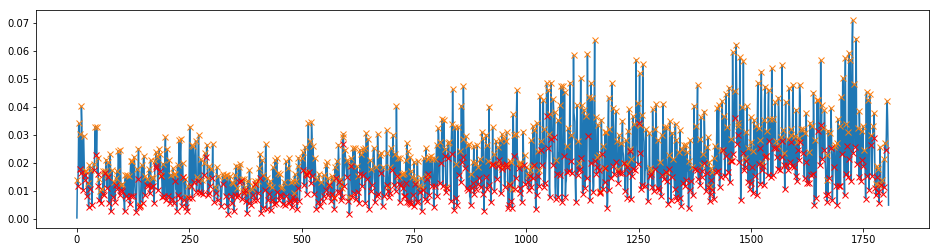

25.016122743700905

In [225]:
data = (pd.read_csv(os.path.join(path, 'TaskAcc', '1003_0_sitng' + '.csv'), parse_dates = ['timestamp'])
                    [['timestamp', 'x', 'y', 'z']])
data.columns = ['Timestamp', 'X', 'Y', 'Z']
data = AccFilterX(data)
data['Mag'] = np.sqrt((data.X**2 + data.Y**2 + data.Z**2))
data['ETime'] = pd.to_datetime(data.Timestamp).values.astype(np.int64) // 10**6
peaks, _ = find_peaks(data.Mag)
troughs, _ = find_peaks(-data.Mag)
plt.figure(figsize = (16, 4))
plt.plot(data.Mag)
plt.plot(peaks, data.Mag[peaks], 'x', troughs, data.Mag[troughs], 'rx')
# plt.xlim(1000, 1500)
plt.show()

# Extract Features Reported by Jeon et al

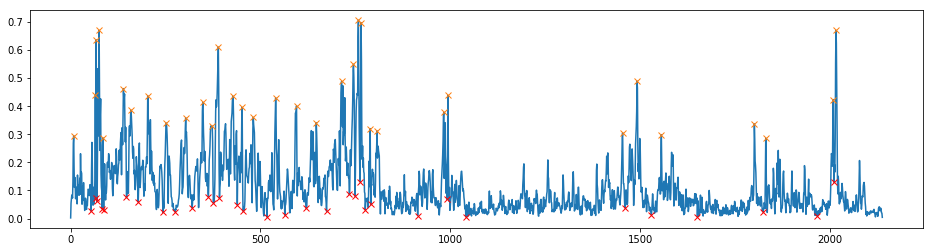

0.3861602622719169
1227.4242424242425
1769.9665812682015


In [261]:
data_clip = (pd.read_csv(os.path.join(path, 'TaskAcc', '1003_1_Sitng' + '.csv'), parse_dates = ['timestamp'])
                    [['timestamp', 'x', 'y', 'z']])
data_clip.columns = ['Timestamp', 'X', 'Y', 'Z']

data = AccFilterX(data_clip)
data['Mag'] = np.sqrt((data[['X', 'Y', 'Z']]**2).sum(axis = 1))
data['ETime'] = pd.to_datetime(data.Timestamp).values.astype(np.int64) // 10**6
peaks, _ = find_peaks(data.Mag, prominence = 0.25)
troughs, _ = find_peaks(-data.Mag, prominence = 0.25)

num_peaks = 0
tot_amp = 0
for peak in peaks:
    peak_pos = bisect.bisect(troughs, peak, lo = 0, hi = len(troughs))
    if (peak_pos == 0) or (peak_pos == len(troughs)):
        continue
    next_trough = troughs[peak_pos]
    prev_trough = troughs[peak_pos - 1]
    num_peaks += 1
    tot_amp += (data.Mag[peak] - data.Mag[prev_trough]) + (data.Mag[peak] - data.Mag[next_trough])

Mean_Amp = tot_amp / (2 * num_peaks)

Avg_Reg = np.sum(np.diff(data.ETime[peaks])) / (len(peaks) - 1)

Reg_Std = np.std(np.diff(data.ETime[peaks]))

plt.figure(figsize = (16, 4))
plt.plot(data.Mag)
plt.plot(peaks, data.Mag[peaks], 'x', troughs, data.Mag[troughs], 'rx')
# plt.xlim(1000, 1500)
plt.show()

print(Mean_Amp)
print(Avg_Reg)
print(Reg_Std)

In [23]:
def AccFilterX(rawdata):

    L = len(rawdata)
    Fs = L / (((pd.to_datetime(rawdata.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                               (pd.to_datetime(rawdata.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    b, a = butter(N = 5, Wn = [1, 16], btype = 'bandpass', fs = Fs)
    filtaxes = filtfilt(b, a, rawdata[['X', 'Y', 'Z']].values, axis = 0)
    filtdata = pd.DataFrame(filtaxes, columns = ['X', 'Y', 'Z'])
    filtdata['Timestamp'] = rawdata.Timestamp.values
    filtdata = filtdata[['Timestamp', 'X', 'Y', 'Z']]
    
    return filtdata

def featureXTRACT9000(data_clip):

    data = AccFilterX(data_clip)
    data['Mag'] = np.sqrt((data[['X', 'Y', 'Z']]**2).sum(axis = 1))
    data['ETime'] = pd.to_datetime(data.Timestamp).values.astype(np.int64) // 10**6
    peaks, _ = find_peaks(data.Mag)
    troughs, _ = find_peaks(-data.Mag)

    num_peaks = 0
    tot_amp = 0
    for peak in peaks:
        peak_pos = bisect.bisect(troughs, peak, lo = 0, hi = len(troughs))
        if (peak_pos == 0) or (peak_pos == len(troughs)):
            continue
        next_trough = troughs[peak_pos]
        prev_trough = troughs[peak_pos - 1]
        num_peaks += 1
        tot_amp += (data.Mag[peak] - data.Mag[prev_trough]) + (data.Mag[peak] - data.Mag[next_trough])

    Mean_Amp = tot_amp / (2 * num_peaks)

    Avg_Reg = np.sum(np.diff(data.ETime[peaks])) / (len(peaks) - 1)

    Reg_Std = np.std(np.diff(data.ETime[peaks]))
    
    L = len(data)
    Fs = L / (((data.ETime.values)[-1] - (data.ETime.values)[0]) / 1000)
    P1X = np.abs((fft(data.X)) / L)[:int(L / 2 + 1)]
    P1Y = np.abs((fft(data.Y)) / L)[:int(L / 2 + 1)]
    P1Z = np.abs((fft(data.Z)) / L)[:int(L / 2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1X'] = P1X
    clipFFT['P1Y'] = P1Y
    clipFFT['P1Z'] = P1Z
    clipFFT['P1'] = np.mean(clipFFT[['P1X', 'P1Y', 'P1Z']], axis = 1)

    Peak_Power = np.max(clipFFT.P1)

    Peak_Freq = float(clipFFT.f[clipFFT.P1 == Peak_Power].values)

    Mean_Freq = np.sum(clipFFT.f * clipFFT.P1) / np.sum(clipFFT.P1)

    Mean_Power = float(clipFFT.P1[clipFFT.f == min(clipFFT.f, key = lambda x: abs(x - Mean_Freq))].values)
    
    LFband = clipFFT[0:bisect.bisect(clipFFT.f, Mean_Freq, lo = 0, hi = len(clipFFT.f) - 1)]
    TFband = clipFFT[bisect.bisect(clipFFT.f, (Mean_Freq - 3), lo = 0, hi = len(clipFFT.f) - 1):
                     bisect.bisect(clipFFT.f, (Mean_Freq + 3), lo = 0, hi = len(clipFFT.f) - 1)]
    HFband = clipFFT[bisect.bisect(clipFFT.f, Mean_Freq, lo = 0, hi = len(clipFFT.f) - 1):
                     bisect.bisect(clipFFT.f, 16, lo = 0, hi = len(clipFFT.f) - 1)]

    L_Power = np.sum(LFband.P1)

    T_Power = np.sum(TFband.P1)

    H_Power = np.sum(HFband.P1)

    tot_power = np.sum(clipFFT.P1)

    L_Rel_Power = L_Power / tot_power

    T_Rel_Power = T_Power / tot_power

    H_Rel_Power = H_Power / tot_power
    
    Log_MA = np.log(Mean_Amp)
    
    Log_PP = np.log(Peak_Power)

    Log_MP = np.log(Mean_Power)

    Log_LP = np.log(L_Power)

    Log_TP = np.log(T_Power)

    Log_HP = np.log(H_Power)
    
    NormRMSE = 0.01
    if (np.sqrt(np.mean((data.Mag - np.mean(data.Mag))**2))) > NormRMSE:
        anomaly = 1
    else:
        anomaly = 0
    
    X = np.array([Mean_Amp, Avg_Reg, Reg_Std, 
                  Peak_Power, Peak_Freq, Mean_Freq, Mean_Power, 
                  L_Power, T_Power, H_Power, 
                  L_Rel_Power, T_Rel_Power, H_Rel_Power,
                  Log_MA, Log_PP, Log_MP, Log_LP, Log_TP, Log_HP,
                  anomaly])
    
    return X

def DataAggregatorONE(file):
    
    TaskFeatures = pd.DataFrame()
    
    subject = file[:4]
    visit = file[5:6]
    task = file[7:]
    print(file)
    
    features_list = ['Mean_Amp', 'Avg_Reg', 'Reg_Std',
                     'Peak_Power', 'Peak_Freq', 'Mean_Freq', 'Mean_Power',
                     'L_Power', 'T_Power', 'H_Power',
                     'L_Rel_Power', 'T_Rel_Power', 'H_Rel_Power',
                     'Log_MA', 'Log_PP', 'Log_MP', 'Log_LP', 'Log_TP', 'Log_HP',
                     'Anomaly']

    try:
        data = (pd.read_csv(os.path.join(path, 'TaskAcc', file + '.csv'), parse_dates = ['timestamp'])
                [['timestamp', 'x', 'y', 'z']])
        data.columns = ['Timestamp', 'X', 'Y', 'Z']
    except(FileNotFoundError):
        print('No data found for subject %s %s visit %s' % (subject, task, visit))
        return TaskFeatures

    data = data.sort_values(by = 'Timestamp', axis = 0)
    data['TimeWdw'] = [(tm - datetime.timedelta(minutes = 0,
                                                    seconds = tm.second % 1.5,
                                                    microseconds = tm.microsecond)) 
                        for tm in data.Timestamp]
    data['TimeIdx'] = (data.Timestamp.values - data.Timestamp.values[0]).astype('timedelta64[ms]').astype(int)
    data = data.set_index('TimeIdx')

    F = []
    for t in data.TimeWdw.unique():
        clip = data.loc[(data.TimeWdw == t) | (data.TimeWdw == (t + np.timedelta64(1500, 'ms')))]
        if (clip.empty or (len(clip.TimeWdw) < 100)):
            continue
        F.append(featureXTRACT9000(clip[['Timestamp', 'X', 'Y', 'Z']]))

    TaskFeatures = pd.DataFrame(data = F, columns = features_list, dtype = 'float32')    
    
    return TaskFeatures

s_time = time.time()

clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
clinicData = clinicData[(clinicData.TaskAbb == 'Sitng') | (clinicData.TaskAbb == 'Stndg')]

DataFeatures = pd.DataFrame()
for task in clinicData.iterrows():
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    TaskFeatures = DataAggregatorONE(file)
    if TaskFeatures.empty:
        continue
    featcols = list(TaskFeatures.columns)
    
    TaskFeatures['SubjID'] = int(task[1]['SubjID'])
    TaskFeatures['Visit'] = VisitNumber[task[1]['Visit']]
    TaskFeatures['TaskAbb'] = task[1]['TaskAbb']
    TaskFeatures['Clip'] = range(len(TaskFeatures))
    TaskFeatures['Tremor'] = task[1]['Tremor - ' + task[1]['Side']]
    
    cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor'] + featcols
    TaskFeatures = TaskFeatures[cols]
    
    if DataFeatures.empty:
        DataFeatures = TaskFeatures
        continue
    DataFeatures = pd.concat([DataFeatures, TaskFeatures], ignore_index = True)

DataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'), index = False)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')

1003_0_Sitng
1003_0_Stndg
1003_1_Sitng
1003_1_Stndg
1003_2_Sitng
1003_2_Stndg
1003_3_Sitng
1003_3_Stndg
1003_4_Sitng
1003_4_Stndg
1003_5_Sitng
1003_5_Stndg
1003_6_Sitng
No data found for subject 1003 Sitng visit 6
1003_6_Stndg
No data found for subject 1003 Stndg visit 6
1004_0_Sitng
1004_0_Stndg
1004_1_Sitng
1004_1_Stndg
1004_2_Sitng
1004_2_Stndg
1004_3_Sitng
1004_3_Stndg
1004_4_Sitng
1004_4_Stndg
1004_5_Sitng
No data found for subject 1004 Sitng visit 5
1004_5_Stndg
No data found for subject 1004 Stndg visit 5
1004_6_Sitng
1004_6_Stndg
1005_0_Sitng
1005_0_Stndg
No data found for subject 1005 Stndg visit 0
1005_1_Sitng
1005_1_Stndg
1005_2_Sitng
1005_2_Stndg
1005_3_Sitng
1005_3_Stndg
1005_4_Sitng
No data found for subject 1005 Sitng visit 4
1005_4_Stndg
No data found for subject 1005 Stndg visit 4
1005_5_Sitng
No data found for subject 1005 Sitng visit 5
1005_5_Stndg
No data found for subject 1005 Stndg visit 5
1005_6_Sitng
No data found for subject 1005 Sitng visit 6
1005_6_Stndg
No d

0 hours 4 minutes 33 seconds


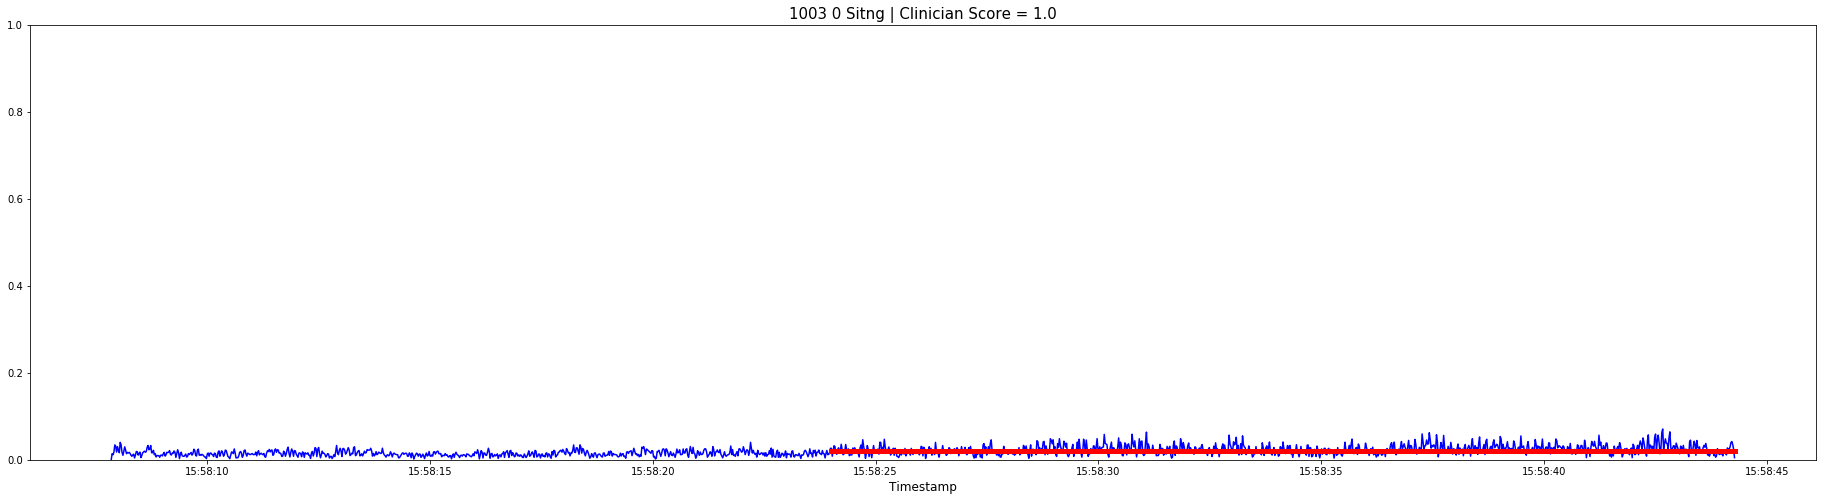

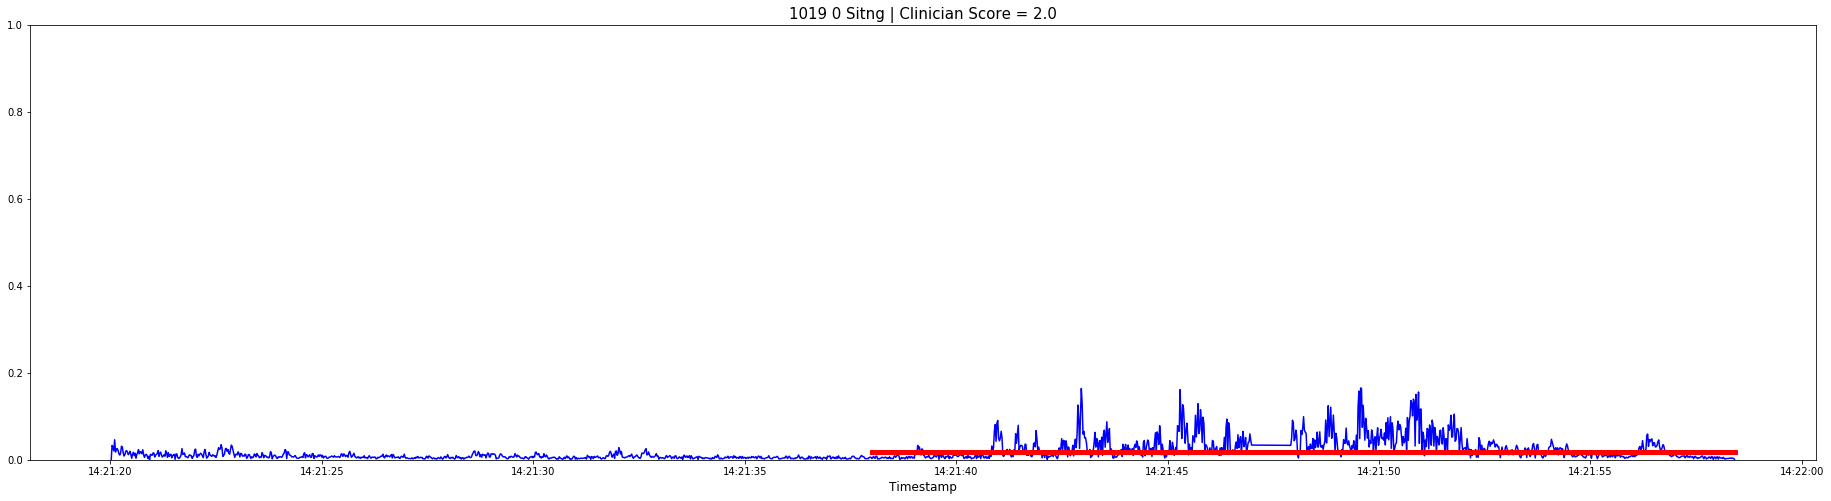

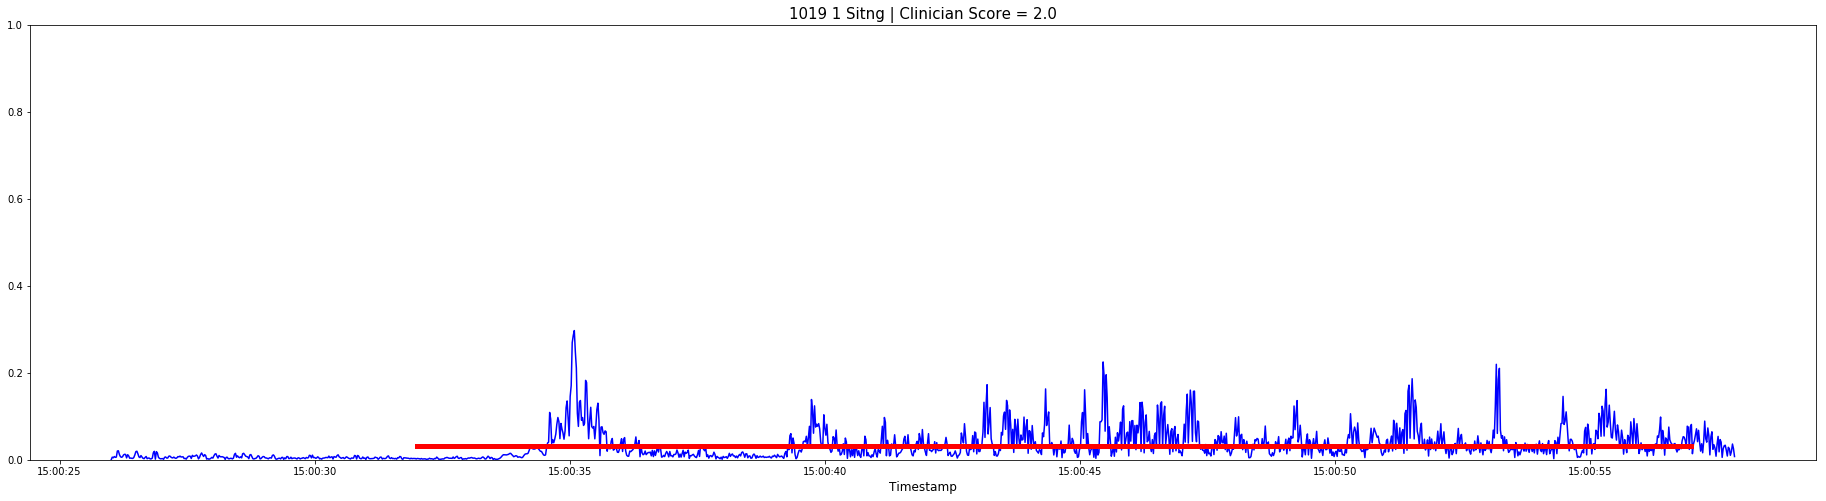

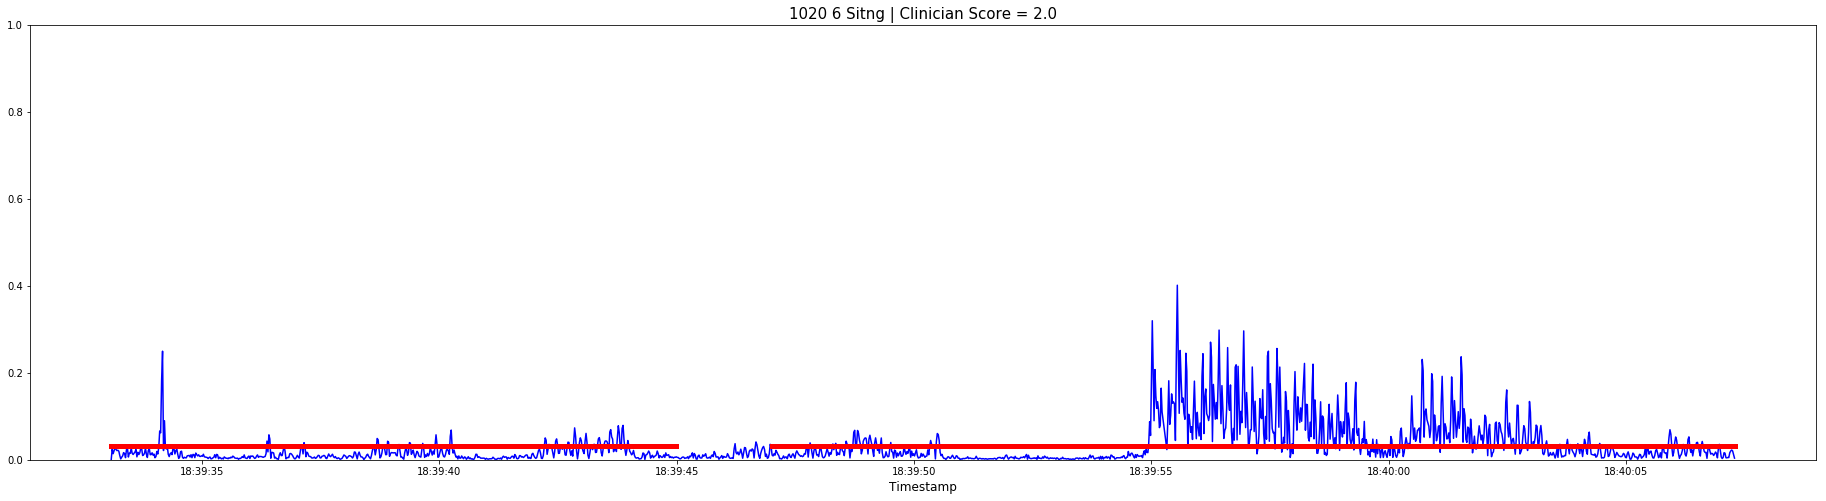

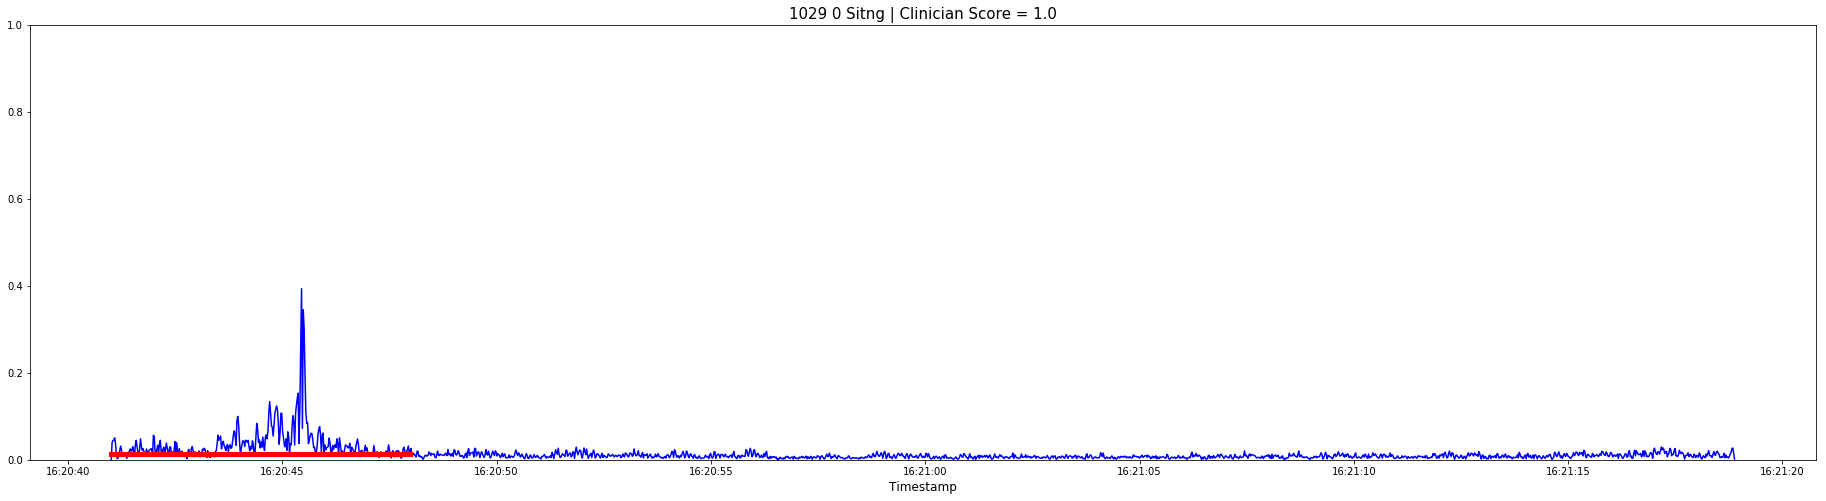

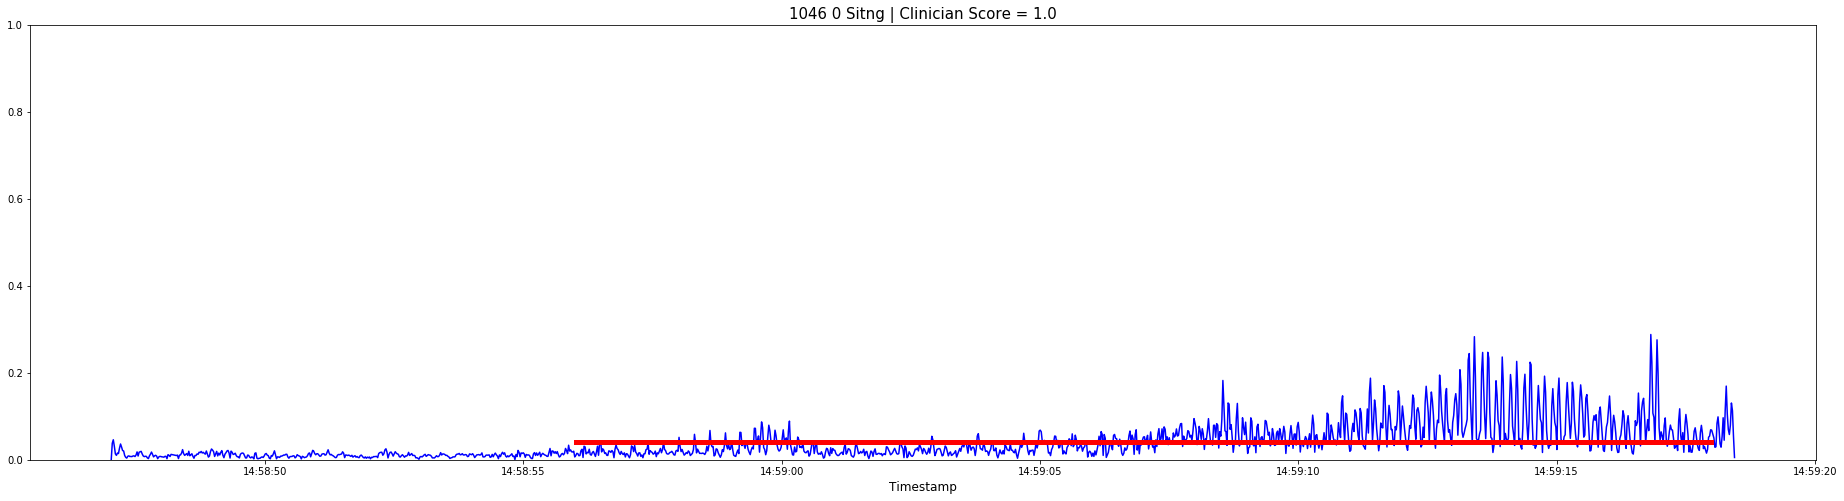

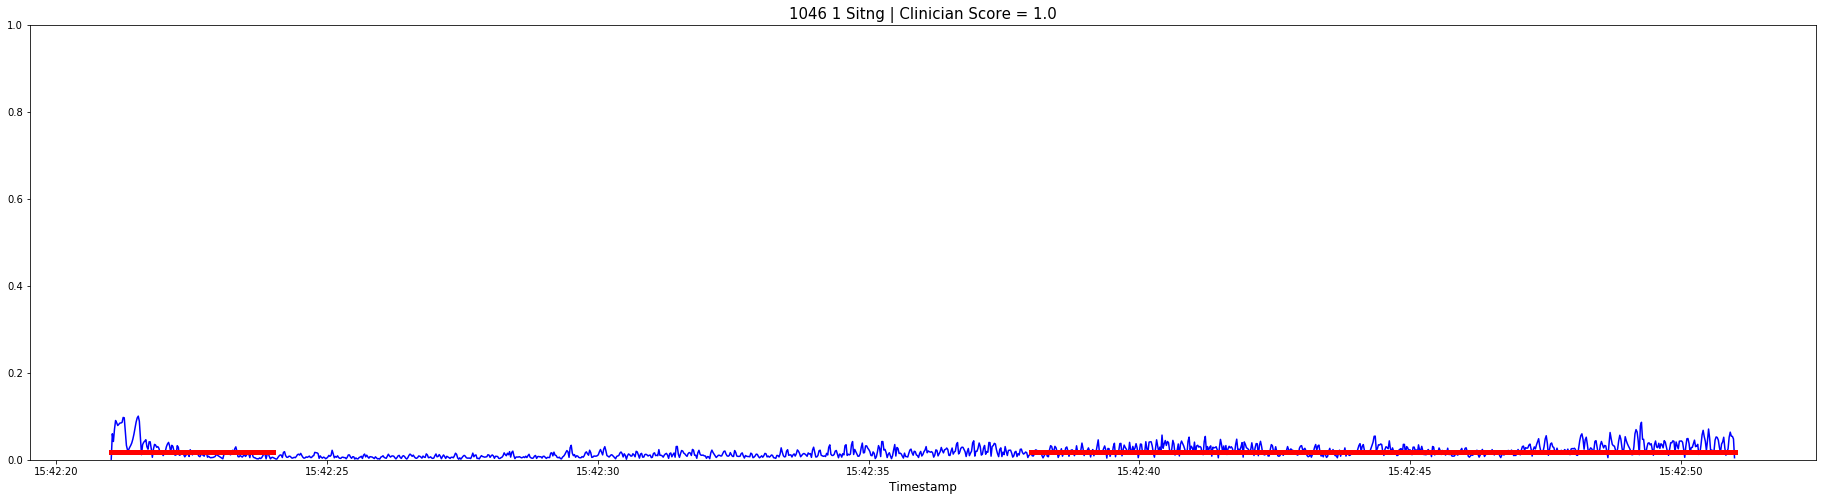

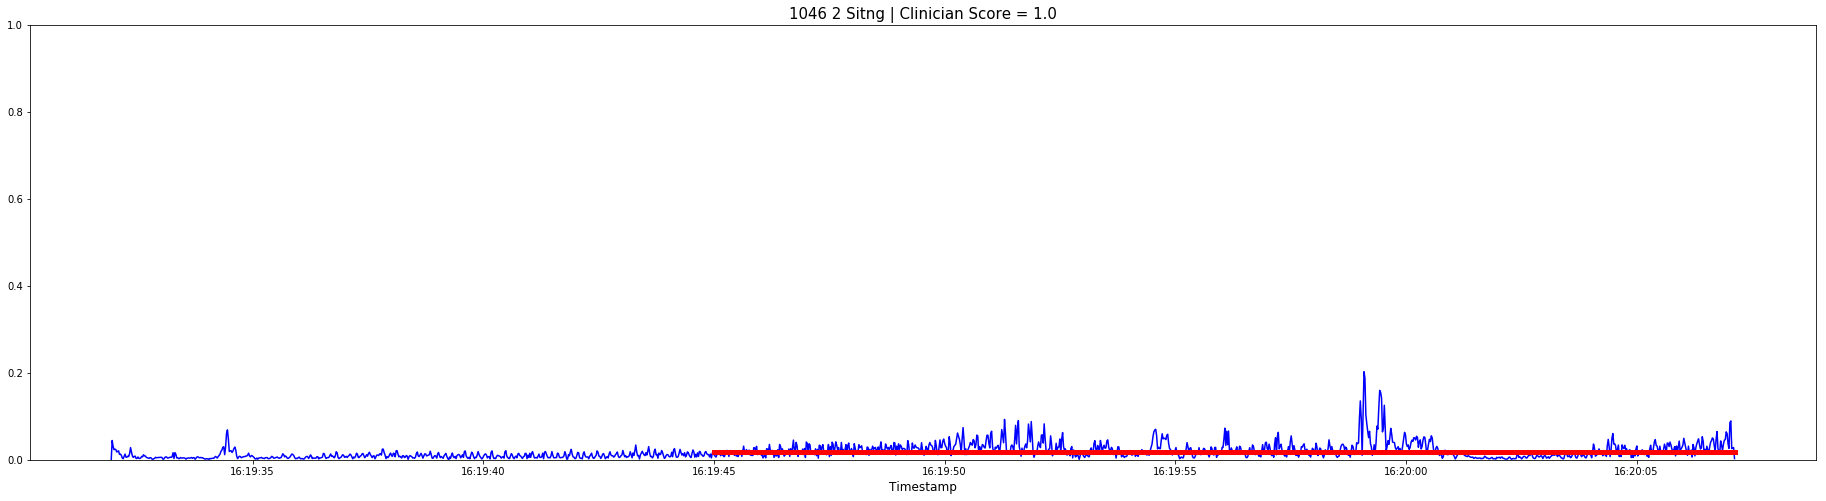

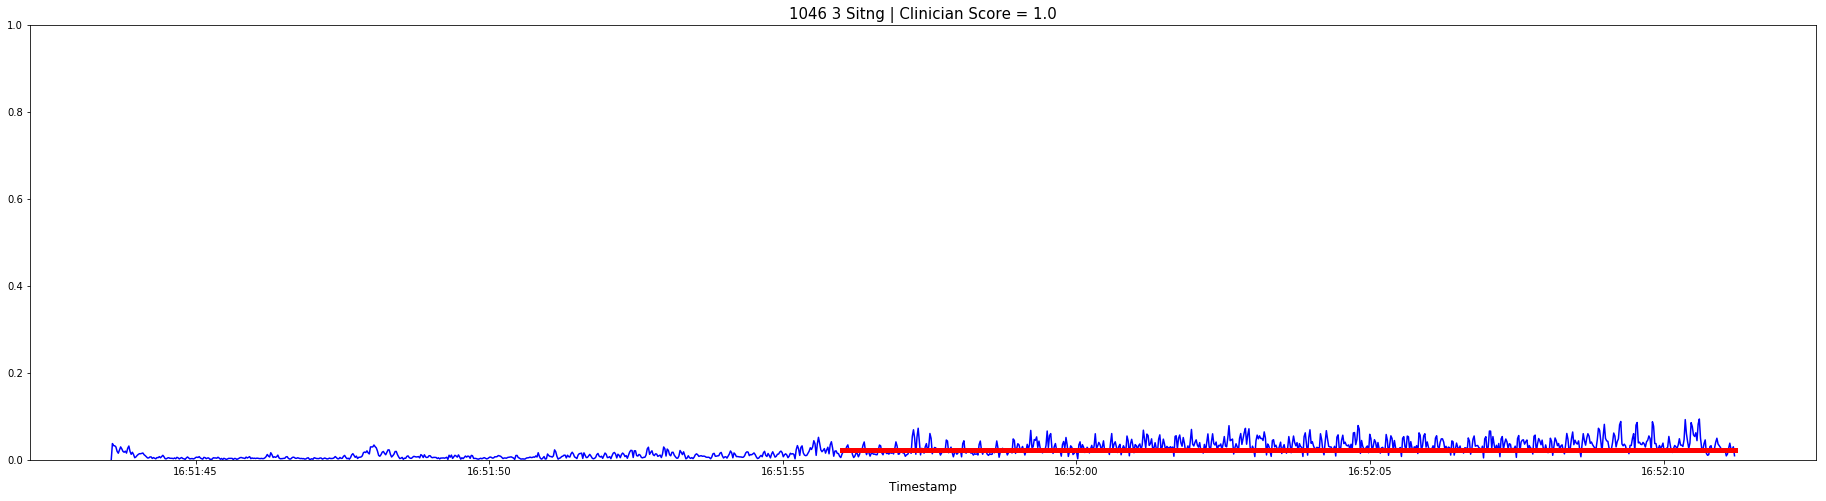

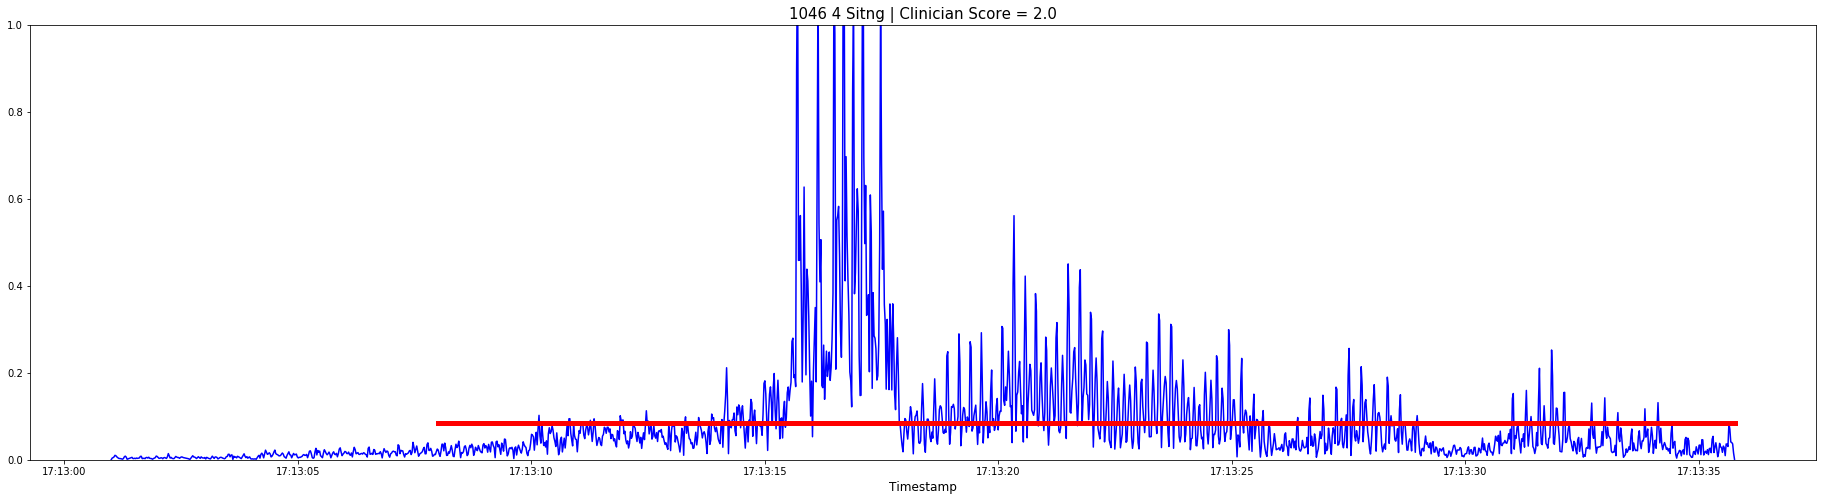

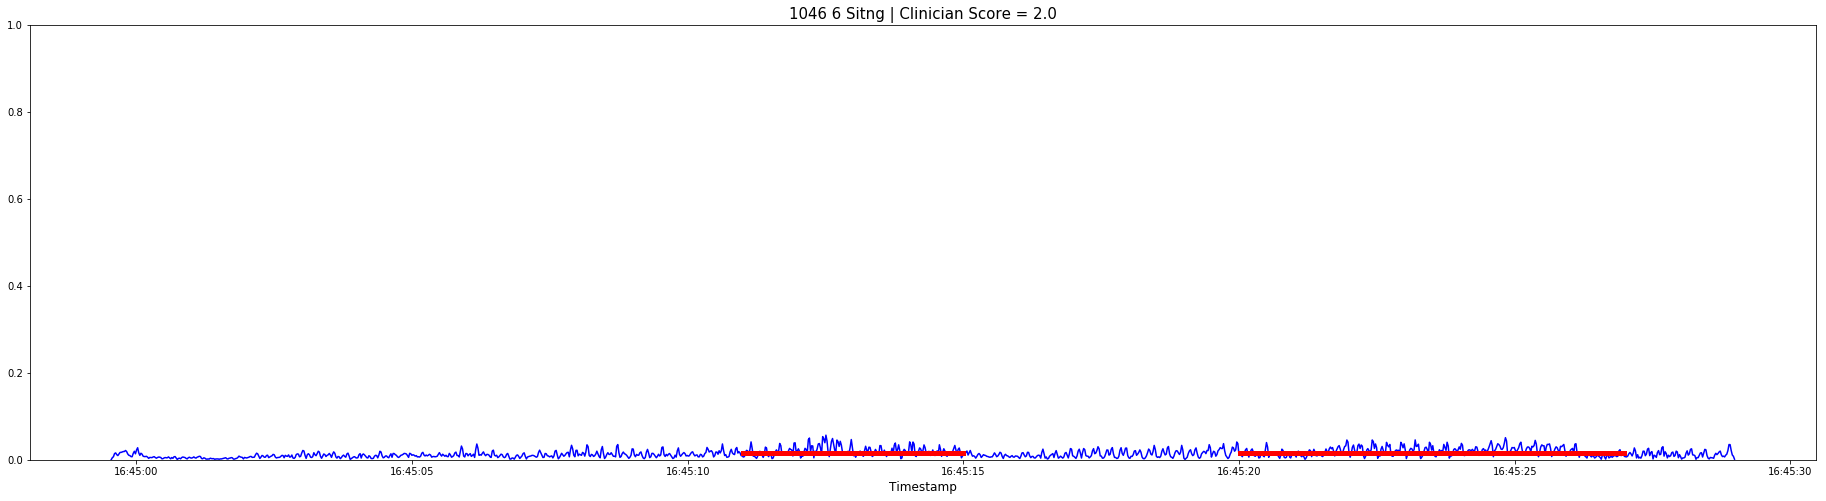

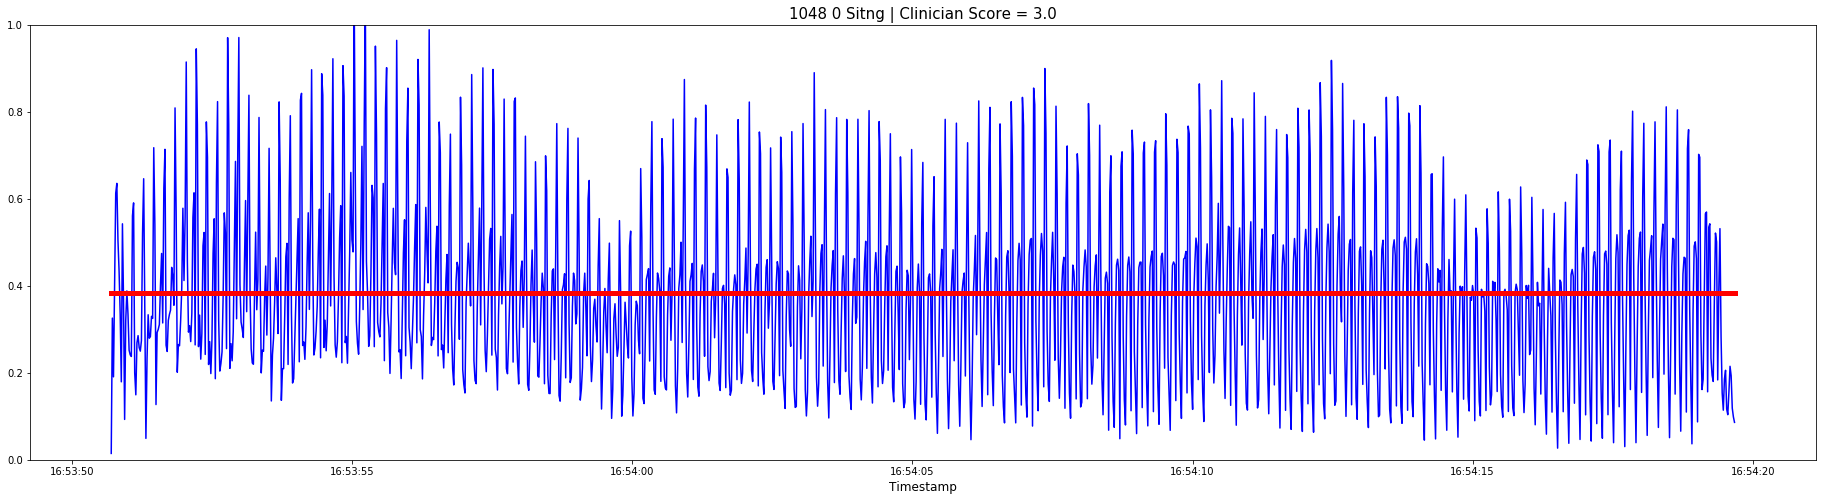

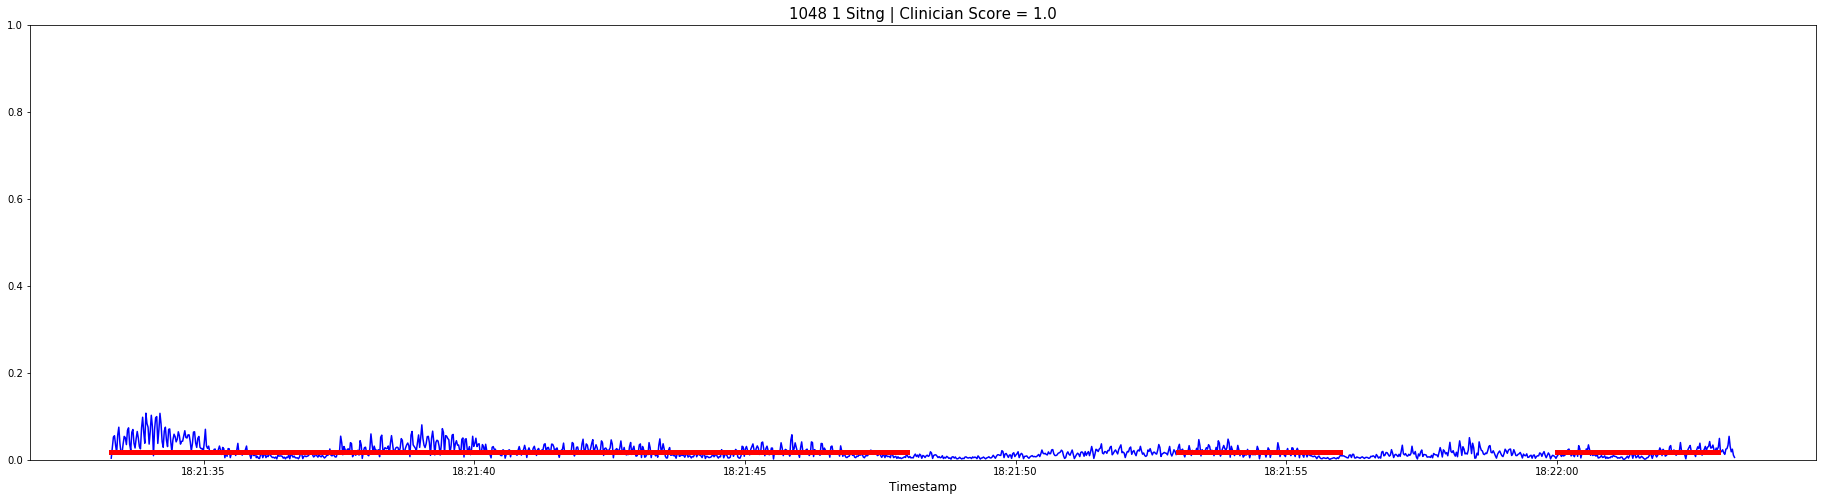

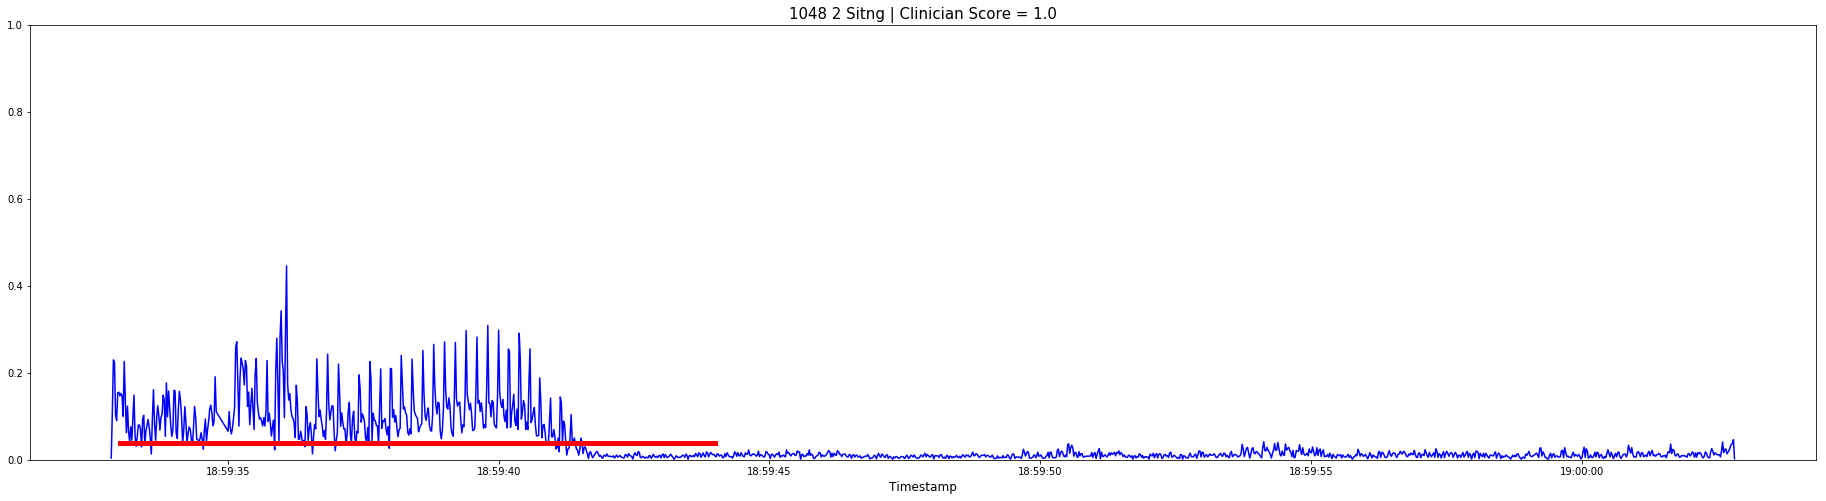

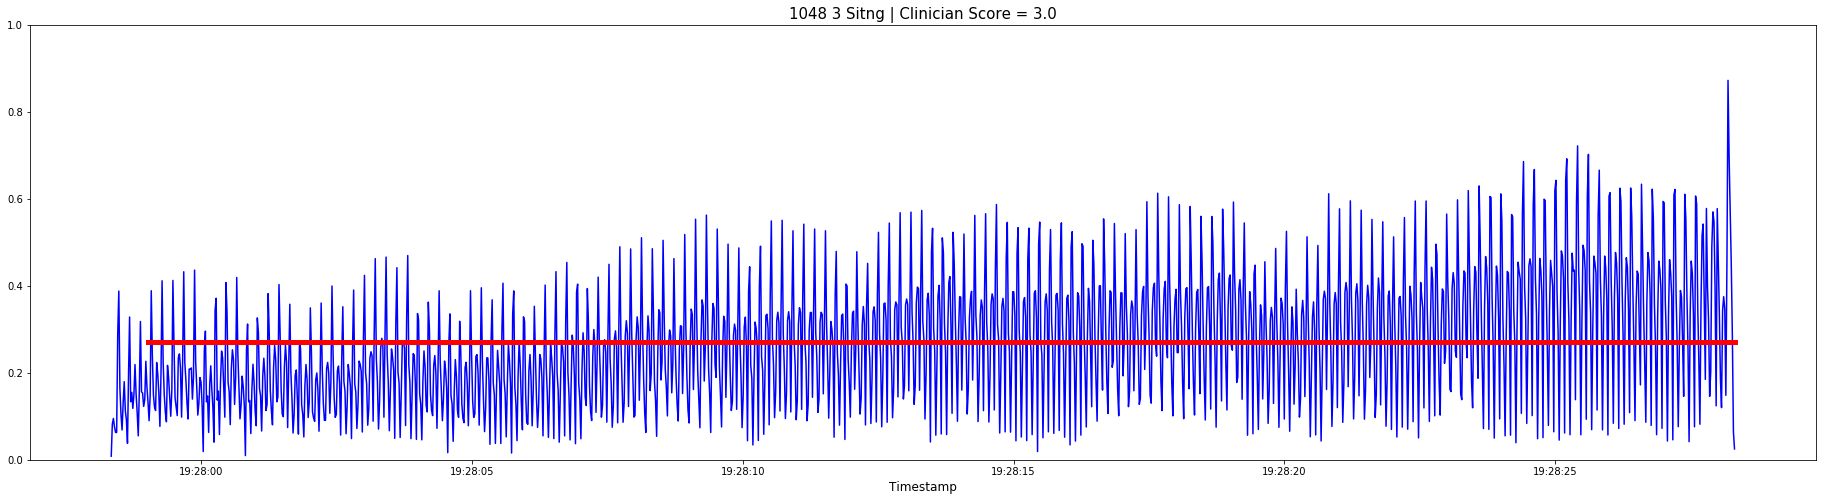

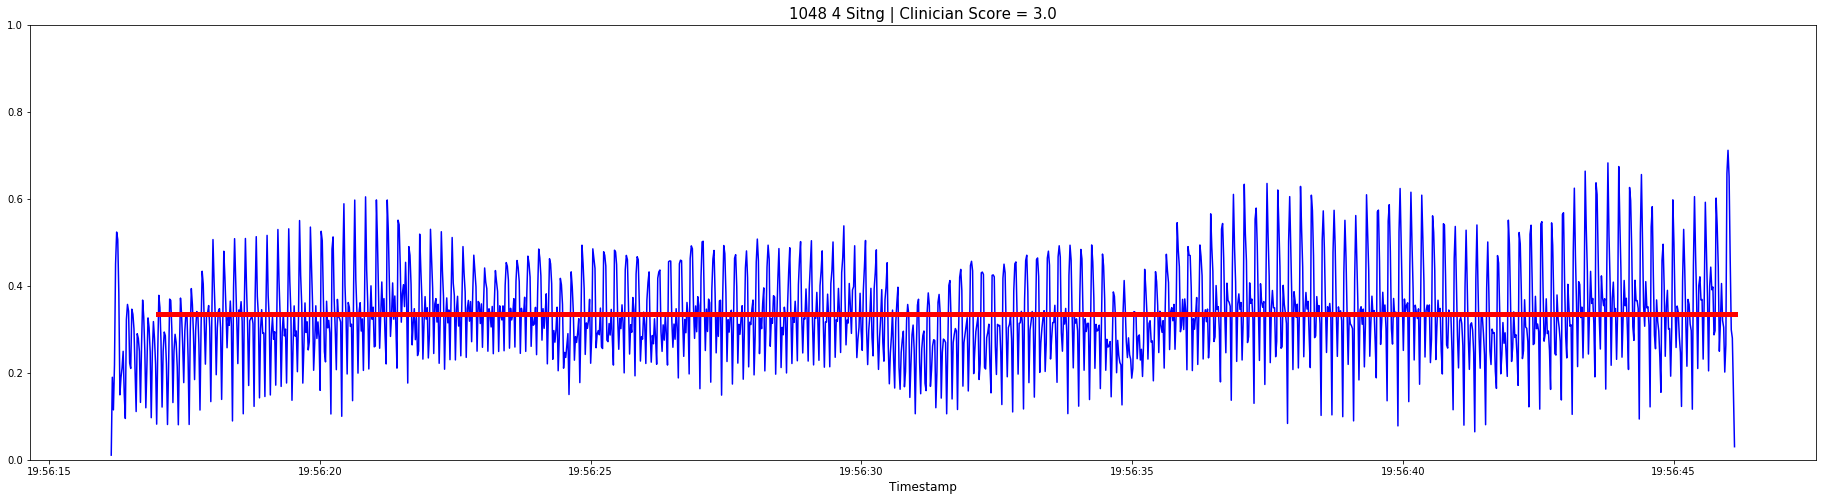

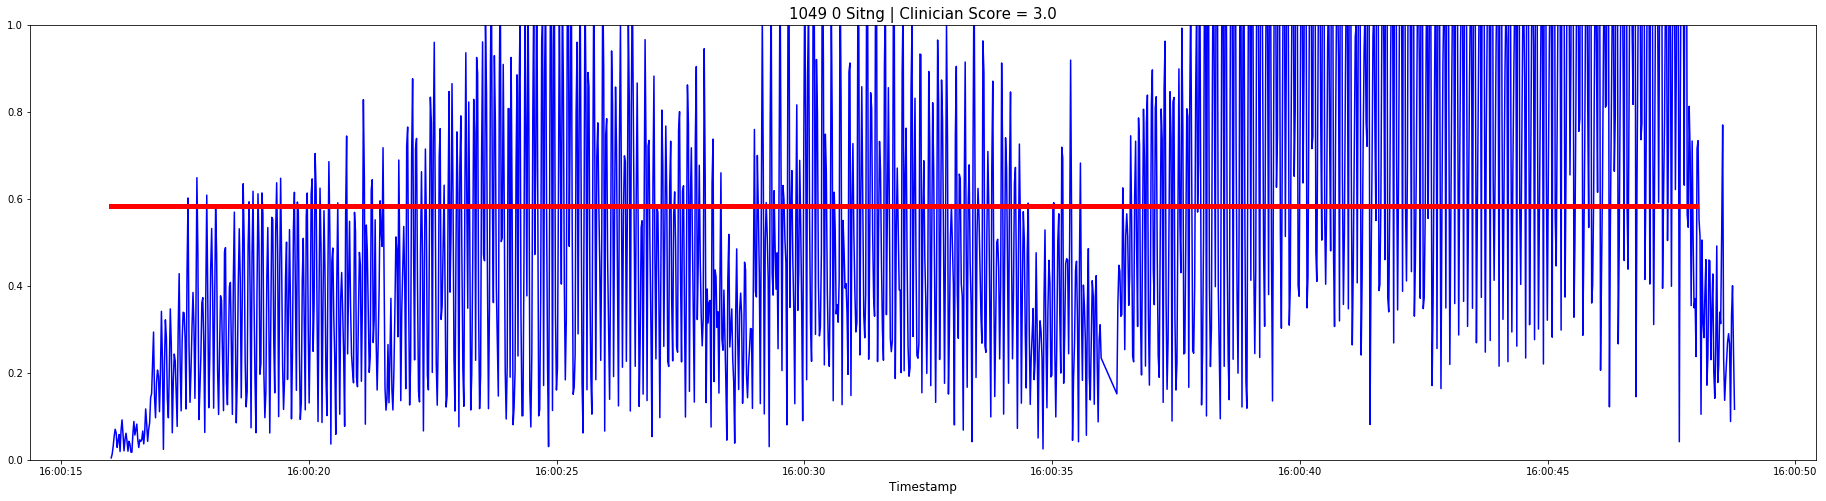

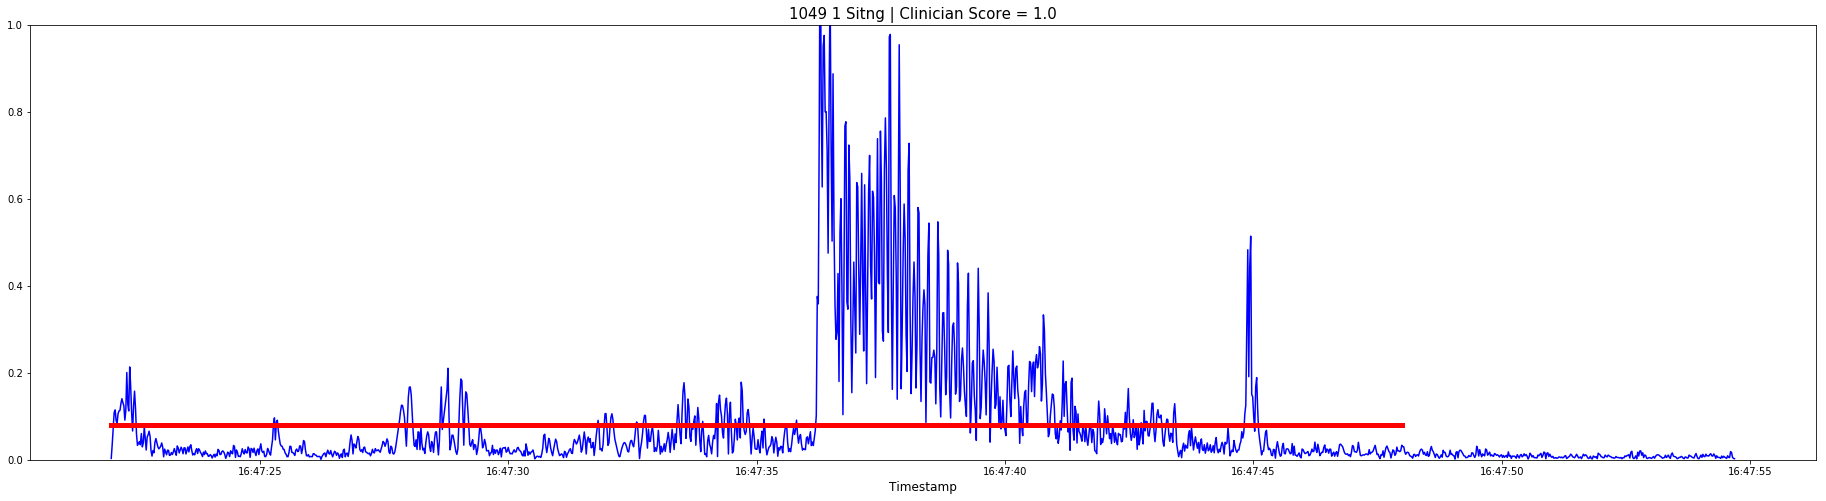

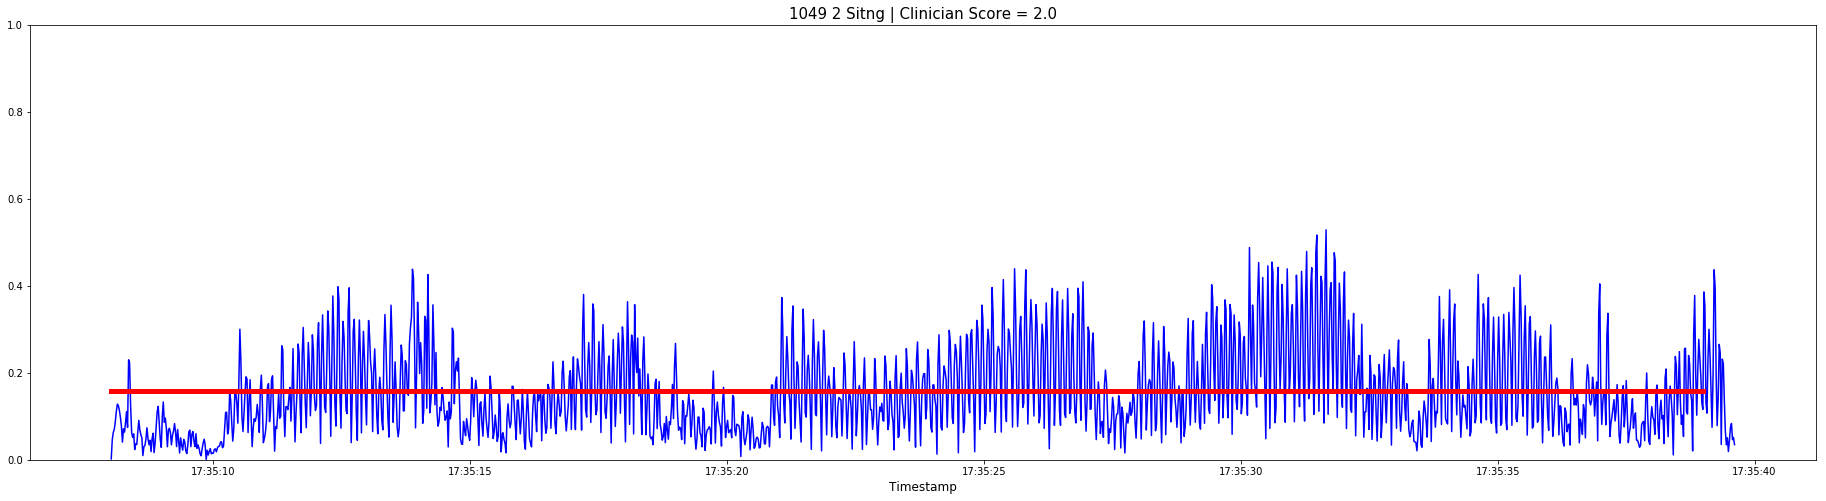

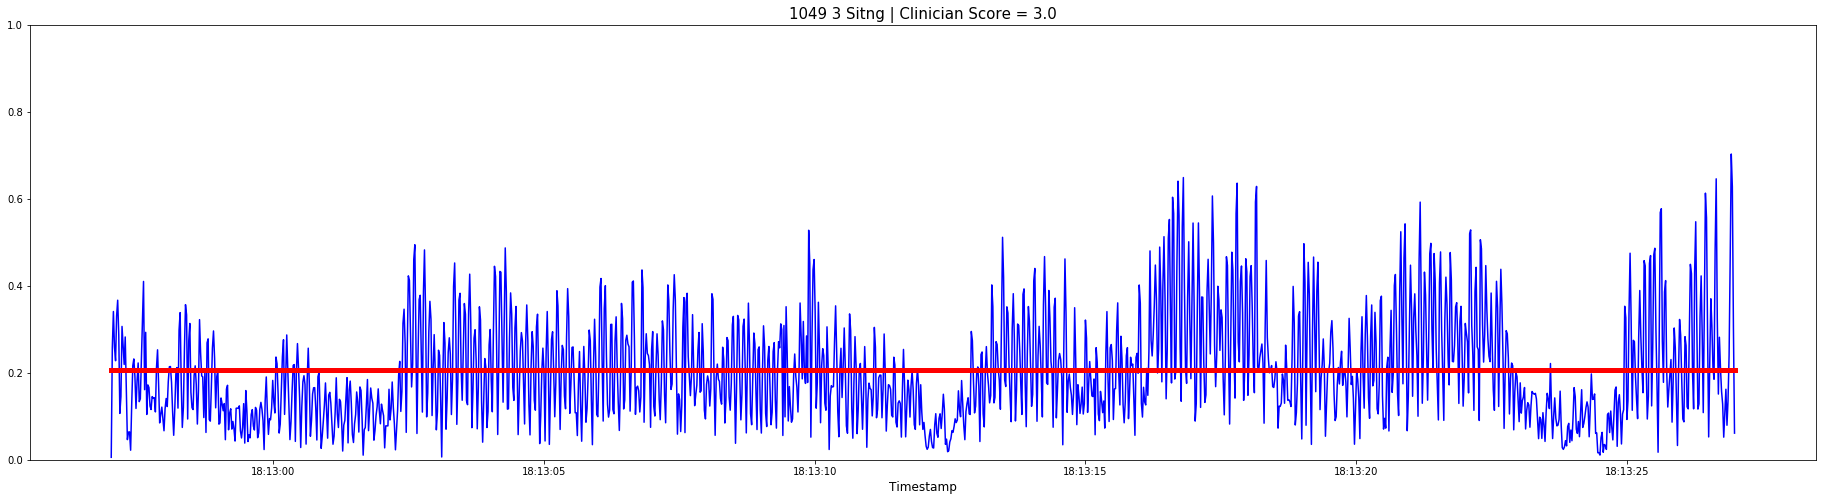

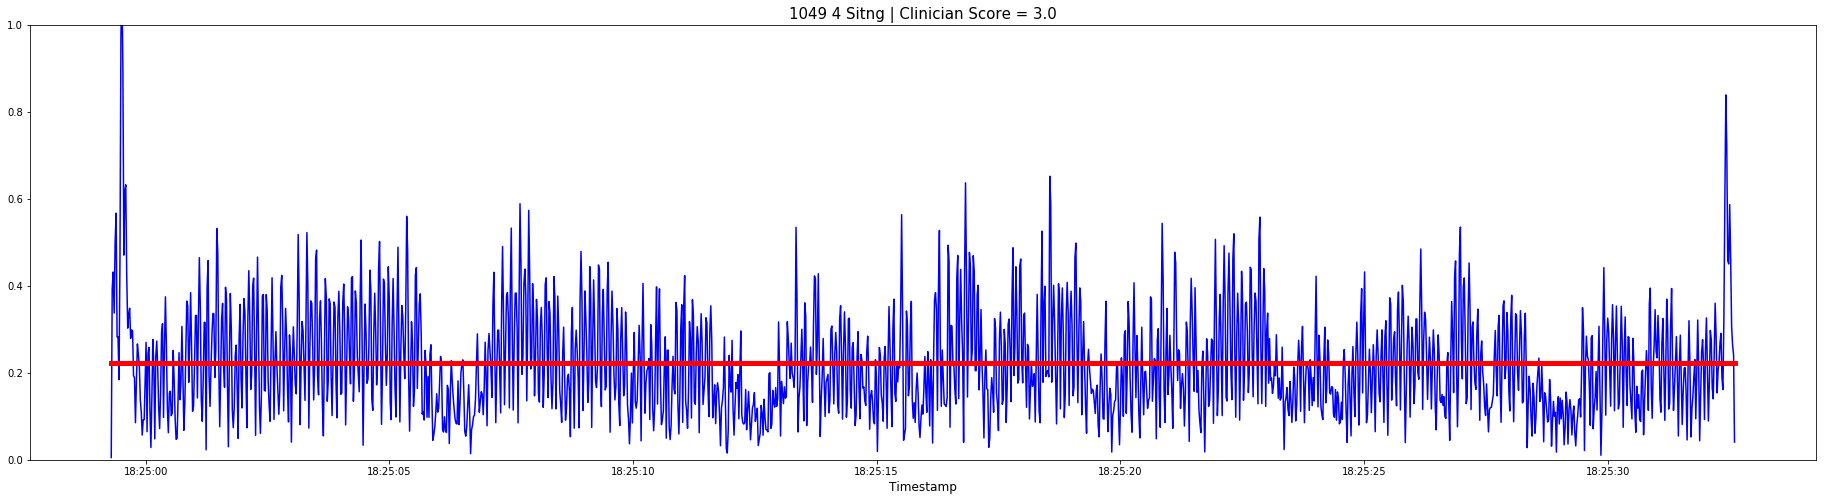

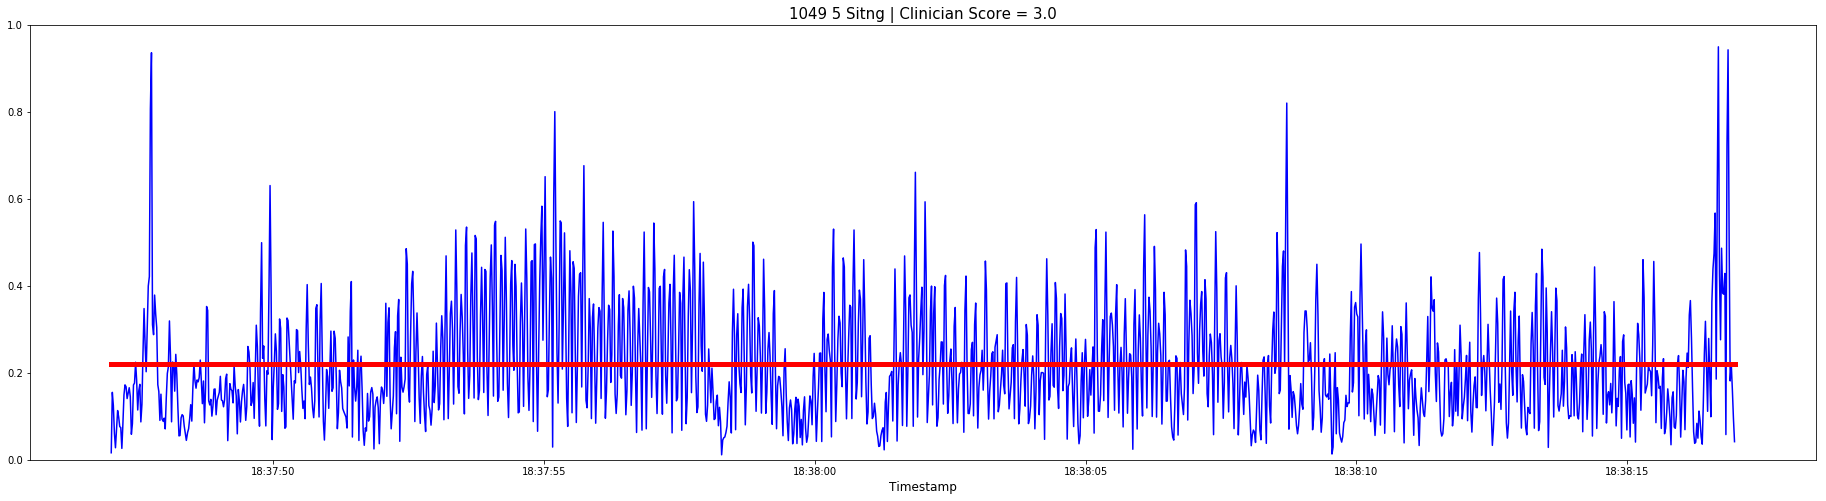

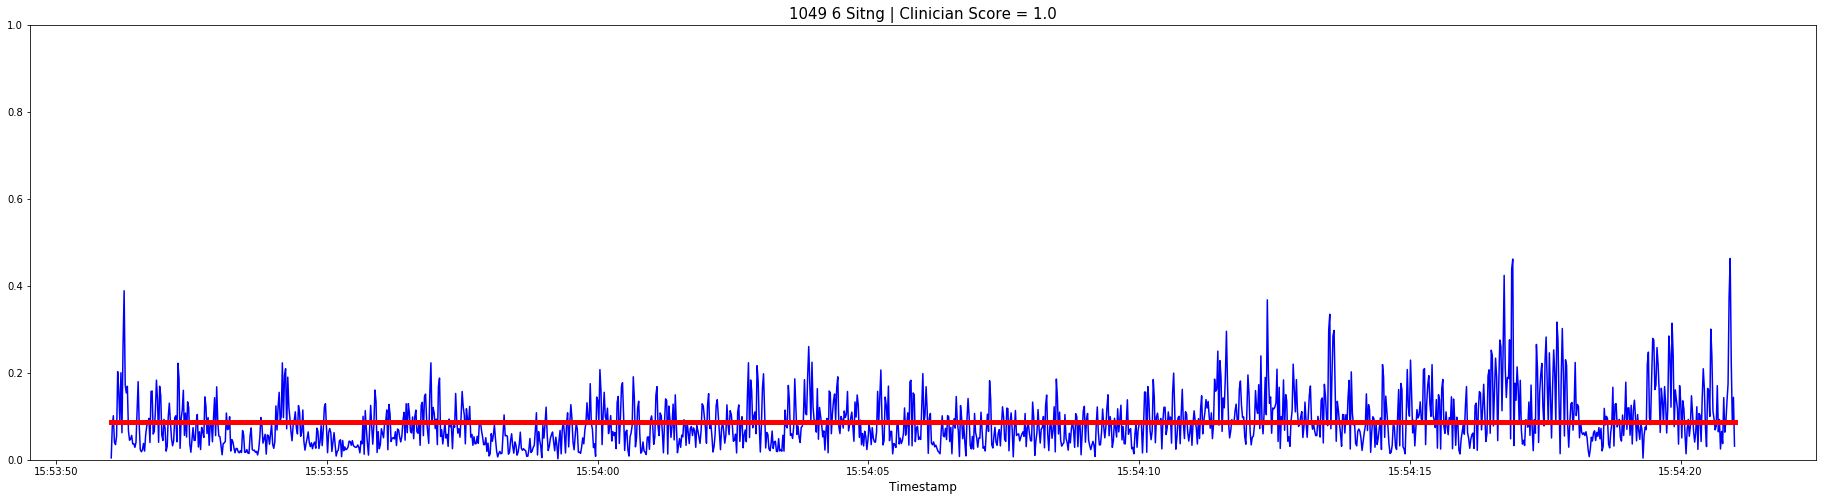

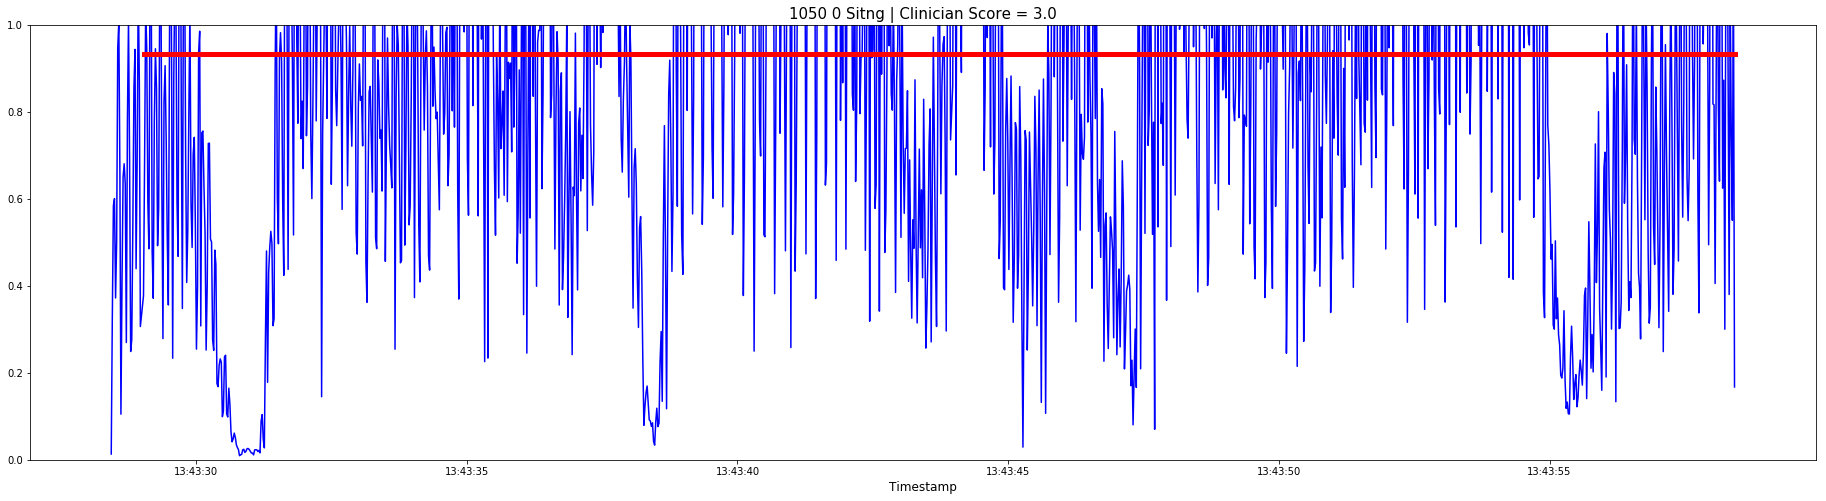

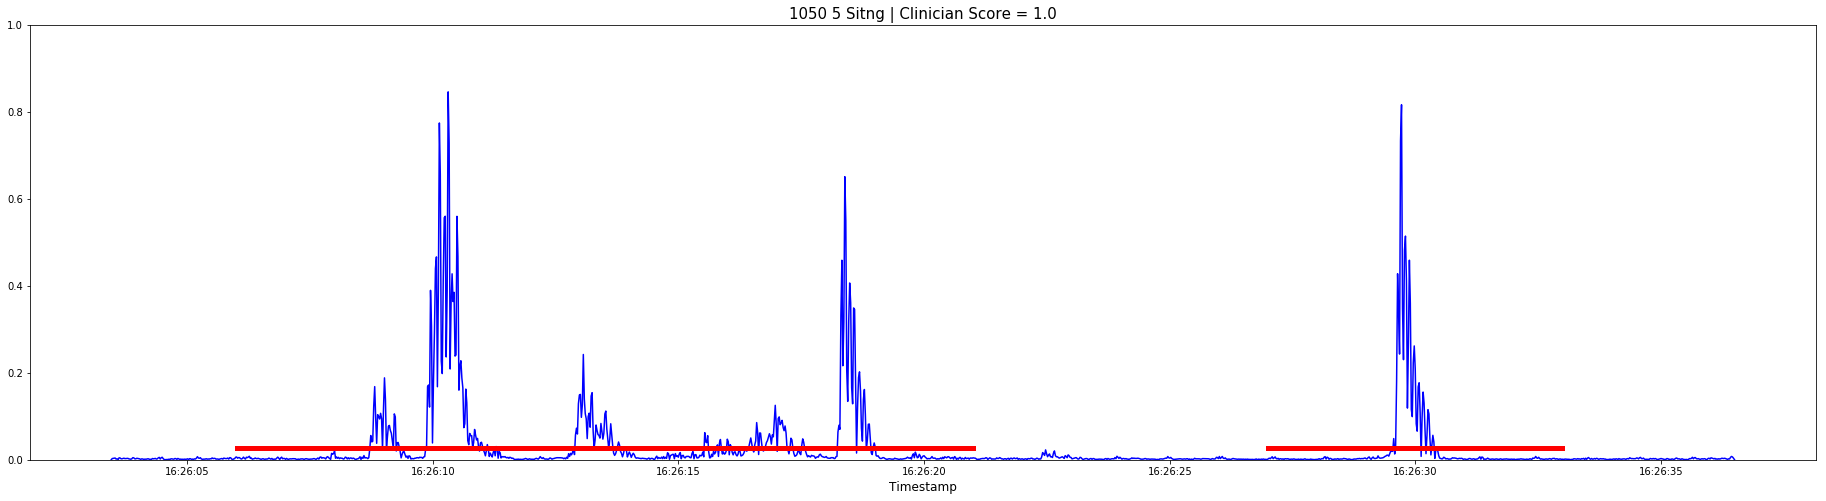

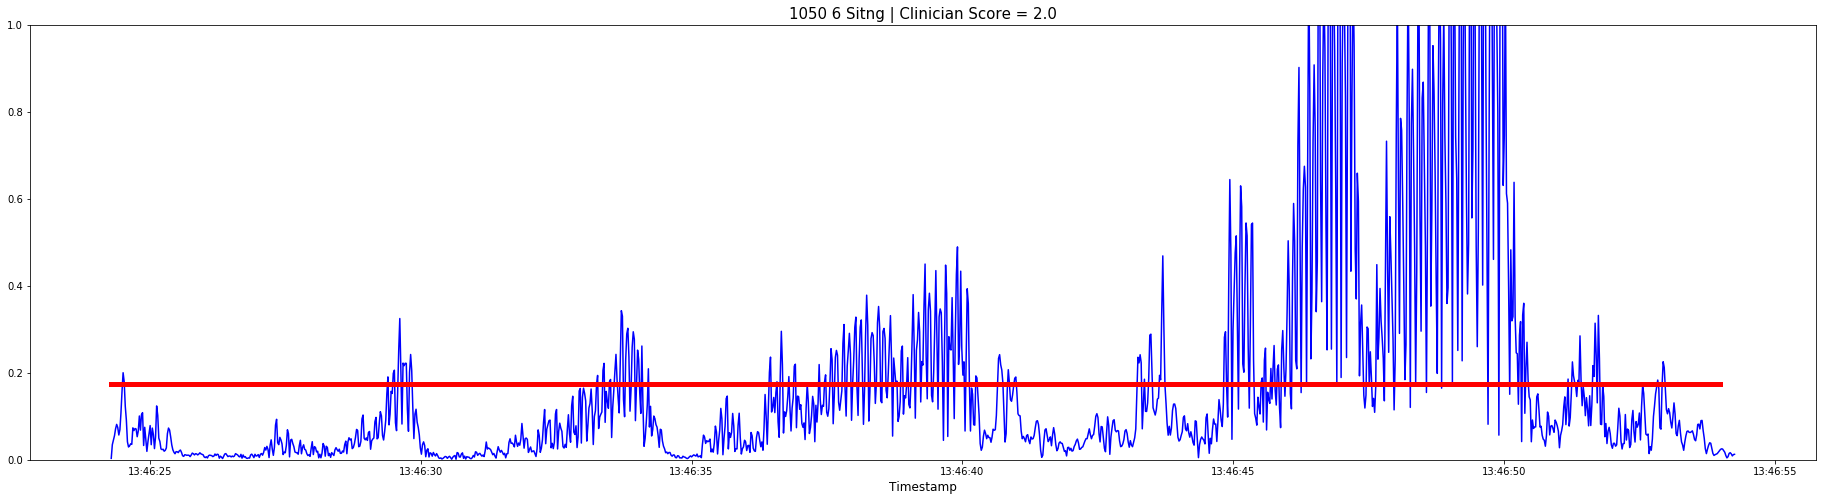

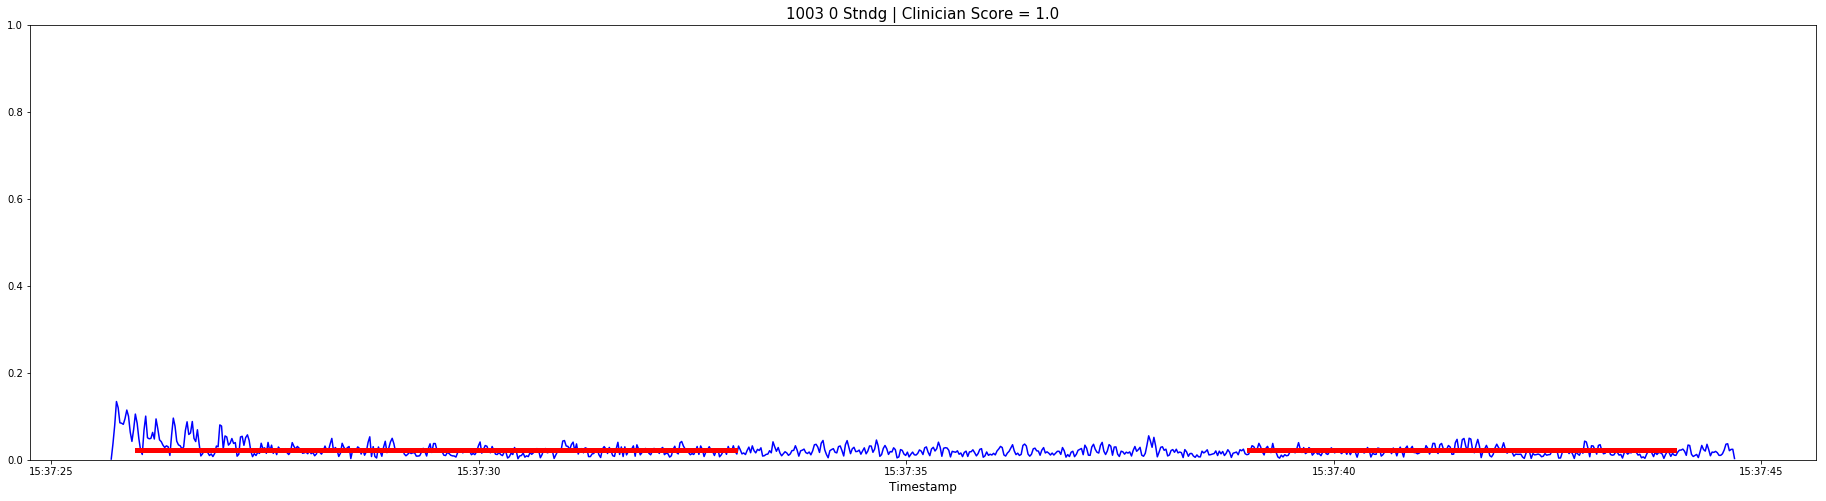

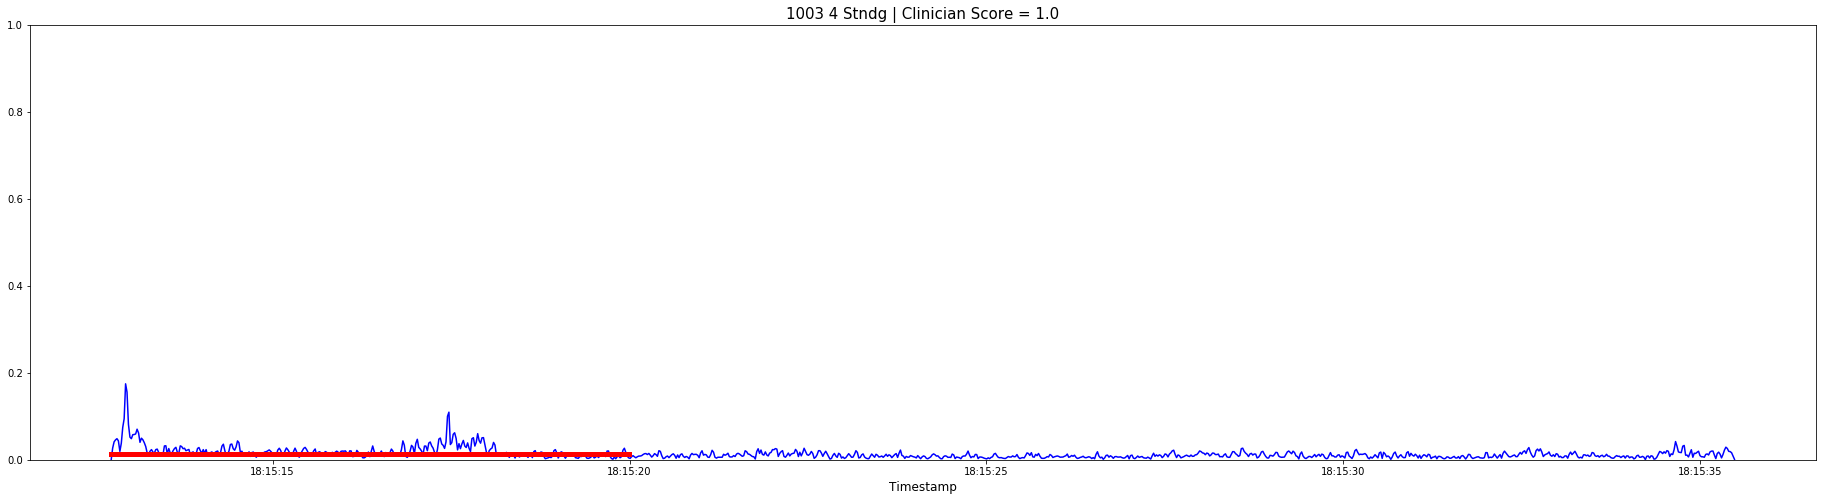

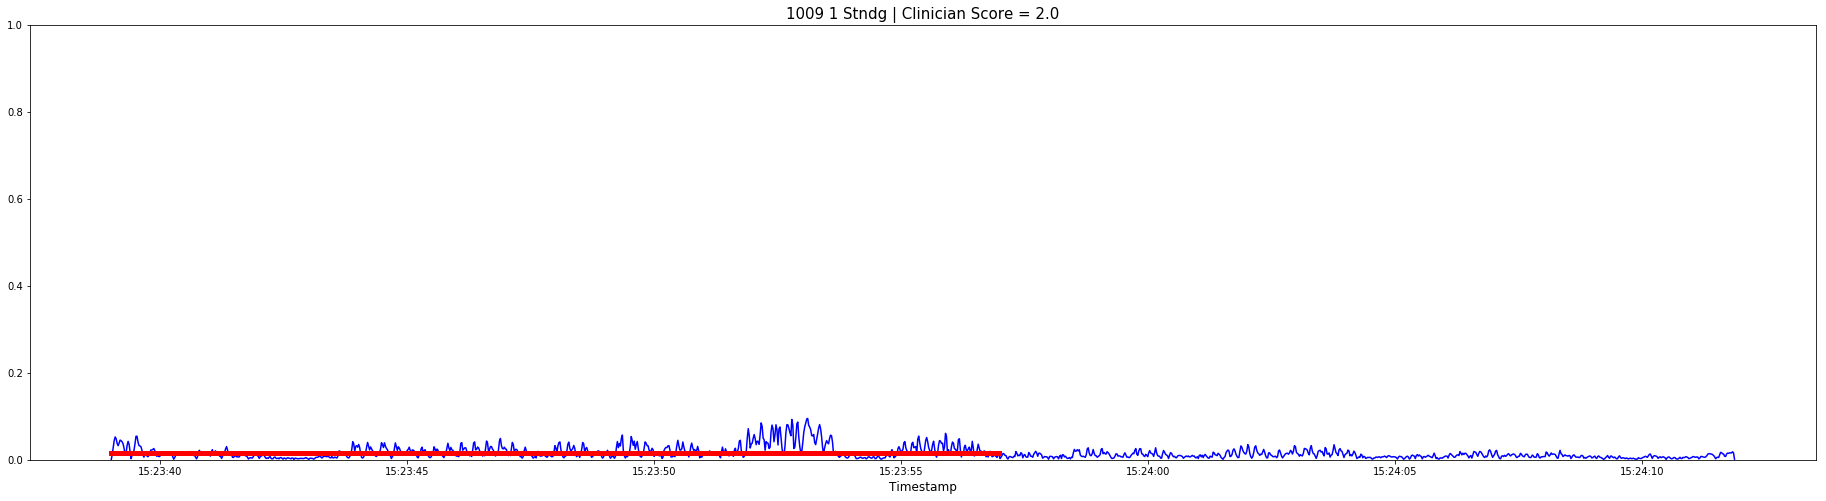

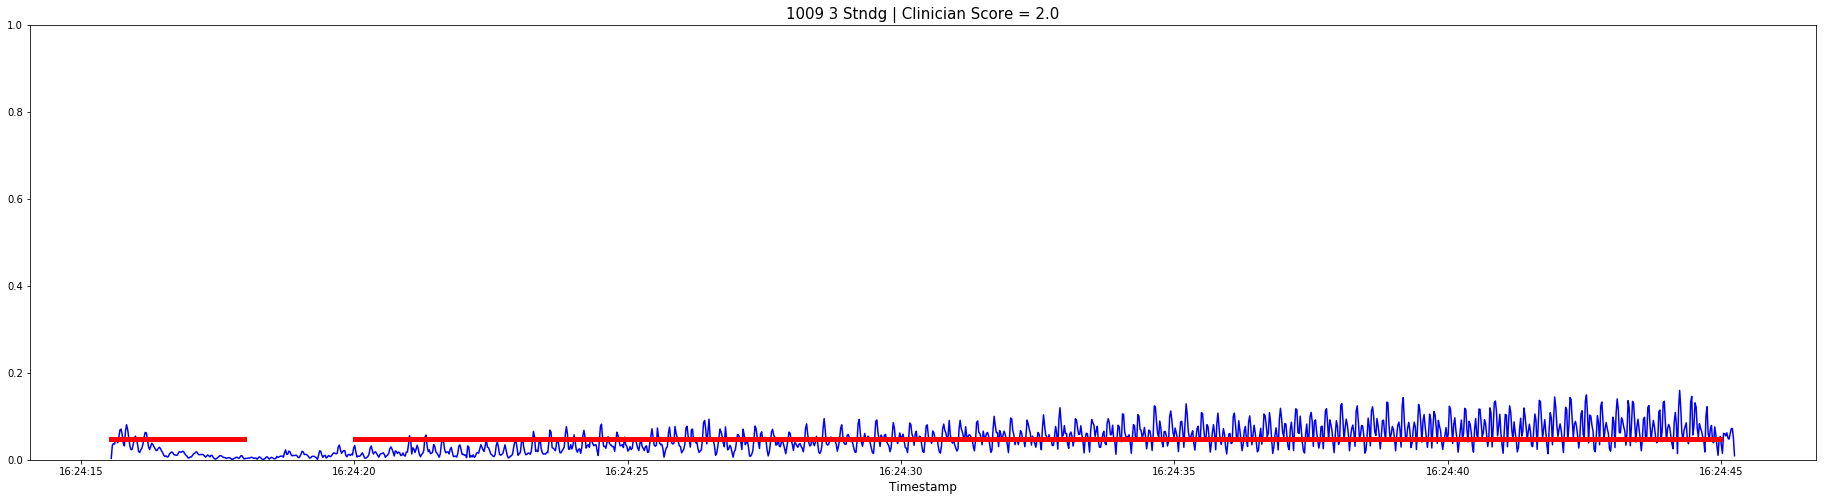

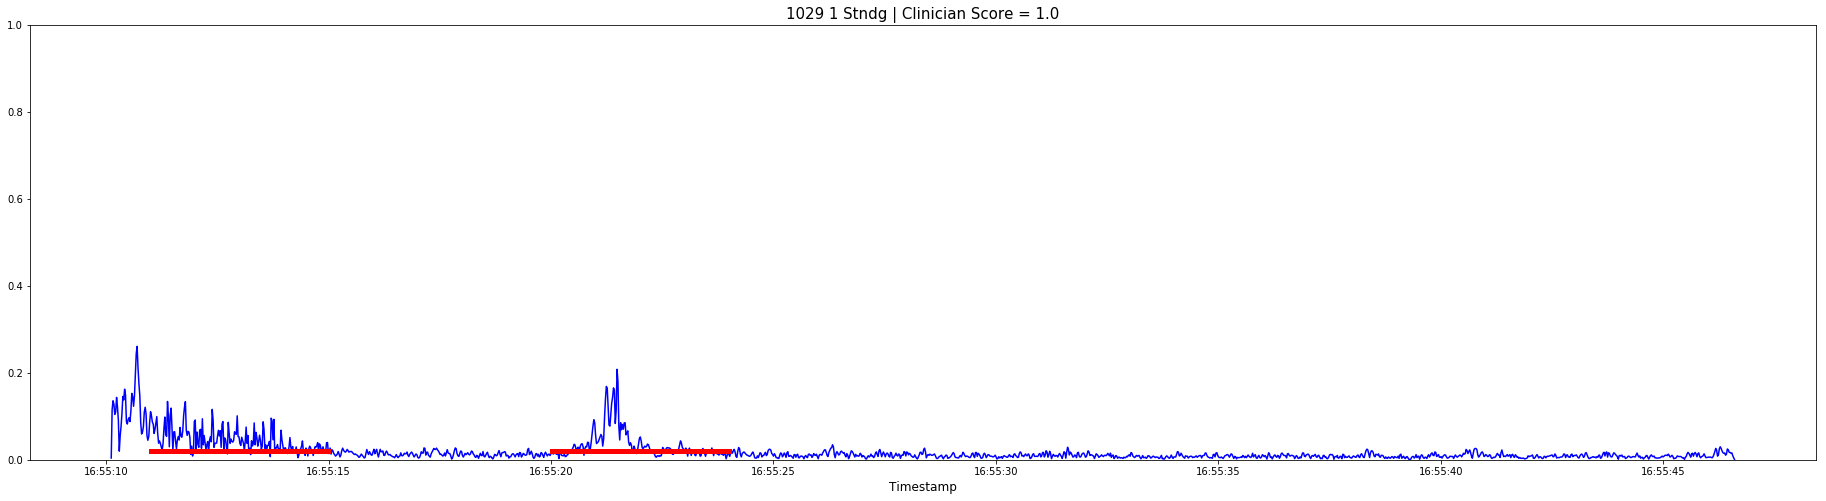

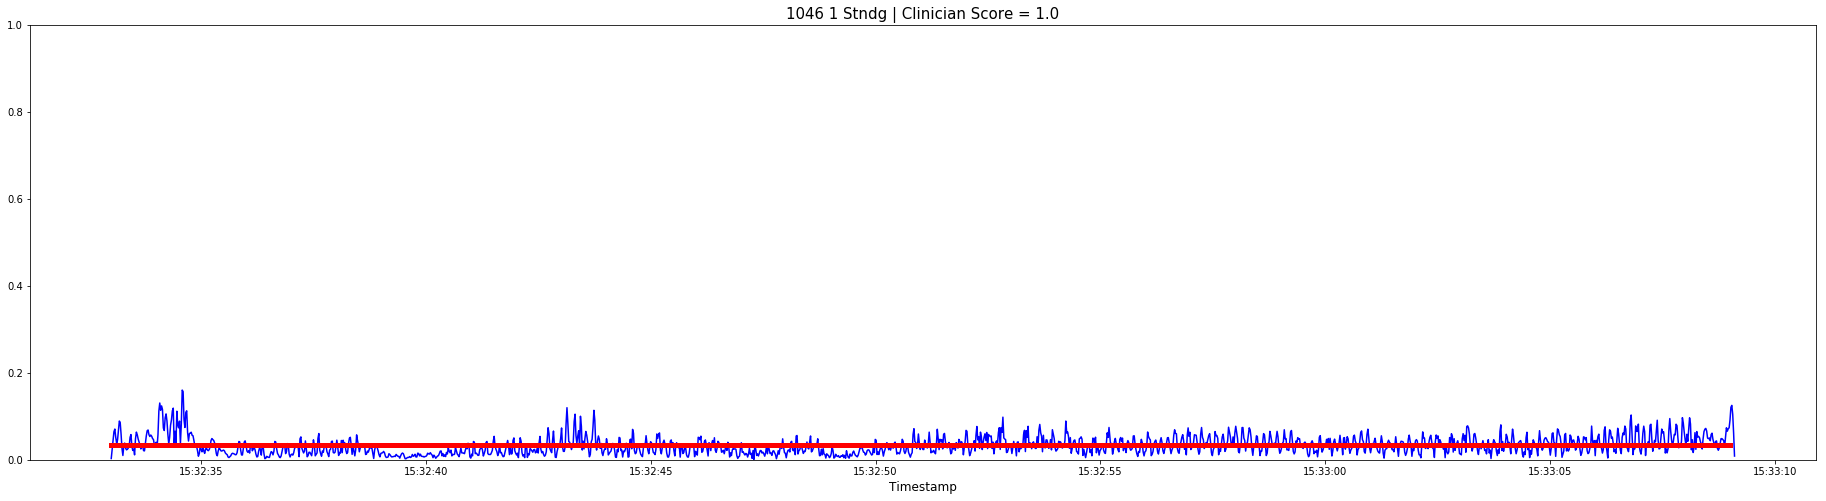

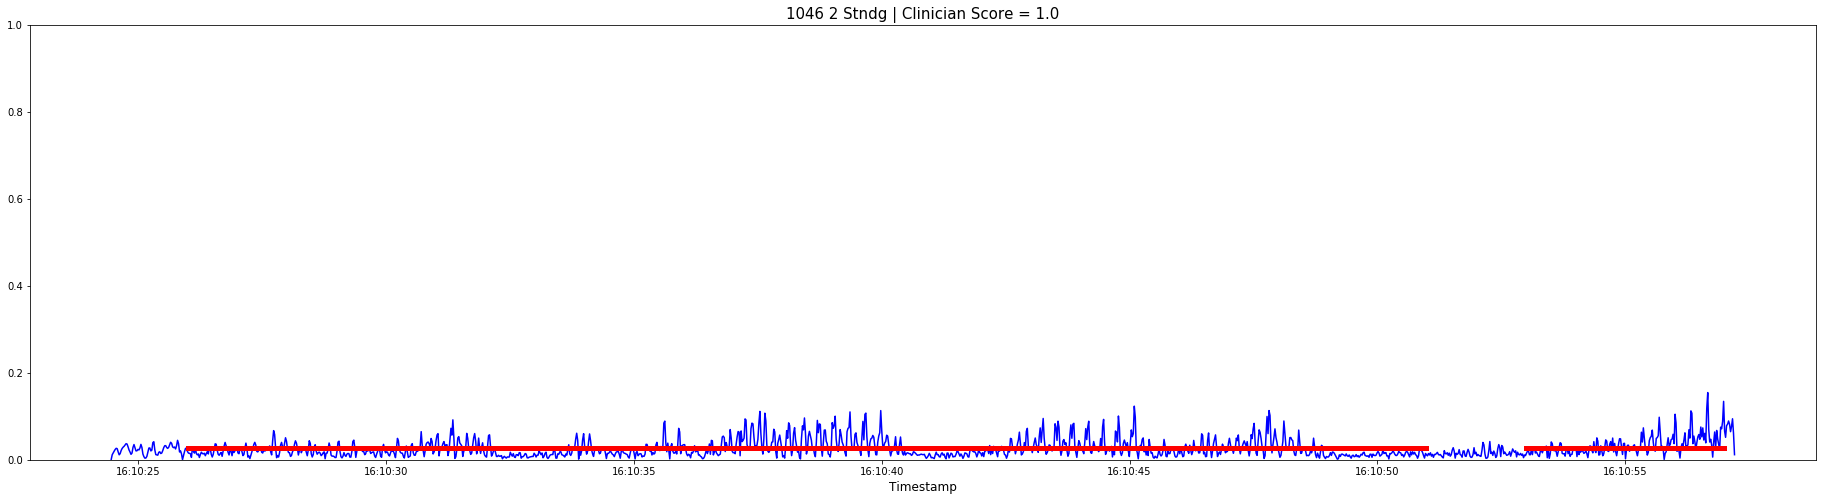

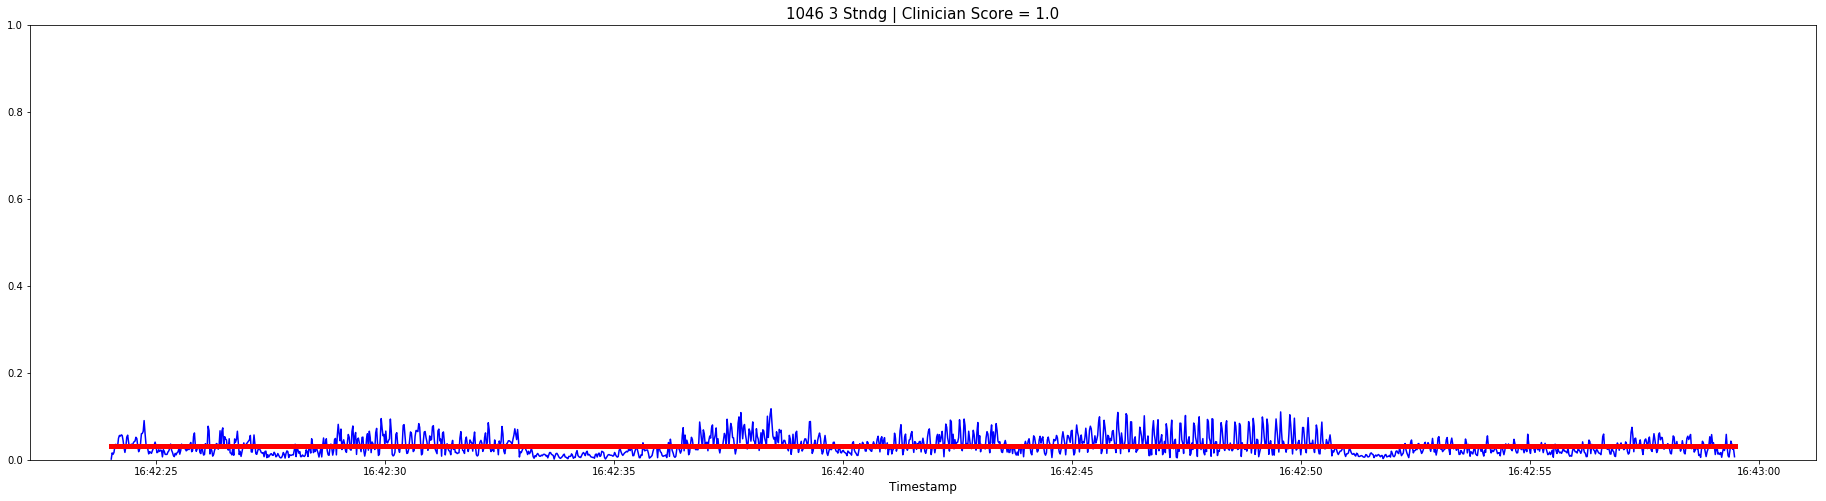

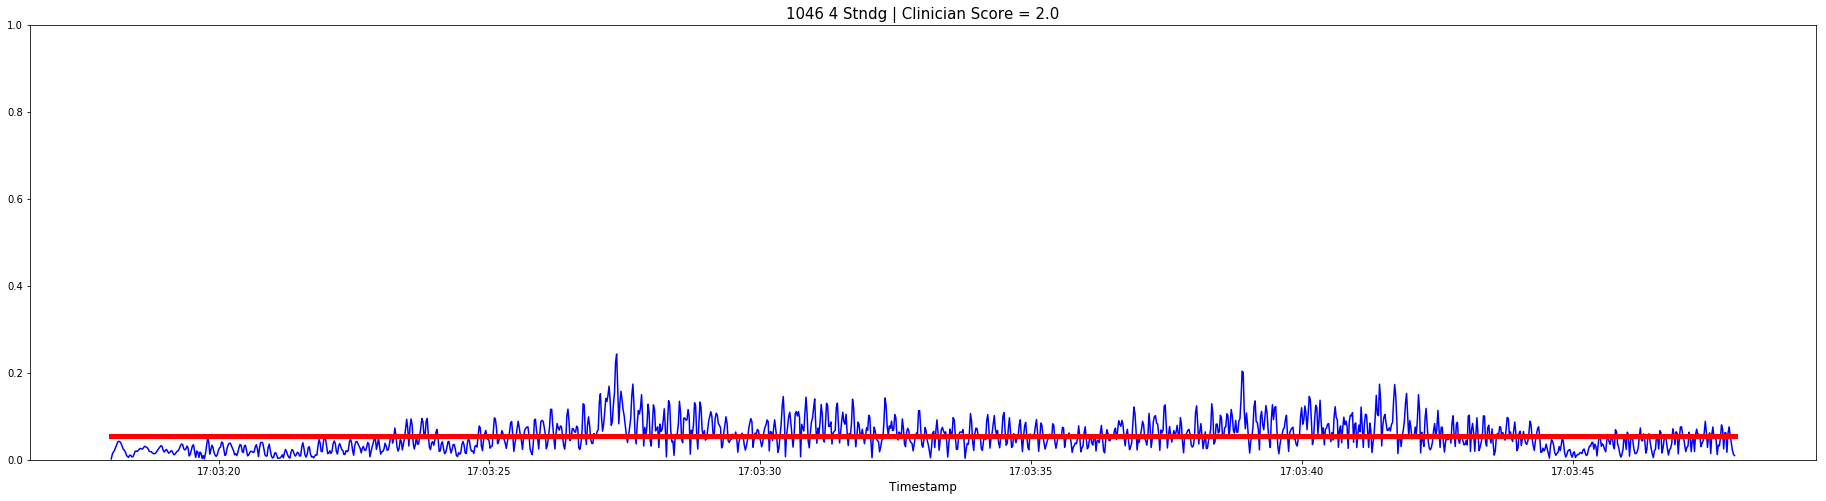

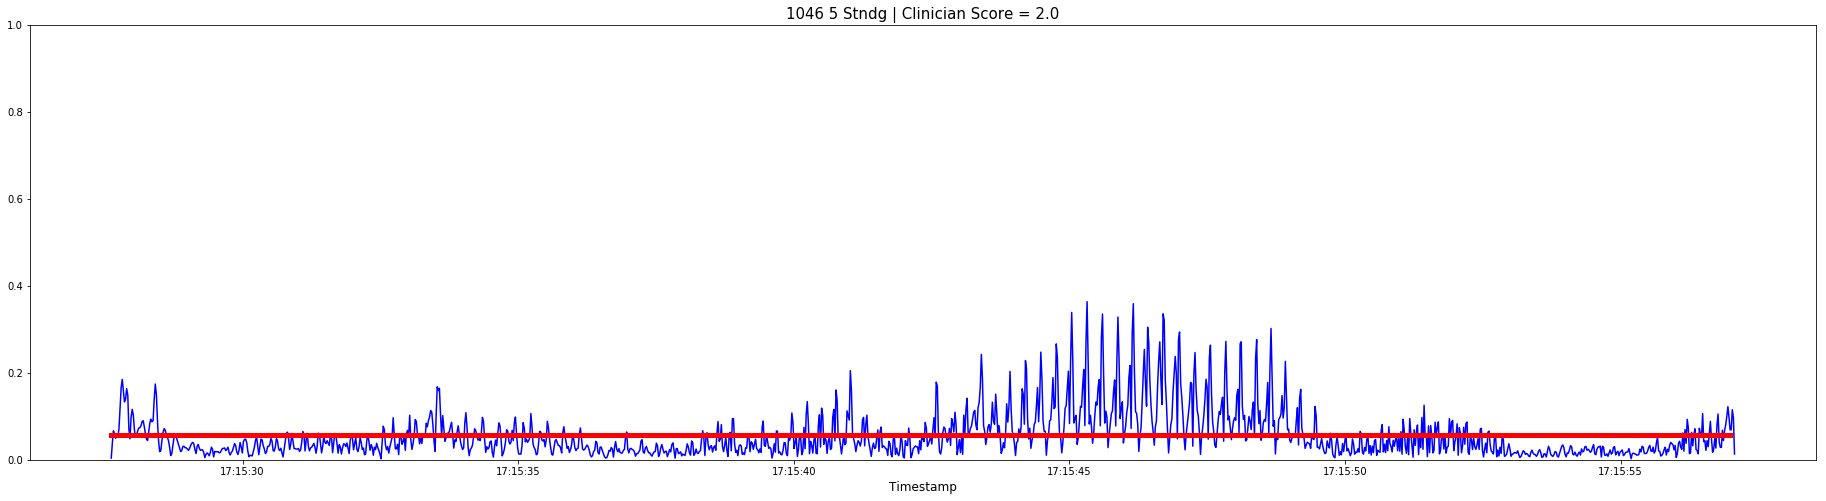

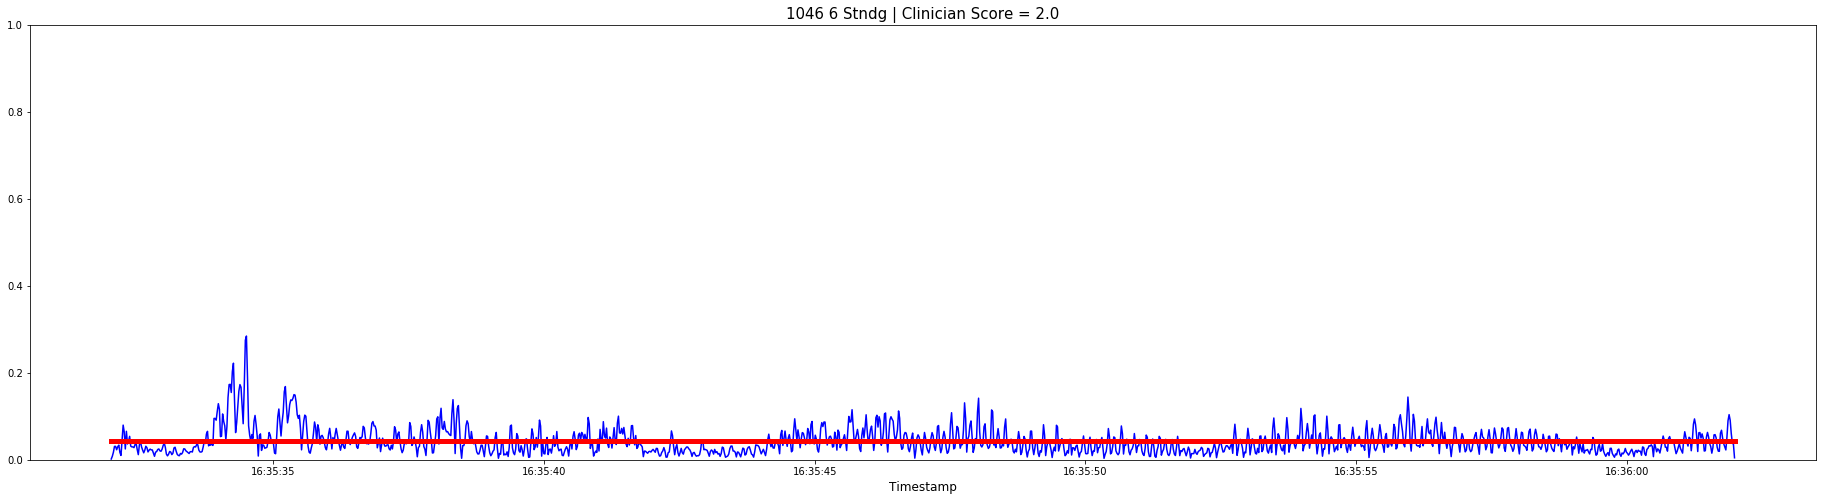

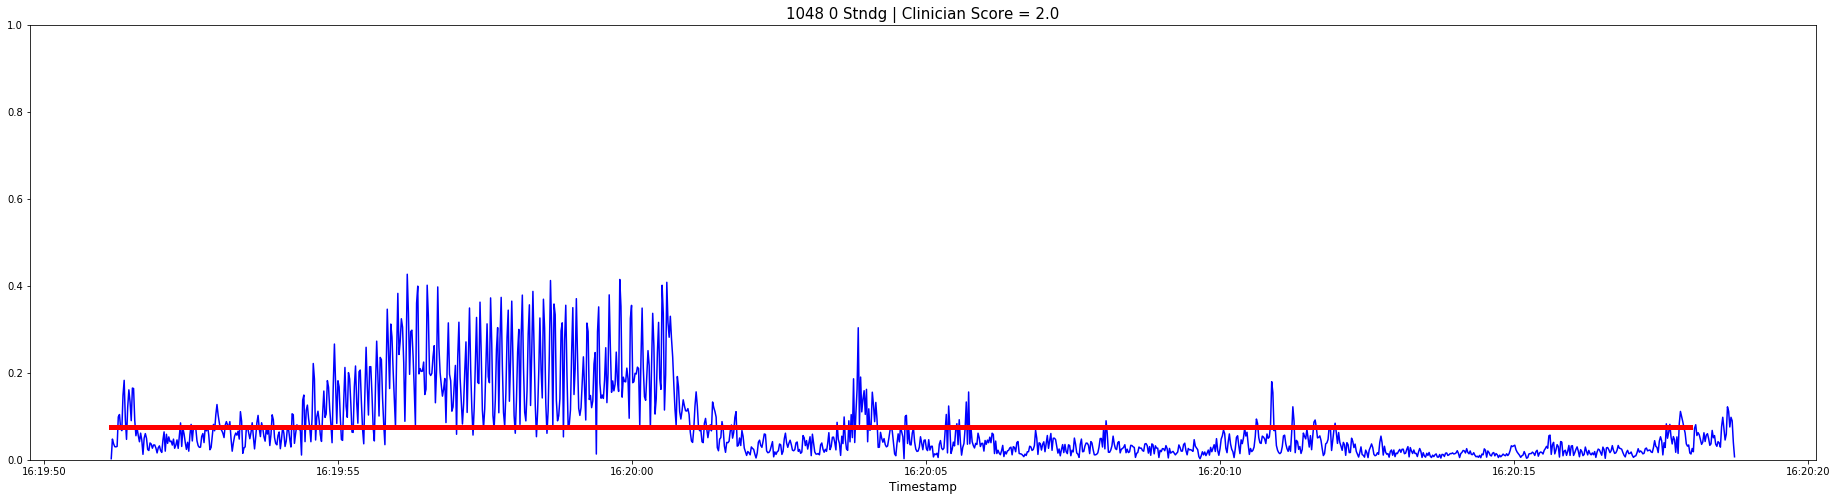

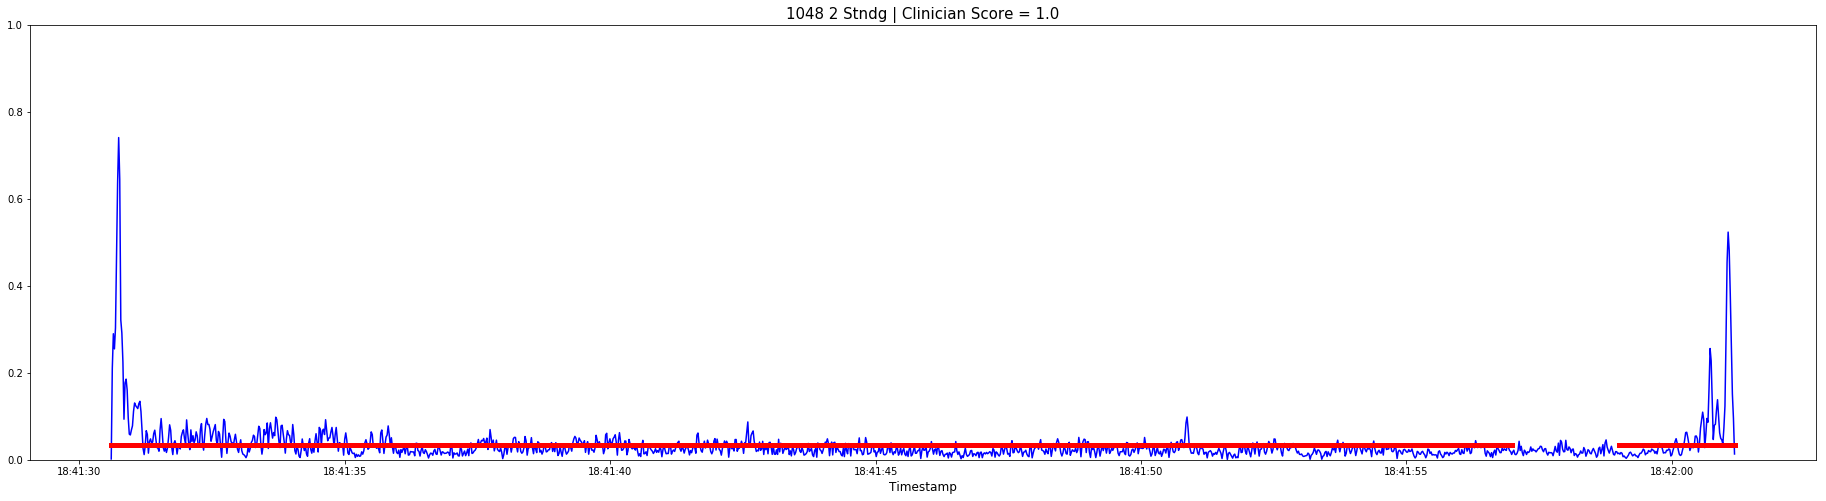

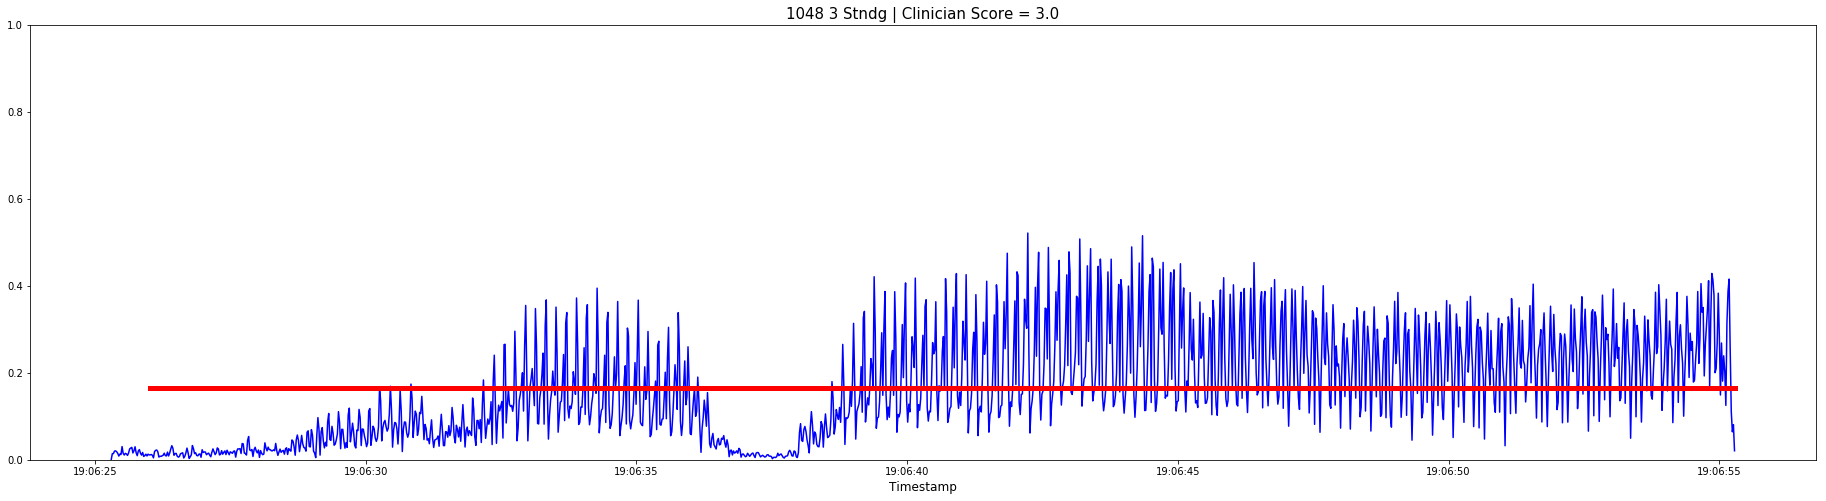

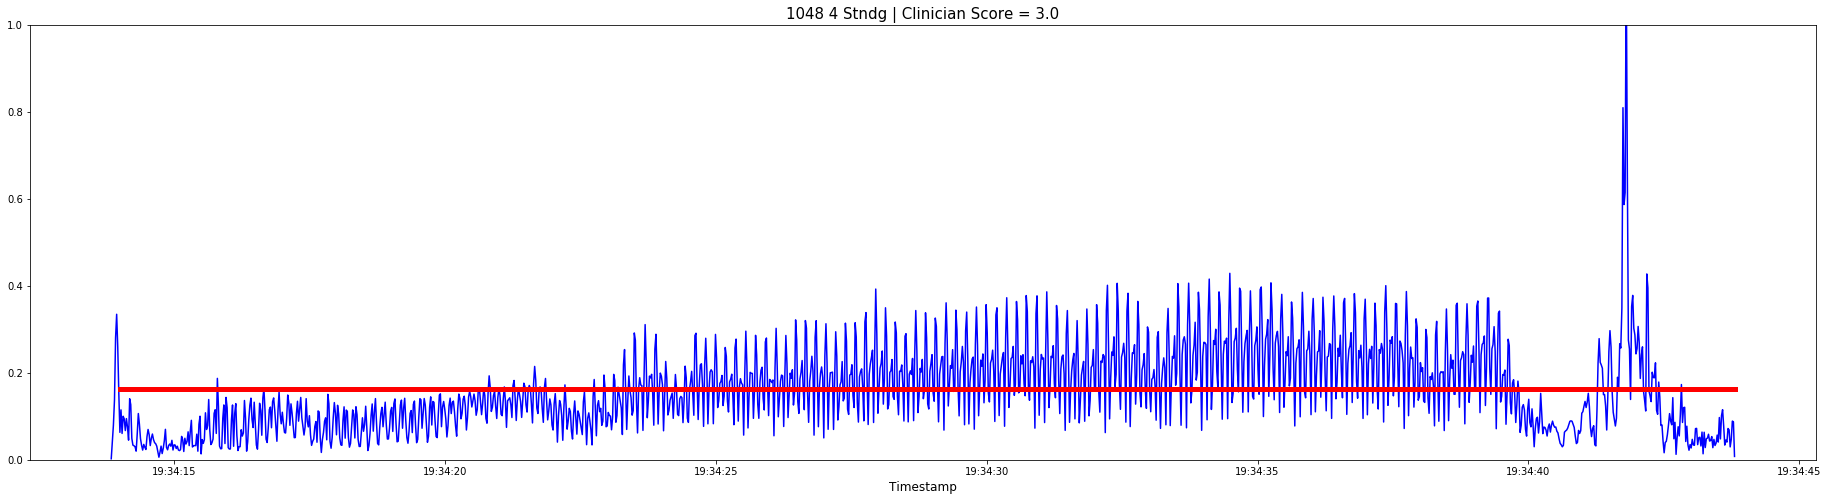

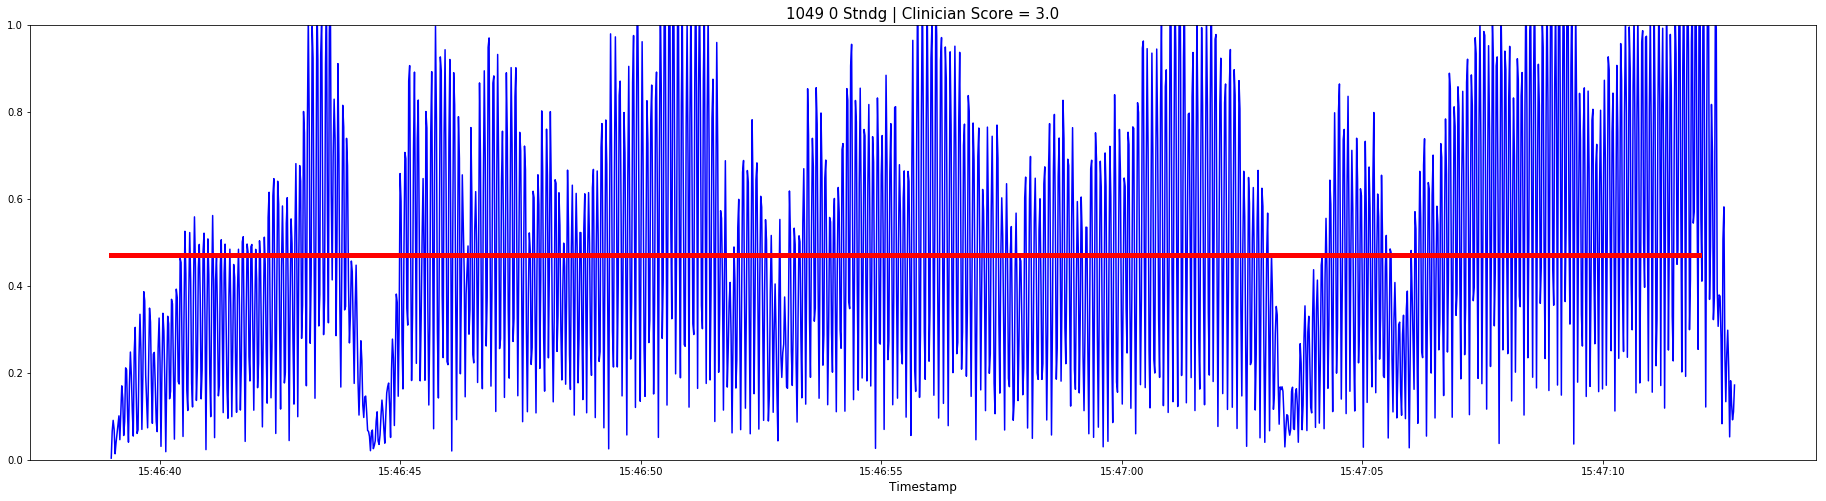

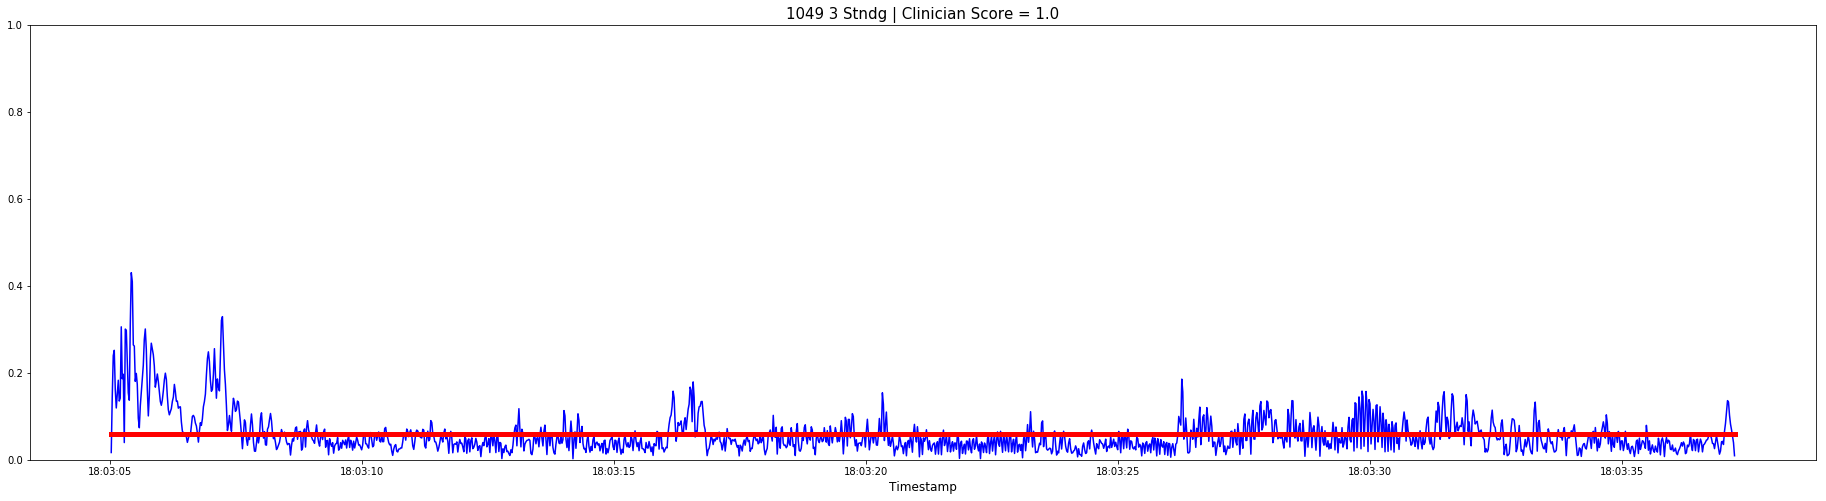

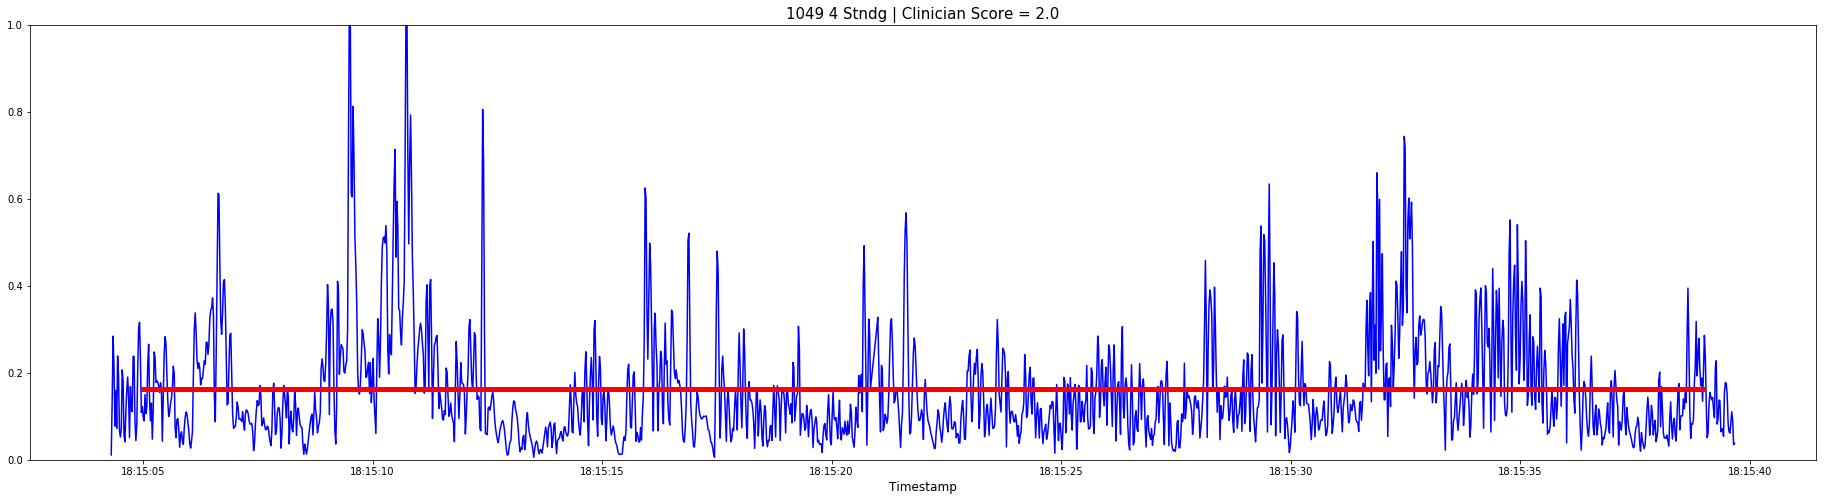

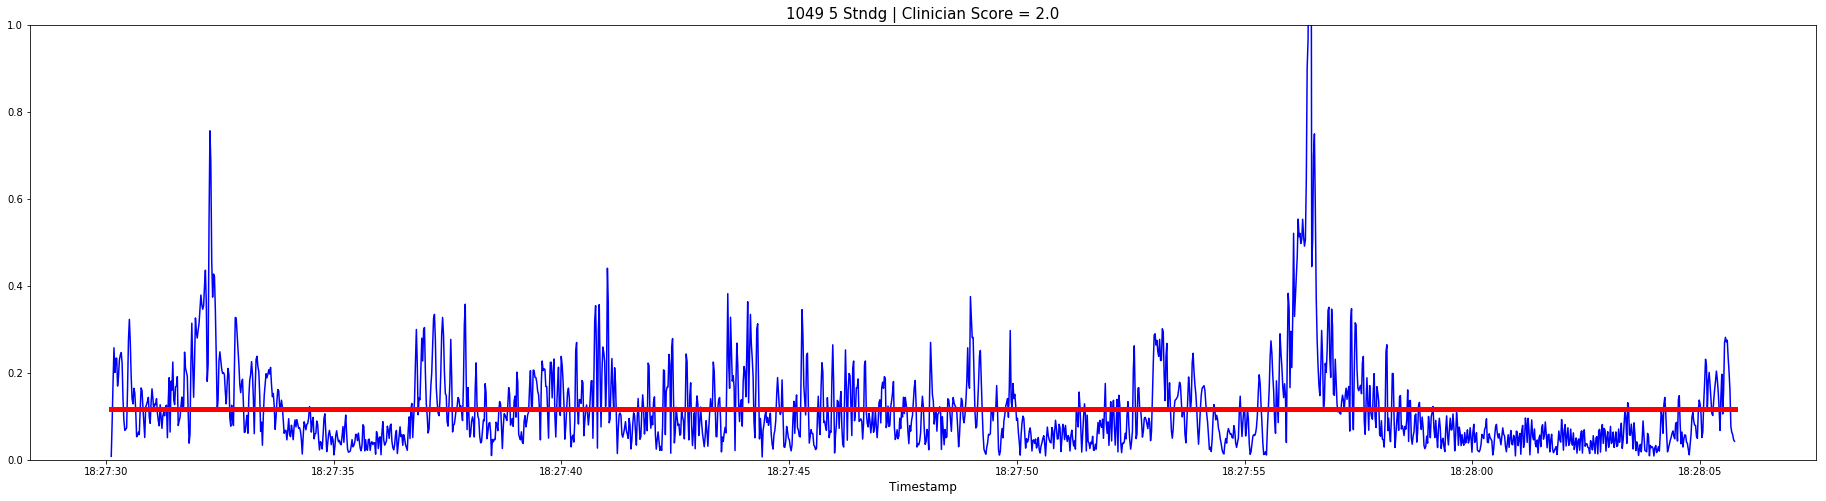

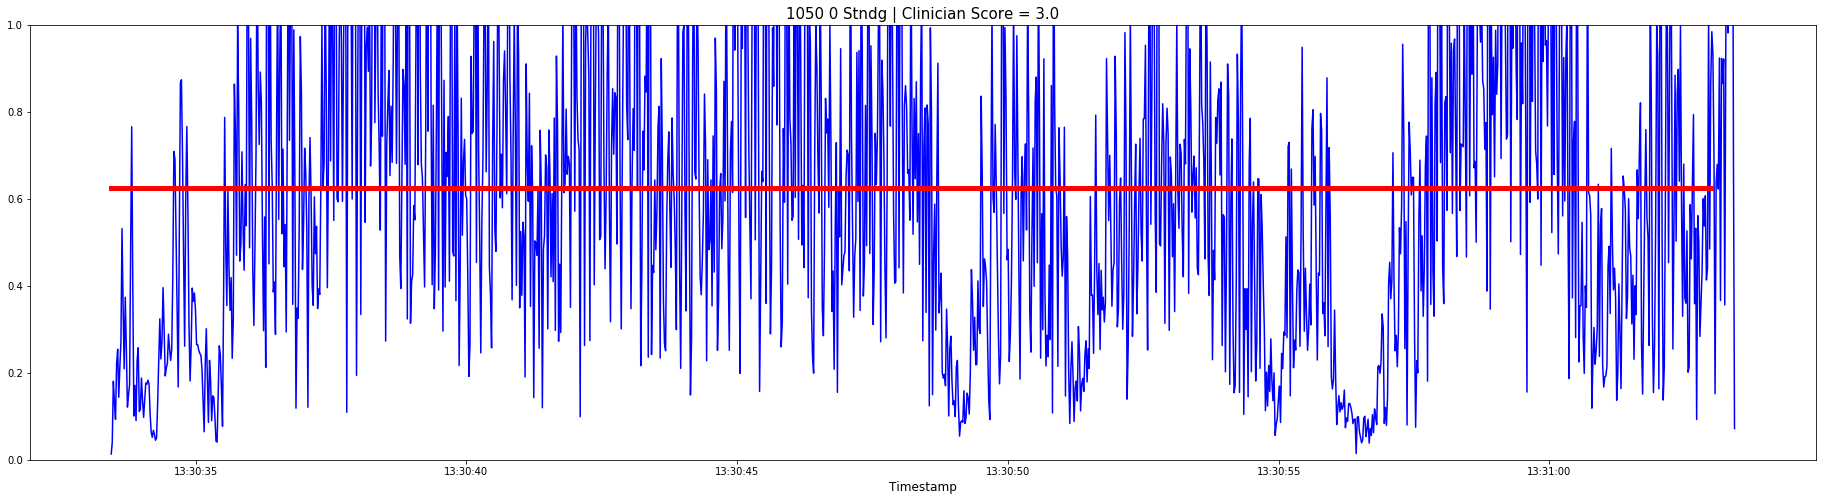

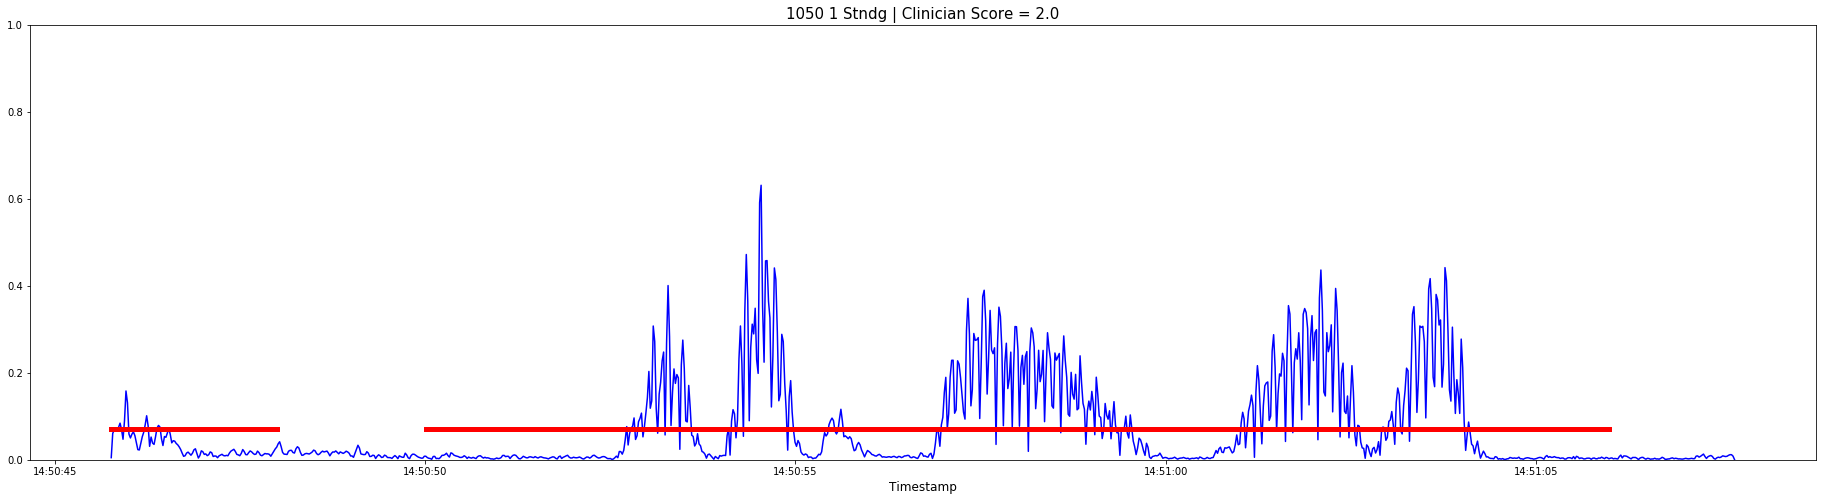

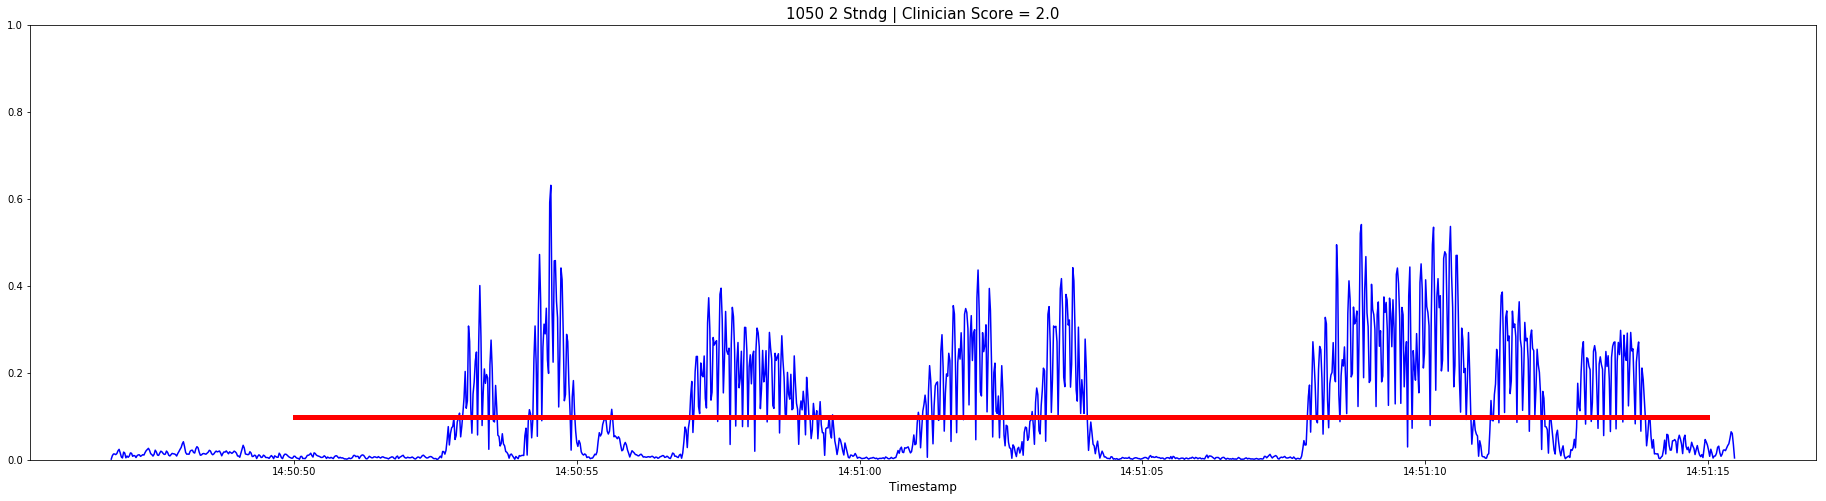

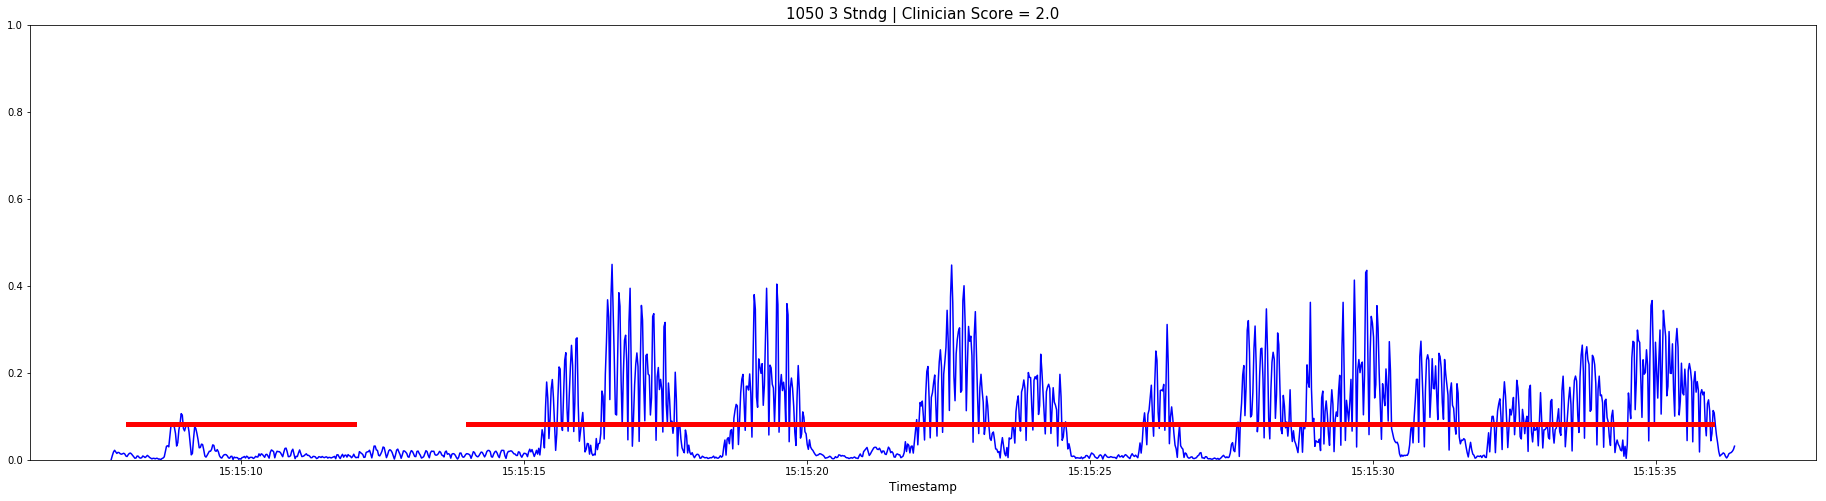

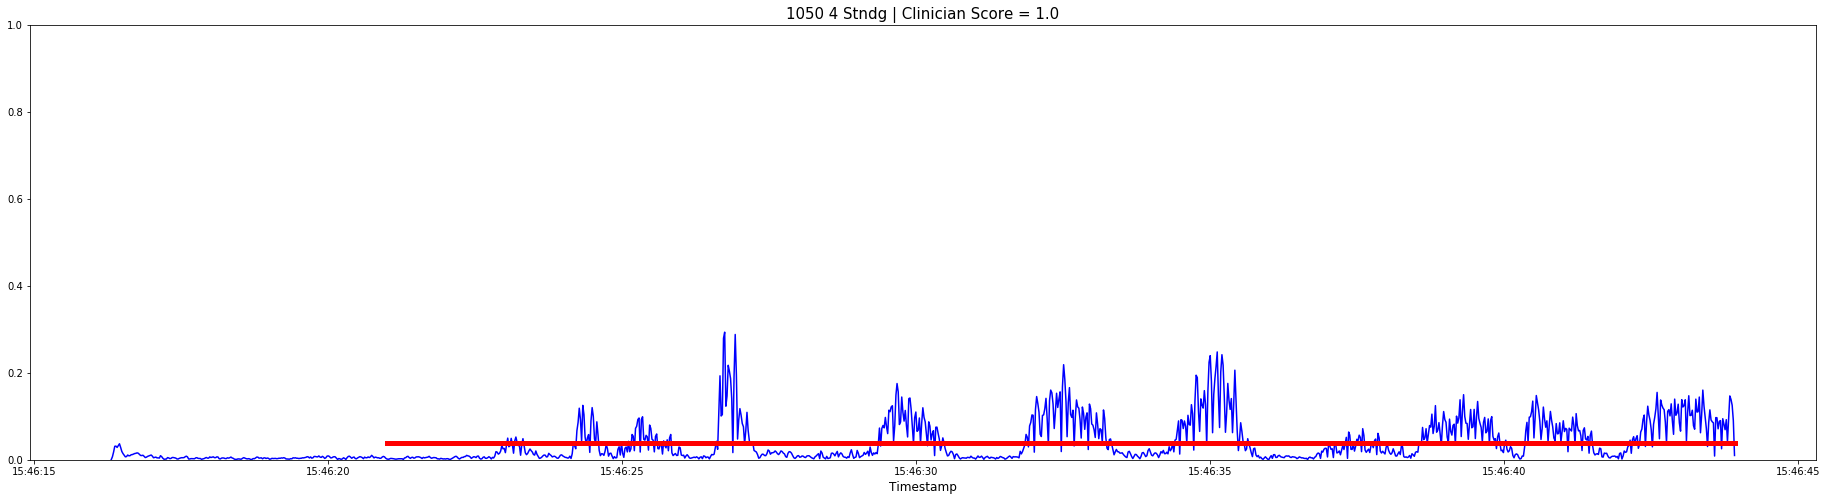

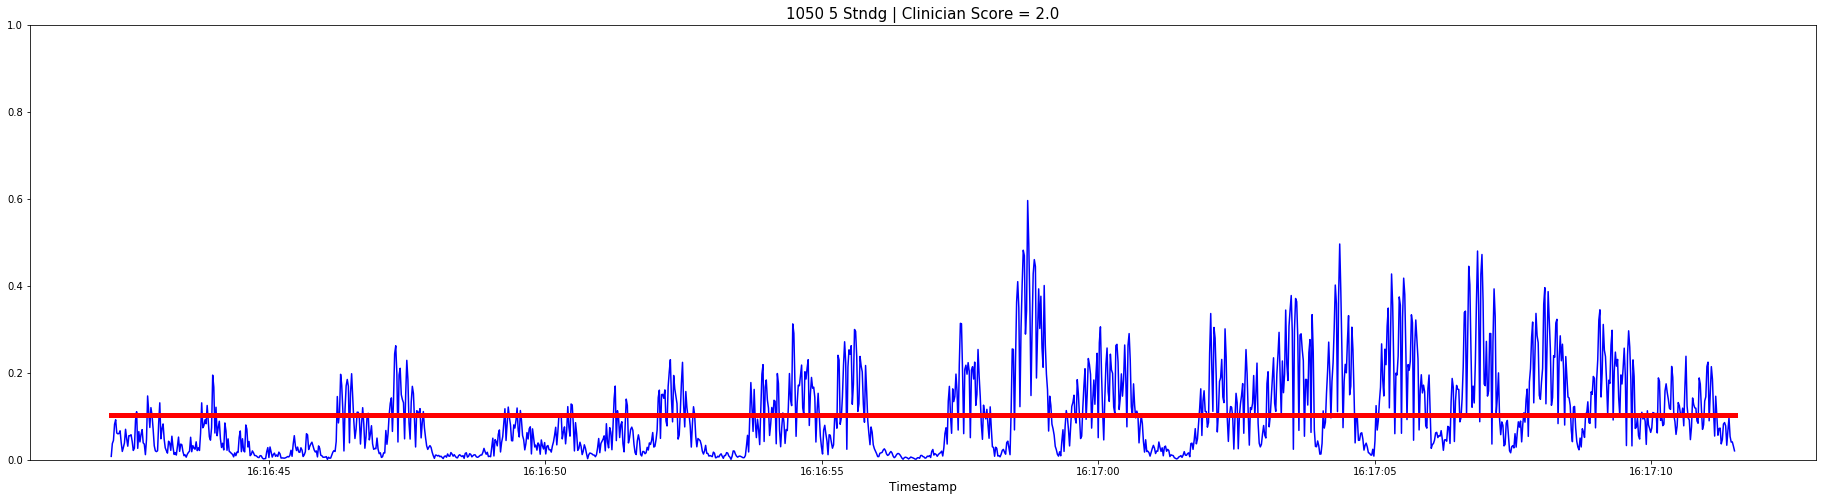

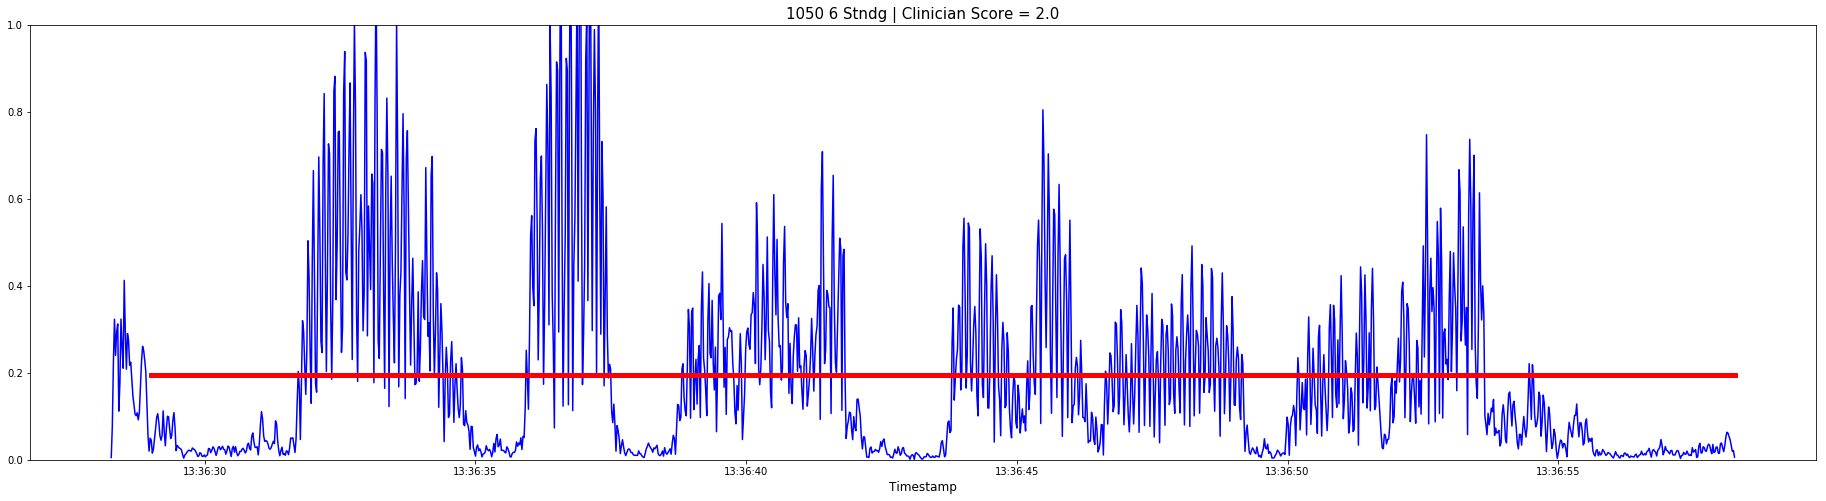

In [24]:
AnomalyClips = DataFeatures[(DataFeatures.Anomaly == 1) & (DataFeatures.Tremor > 0)]
for task in AnomalyClips.TaskAbb.unique():
    TAnomalyClips = AnomalyClips[AnomalyClips.TaskAbb == task]
    for sub in TAnomalyClips.SubjID.unique():
        TSAnomalyClips = TAnomalyClips[TAnomalyClips.SubjID == sub]
        for visit in TSAnomalyClips.Visit.unique():
            TSVAnomalyClips = TSAnomalyClips[TSAnomalyClips.Visit == visit]
            accdata = pd.read_csv(os.path.join(path, 'TaskAcc',
                                               str(int(sub)) + '_' + str(visit) + '_' + task + '.csv'), 
                                  parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
            accdata.columns = ['Timestamp', 'X', 'Y', 'Z']
            accdata = AccFilterX(accdata)
            accdata['Mag'] = np.sqrt((accdata.X)**2 + (accdata.Y)**2 + (accdata.Z)**2)
            SVClips = pd.DataFrame()
            plt.figure(figsize = (32, 8))
            plt.plot(accdata.Timestamp, accdata['Mag'].values, 'b')
            for clip in TSVAnomalyClips.iterrows():
                clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Anomaly Feature Clips', 
                                                   str(int(sub)) + '_' + str(visit) + '_' + 
                                                   clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                       parse_dates = ['Timestamp'])[['Timestamp']]
                plt.plot(clipacc.values, [np.mean(accdata['Mag'].values)] * len(clipacc.values), 'r', linewidth = 5)
            plt.xlabel('Timestamp', fontsize = 12)
            plt.ylim(0, 1)
            plt.title(str(int(sub)) + ' ' + str(visit) + ' ' + TSVAnomalyClips.TaskAbb.iloc[-1] + ' | '
                      'Clinician Score = ' + str(TSVAnomalyClips.Tremor.iloc[-1]), fontsize = 15)
            plt.show()

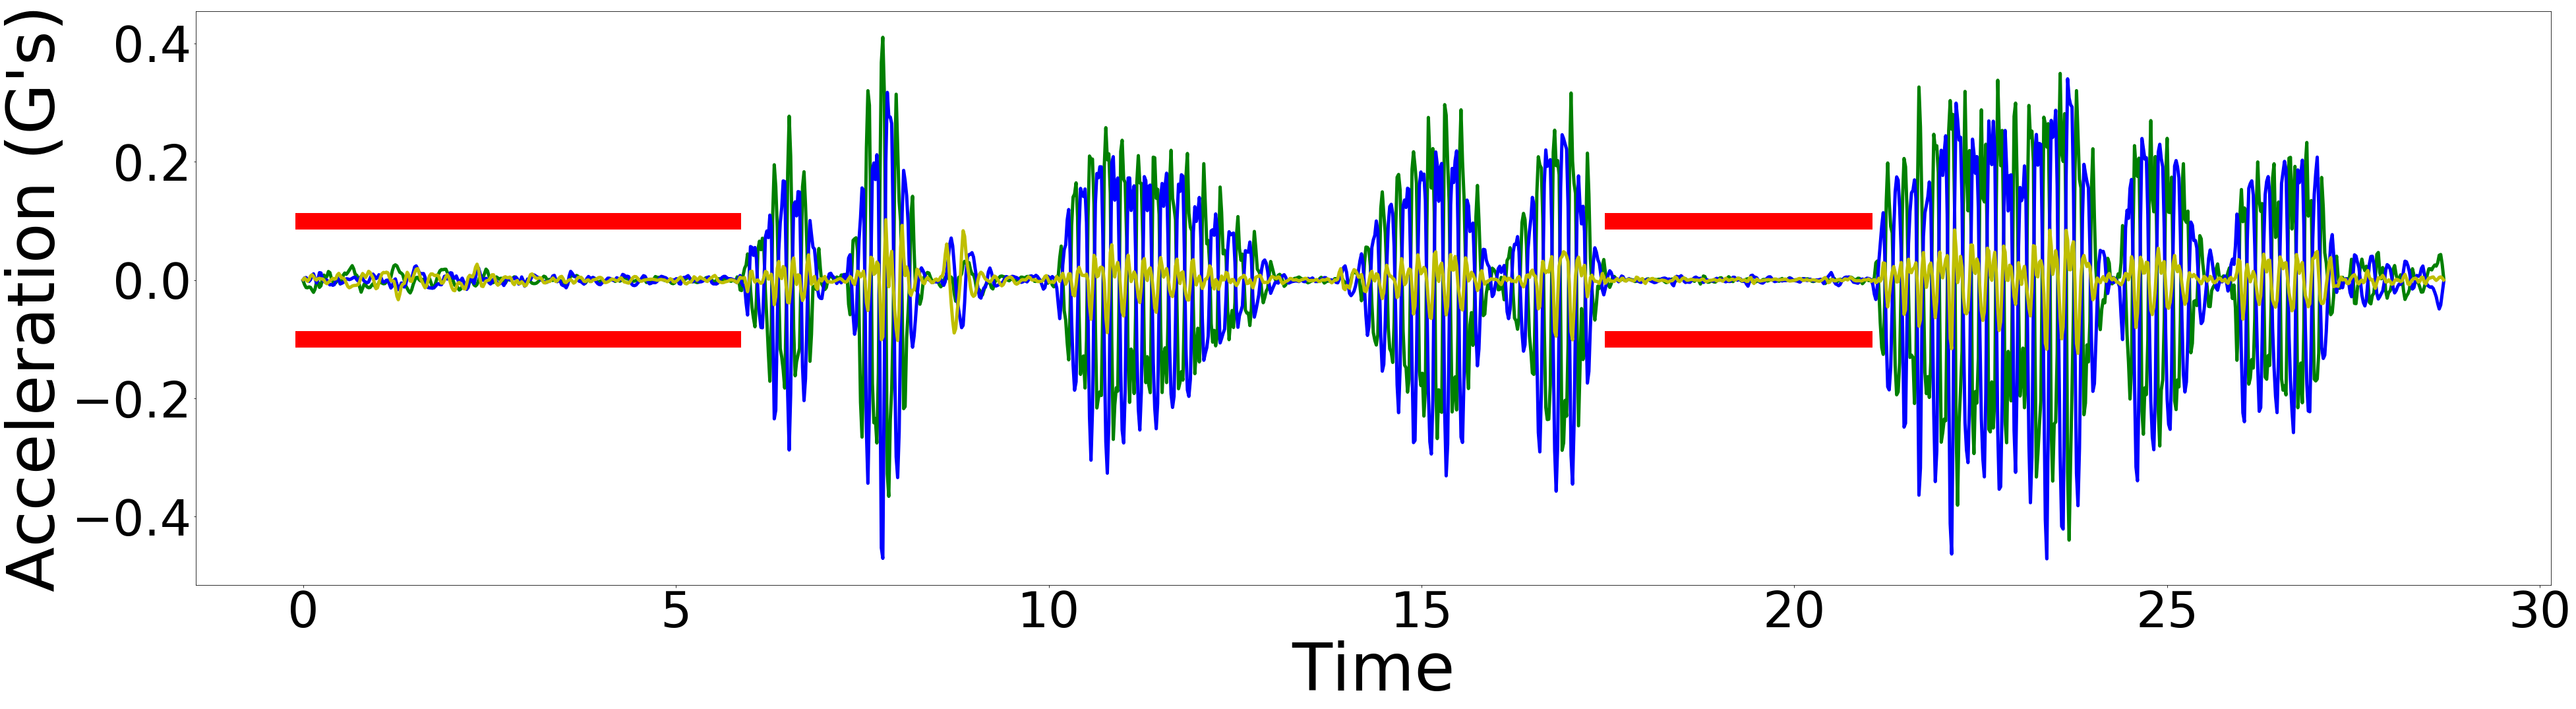

In [91]:
accdata = pd.read_csv(os.path.join(path, 'TaskAcc', '1050_2_Stndg.csv'), 
                      parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
accdata.columns = ['Timestamp', 'X', 'Y', 'Z']
accdata = AccFilterX(accdata)
accdata['ETime'] = (pd.to_datetime(accdata.Timestamp).values.astype(np.int64) // 10**6) / 1000
timerange = accdata.ETime - accdata.ETime[0]
# print(timerange)
plt.figure(figsize = (64, 16))
plt.plot(timerange, accdata.Y, 'g', timerange, accdata.Z, 'b', timerange, accdata.X, 'y', linewidth = 5)
plt.plot(timerange[:290], [-0.1] * 290, 'r', timerange[880:1050], [-0.1] * 170, 'r', linewidth = 25)
plt.plot(timerange[:290], [0.1] * 290, 'r', timerange[880:1050], [0.1] * 170, 'r', linewidth = 25)
plt.xlabel('Time', fontsize = 100)
plt.ylabel('Acceleration (G\'s)', fontsize = 100)
plt.xticks(fontsize = 75)
plt.yticks(fontsize = 75)
# plt.title('Task: Standing | Clinician Tremor Score: 2', fontsize = 125)
plt.show()

In [58]:
accdata

Timestamp         X         Y         Z
0    2017-09-06 14:50:46.762  0.000532 -0.001463  0.000173
1    2017-09-06 14:50:46.782  0.003324 -0.008203  0.003534
2    2017-09-06 14:50:46.802  0.000541 -0.012808  0.004101
3    2017-09-06 14:50:46.822 -0.002227 -0.013101  0.000650
4    2017-09-06 14:50:46.841  0.001011 -0.011697 -0.002388
5    2017-09-06 14:50:46.861  0.006676 -0.012618  0.000555
6    2017-09-06 14:50:46.881  0.008737 -0.016917  0.007855
7    2017-09-06 14:50:46.901  0.005945 -0.020855  0.010365
8    2017-09-06 14:50:46.921  0.001426 -0.015644  0.002527
9    2017-09-06 14:50:46.941 -0.000047 -0.004111 -0.005110
10   2017-09-06 14:50:46.961  0.001943 -0.003570  0.000914
11   2017-09-06 14:50:46.981  0.002776 -0.012480  0.012340
12   2017-09-06 14:50:47.001  0.001830 -0.009756  0.011829
13   2017-09-06 14:50:47.021  0.001766  0.003776  0.001857
14   2017-09-06 14:50:47.041  0.000030  0.008214 -0.002826
15   2017-09-06 14:50:47.061 -0.004540  0.003546 -0.000086
16   2017-09-06 14:50:47.081 -0.006207  0.006057 -0.000019
17   2017-09-06 14:50:47.101 -0.003920  0.014283 -0.005404
18   2017-09-06 14:50:47.121 -0.001761  0.012387 -0.008270
19   2017-09-06 14:50:47.141  0.000807  0.002272 -0.007559
20   2017-09-06 14:50:47.160  0.002807 -0.002982 -0.008991
21   2017-09-06 14:50:47.180  0.001289 -0.004703 -0.007885
22   2017-09-06 14:50:47.200  0.002097 -0.004666  0.000260
23   2017-09-06 14:50:47.220  0.008480  0.000708  0.004413
24   2017-09-06 14:50:47.240  0.011177  0.001032 -0.001222
25   2017-09-06 14:50:47.260  0.006993 -0.006770 -0.006149
26   2017-09-06 14:50:47.280  0.003678 -0.004208 -0.005650
27   2017-09-06 14:50:47.300  0.003016  0.008276 -0.004131
28   2017-09-06 14:50:47.320  0.000487  0.011733 -0.001374
29   2017-09-06 14:50:47.340 -0.004979  0.009510  0.001953
...                      ...       ...       ...       ...
1410 2017-09-06 14:51:14.894 -0.002835  0.008685 -0.007492
1411 2017-09-06 14:51:14.914 -0.001533  0.004324 -0.002295
1412 2017-09-06 14:51:14.934  0.005467 -0.018478  0.016689
1413 2017-09-06 14:51:14.953  0.009343 -0.032839  0.031760
1414 2017-09-06 14:51:14.973  0.002532 -0.027014  0.030560
1415 2017-09-06 14:51:14.993 -0.006785 -0.023126  0.023620
1416 2017-09-06 14:51:15.013 -0.007840 -0.015995  0.013504
1417 2017-09-06 14:51:15.033 -0.002860  0.006714 -0.003149
1418 2017-09-06 14:51:15.053  0.000654  0.018915 -0.015259
1419 2017-09-06 14:51:15.073  0.002026  0.008255 -0.012739
1420 2017-09-06 14:51:15.093  0.003278 -0.002235 -0.000709
1421 2017-09-06 14:51:15.113  0.001430 -0.003328  0.007639
1422 2017-09-06 14:51:15.133 -0.003392 -0.005183  0.006353
1423 2017-09-06 14:51:15.153 -0.002405 -0.012630  0.007745
1424 2017-09-06 14:51:15.173  0.004597 -0.020549  0.019492
1425 2017-09-06 14:51:15.193  0.004421 -0.020187  0.023592
1426 2017-09-06 14:51:15.213 -0.004172 -0.011849  0.009864
1427 2017-09-06 14:51:15.233 -0.006647 -0.002014 -0.004121
1428 2017-09-06 14:51:15.253 -0.000431  0.009407 -0.008473
1429 2017-09-06 14:51:15.273  0.003369  0.018872 -0.010834
1430 2017-09-06 14:51:15.292  0.003192  0.018926 -0.012219
1431 2017-09-06 14:51:15.312  0.004616  0.016986 -0.011528
1432 2017-09-06 14:51:15.332  0.005133  0.021914 -0.014401
1433 2017-09-06 14:51:15.352  0.001679  0.025251 -0.020841
1434 2017-09-06 14:51:15.372 -0.000718  0.023465 -0.028414
1435 2017-09-06 14:51:15.392  0.001355  0.029042 -0.039853
1436 2017-09-06 14:51:15.412  0.004460  0.041725 -0.048916
1437 2017-09-06 14:51:15.432  0.005187  0.043005 -0.042331
1438 2017-09-06 14:51:15.452  0.003323  0.026584 -0.022973
1439 2017-09-06 14:51:15.472 -0.000067  0.002850 -0.003208

[1440 rows x 4 columns]

In [25]:
print(len(DataFeatures[DataFeatures.Anomaly == 1]))
print(len(DataFeatures[DataFeatures.Anomaly == 0]))

1861
3577


In [26]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'))
n = 0
i = 0
for task in DataFeatures.TaskAbb.unique():
    TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
    for subj in TDataFeatures.SubjID.unique():
        TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
        for visit in TSDataFeatures.Visit.unique():
            TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
            if all(TSVDataFeatures.Tremor > 0):
                n += 1
            if all(TSVDataFeatures.Tremor > 0) and all(TSVDataFeatures.Anomaly == 0):
                i += 1
                print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
                      str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1] + 
                      ' - ' + str(i))
print(n)
print('--------------------------------------------------------------------------------------')
n = 0
for task in DataFeatures.TaskAbb.unique():
    TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
    for subj in TDataFeatures.SubjID.unique():
        TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
        for visit in TSDataFeatures.Visit.unique():
            TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
            if all(TSVDataFeatures.Tremor == 0):    
                n += 1
            if all(TSVDataFeatures.Tremor == 0) and all(TSVDataFeatures.Anomaly == 1):
                i += 1
                print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
                      str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1] + 
                      ' - ' + str(i))
print(n)

1003_4_Sitng - 1
1005_2_Sitng - 2
1005_3_Sitng - 3
1046_5_Sitng - 4
1050_1_Sitng - 5
1009_6_Stndg - 6
58
--------------------------------------------------------------------------------------
1003_1_Sitng - 7
1003_1_Stndg - 8
1003_2_Stndg - 9
1024_3_Stndg - 10
1024_4_Stndg - 11
1024_5_Stndg - 12
1048_1_Stndg - 13
1049_2_Stndg - 14
213


In [100]:
DataFeatures[(DataFeatures.SubjID == 1046) & 
             (DataFeatures.Visit == 5) & 
             (DataFeatures.TaskAbb == 'Stndg')]

SubjID  Visit TaskAbb  Clip  Tremor      RMSX      RMSY      RMSZ  \
4370    1046      5   Stndg     0     2.0  0.002716  0.003048  0.004527   
4371    1046      5   Stndg     1     2.0  0.000701  0.001842  0.002193   
4372    1046      5   Stndg     2     2.0  0.000595  0.002725  0.002250   
4373    1046      5   Stndg     3     2.0  0.002843  0.003200  0.002521   
4374    1046      5   Stndg     4     2.0  0.002912  0.003279  0.002950   
4375    1046      5   Stndg     5     2.0  0.000502  0.001873  0.002154   
4376    1046      5   Stndg     6     2.0  0.000513  0.002157  0.001761   
4377    1046      5   Stndg     7     2.0  0.000931  0.003549  0.002329   
4378    1046      5   Stndg     8     2.0  0.000895  0.003831  0.002609   
4379    1046      5   Stndg     9     2.0  0.002826  0.004671  0.003252   
4380    1046      5   Stndg    10     2.0  0.002854  0.006575  0.004930   
4381    1046      5   Stndg    11     2.0  0.002269  0.010164  0.009379   
4382    1046      5   Stndg    12     2.0  0.002313  0.009494  0.009264   
4383    1046      5   Stndg    13     2.0  0.001391  0.007626  0.006934   
4384    1046      5   Stndg    14     2.0  0.001112  0.005611  0.004491   
4385    1046      5   Stndg    15     2.0  0.000737  0.003510  0.001824   
4386    1046      5   Stndg    16     2.0  0.000659  0.003295  0.001752   
4387    1046      5   Stndg    17     2.0  0.000573  0.001230  0.001109   
4388    1046      5   Stndg    18     2.0  0.000914  0.002367  0.001453   

        rangeX    rangeY  ...     Sen_Y     Sen_Z   RMS_mag  range_mag  \
4370  0.179523  0.242003  ...  0.840078  0.574914  0.002967   0.189937   
4371  0.042773  0.112855  ...  1.573235  1.103689  0.000940   0.058164   
4372  0.042211  0.211953  ...  1.443924  1.286038  0.001030   0.075062   
4373  0.267950  0.212479  ...  1.871802  1.406579  0.003083   0.259343   
4374  0.264401  0.212428  ...  1.805183  1.343735  0.003248   0.253746   
4375  0.031555  0.157380  ...  1.368276  1.192923  0.000986   0.075268   
4376  0.032033  0.164949  ...  1.386294  1.114068  0.001016   0.066039   
4377  0.069376  0.272334  ...  1.807264  1.680334  0.001534   0.090233   
4378  0.066481  0.287896  ...  1.530544  1.290646  0.001748   0.127342   
4379  0.269439  0.333581  ...  1.472862  1.329568  0.003552   0.313149   
4380  0.267826  0.461382  ...  1.479820  1.184337  0.003850   0.313257   
4381  0.161700  0.653897  ...  0.861284  0.736632  0.005347   0.334994   
4382  0.143315  0.542600  ...  0.921079  0.848987  0.004808   0.211535   
4383  0.084914  0.504109  ...  1.148821  0.833376  0.003648   0.233930   
4384  0.081043  0.433013  ...  1.205858  1.002648  0.002587   0.189066   
4385  0.043175  0.227419  ...  1.658228  1.711221  0.001376   0.088963   
4386  0.041974  0.281487  ...  1.085833  1.332451  0.001250   0.090877   
4387  0.039462  0.092689  ...  1.841240  1.525021  0.000714   0.061385   
4388  0.090163  0.183293  ...  1.489637  1.898904  0.001211   0.106345   

      mean_mag   var_mag  skew_mag  kurt_mag   Sen_mag  Anomaly  
4370  0.004514  0.032192  0.677958  1.407556  0.749237      1.0  
4371  0.000161  0.011513 -0.076144 -0.240457  1.786696      1.0  
4372  0.000103  0.012620 -0.288256  0.568554  1.833871      1.0  
4373 -0.000316  0.037755  0.301676  3.398782  0.919486      1.0  
4374  0.003199  0.039647  0.375688  2.253483  1.038458      1.0  
4375 -0.000264  0.012067  0.681971  0.984154  1.529103      1.0  
4376  0.000652  0.012420  0.387680  0.345618  1.342375      1.0  
4377 -0.000922  0.018762  0.755970  0.278521  1.939940      1.0  
4378 -0.000472  0.021400  1.185272  1.995998  1.716336      1.0  
4379 -0.001989  0.043453  1.283523  4.691502  1.257264      1.0  
4380  0.000391  0.047156  1.127671  2.737360  1.261471      1.0  
4381 -0.003855  0.065379  0.385073  0.276704  0.899354      1.0  
4382  0.000625  0.058888  0.913095 -0.367999  0.892068      1.0  
4383 -0.005628  0.044327  0.800994  0.979827  0.773190      1.0  
4384  0.001549  0.031645  1.831811

# Classify Clips as Anomaly

In [73]:
def CatchAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100    
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

<Figure size 864x720 with 0 Axes>

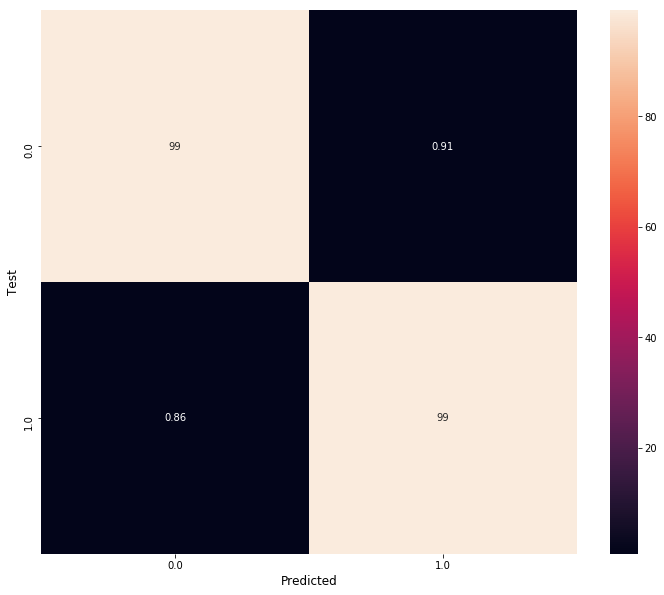

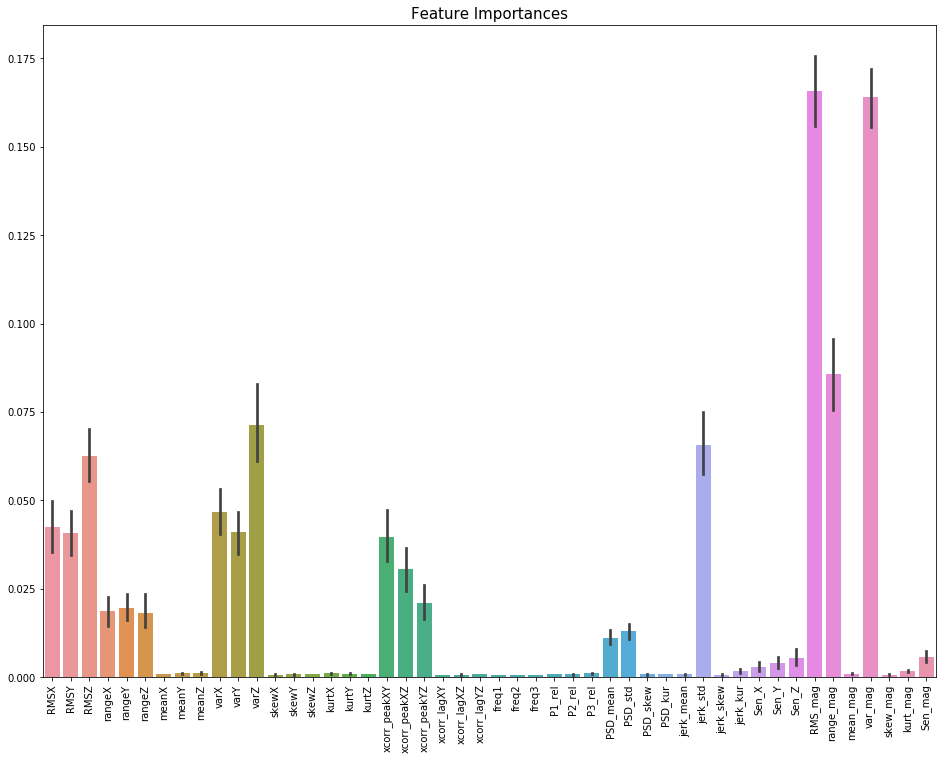

In [74]:
model, FeatImp, TestPred, DataFeatures = CatchAnomalyModel('Anomaly', 
                                                             ['Stndg', 'Sitng'], 
                                                             [], [])

# Classify Anomaly Clips as Symptomatic

In [98]:
def DiscernAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
#     DataFeatures = DataFeatures[DataFeatures.SubjID != 1020]
    DataFeatures = (DataFeatures[DataFeatures.Anomaly == 1]).reset_index(drop = True)
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:24])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    Subjects = []
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        ## segment (10%?) of the testing data for each subject for training
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            l = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                    if l:
                        Subjects = Subjects + [DataFeatures.SubjID[testInd[0]]]
                        l = False
                except(ValueError):
                    print('Only One Class for Subject ' + str(DataFeatures.SubjID[testInd[0]]))
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100 
    if len(groups) == 2:
        plt.legend(Subjects)
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    print('Model Accuracy = ' + str((len(TestPred[TestPred.TestLabs == TestPred.PredLabs]) / len(TestPred)) * 100))
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

Only One Class for Subject 1003
Only One Class for Subject 1003


KeyError: 209

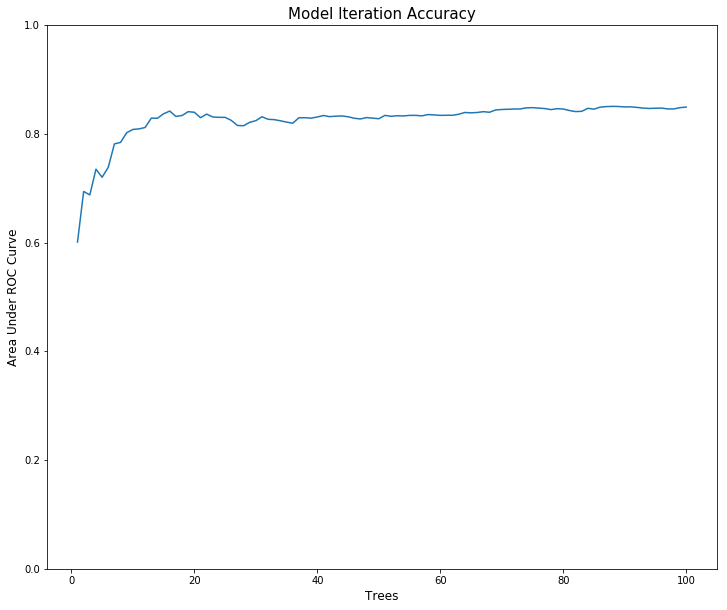

In [100]:
model, FeatImp, TestPred, DataFeatures = DiscernAnomalyModel('Tremor', 
                                                             ['Stndg', 'Sitng'], 
                                                             ['NoSymp', 'Symp'], 
                                                             [[float(0)], [float(1), float(2), float(3), float(4)]])
# model, FeatImp, TestPred, DataFeatures = DiscernAnomalyModel('Tremor', ['Stndg', 'Sitng'], [], [])

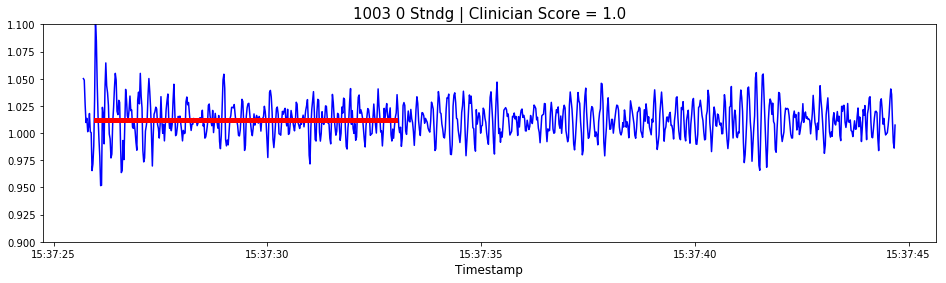

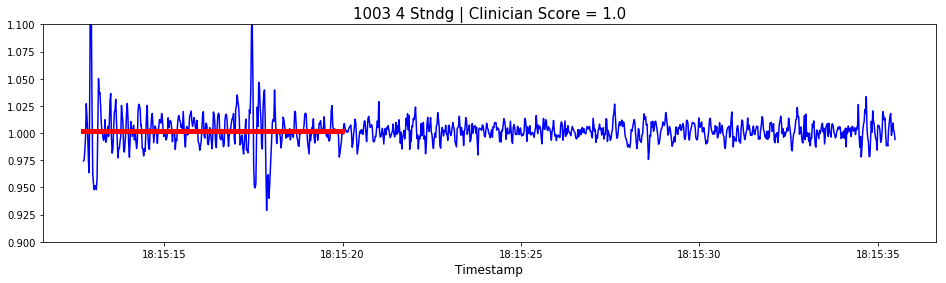

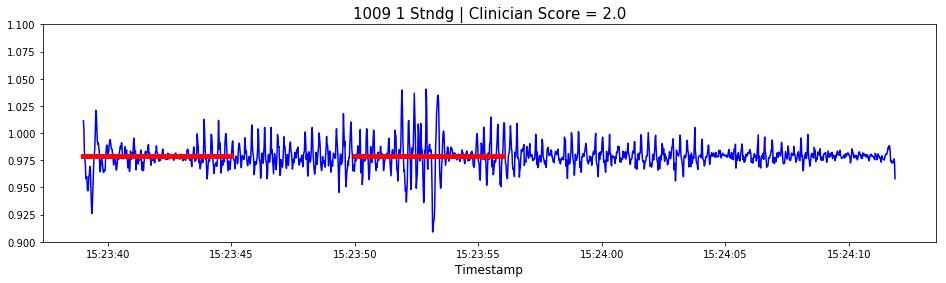

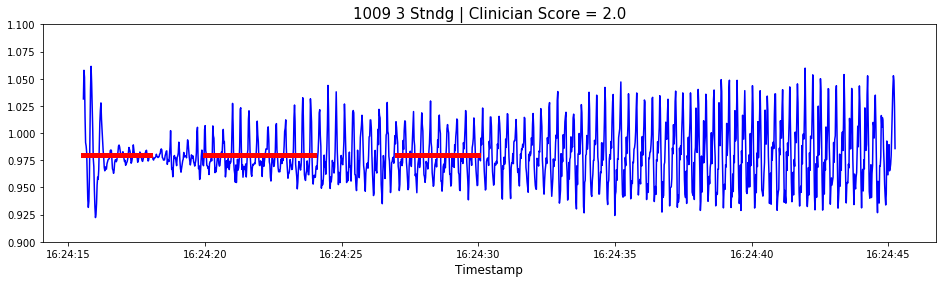

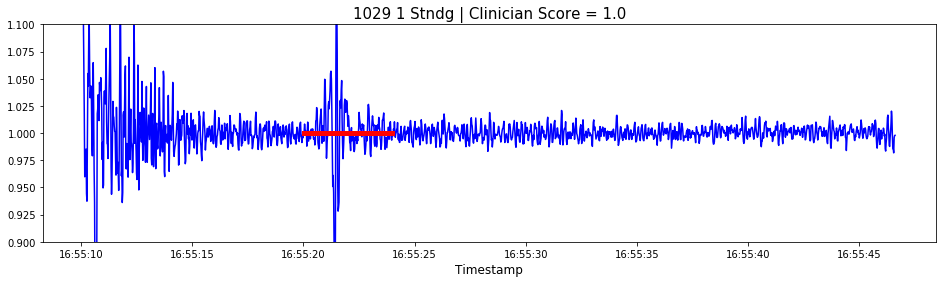

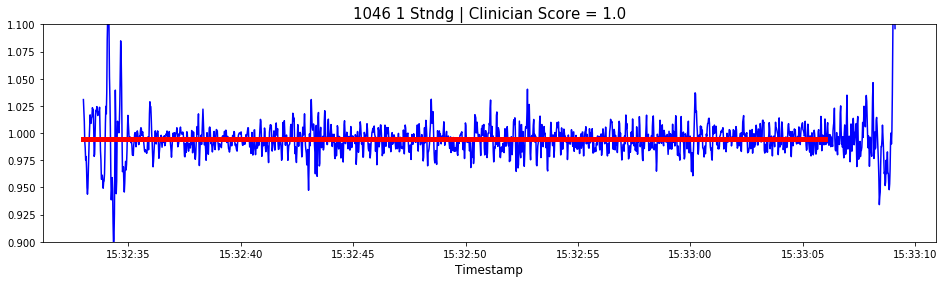

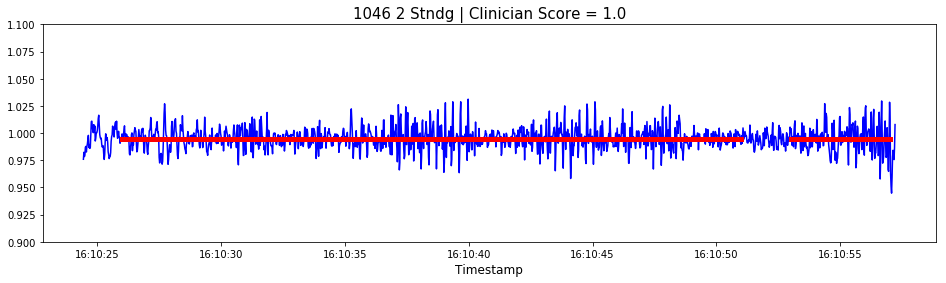

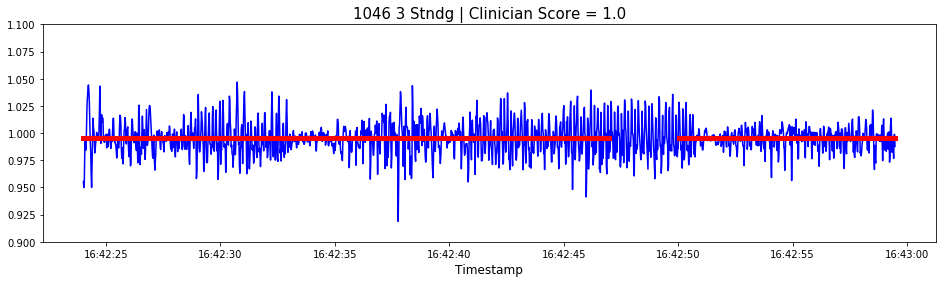

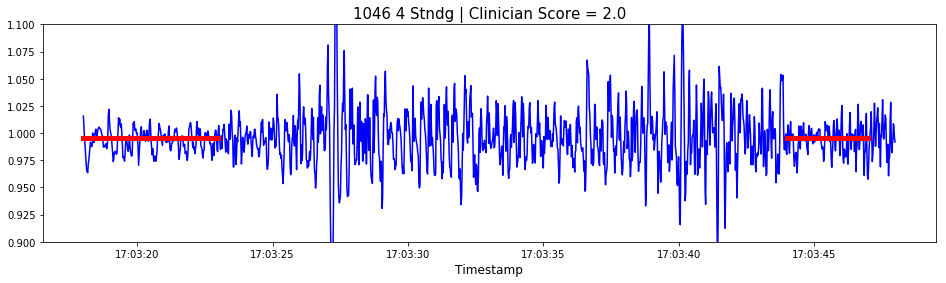

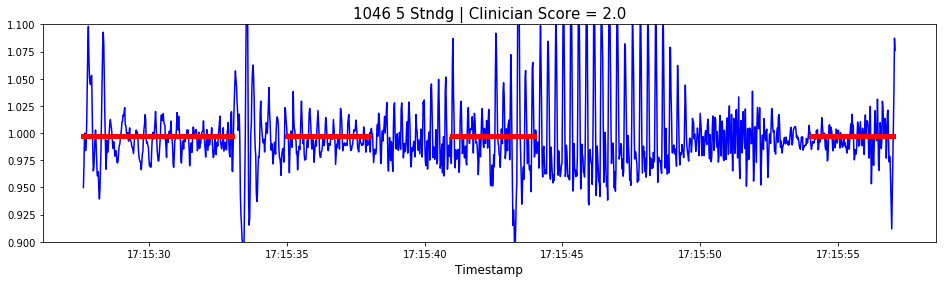

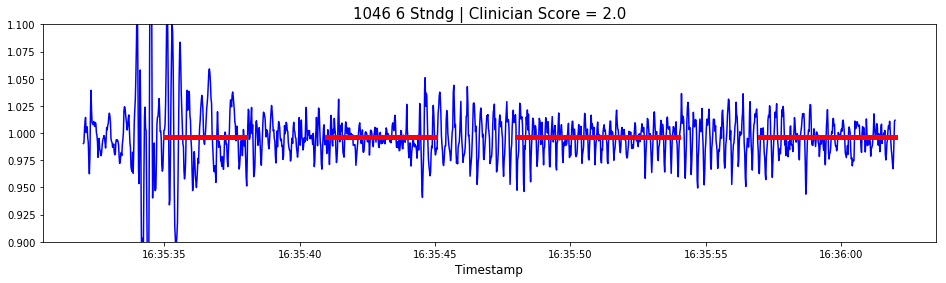

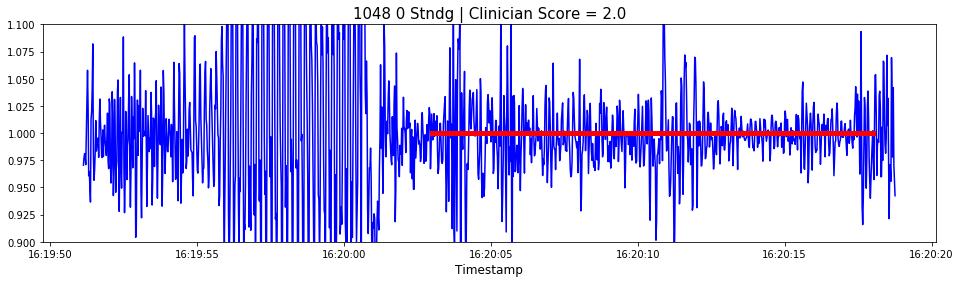

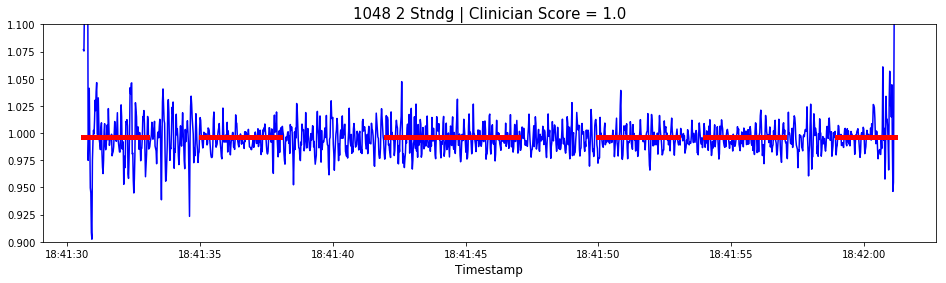

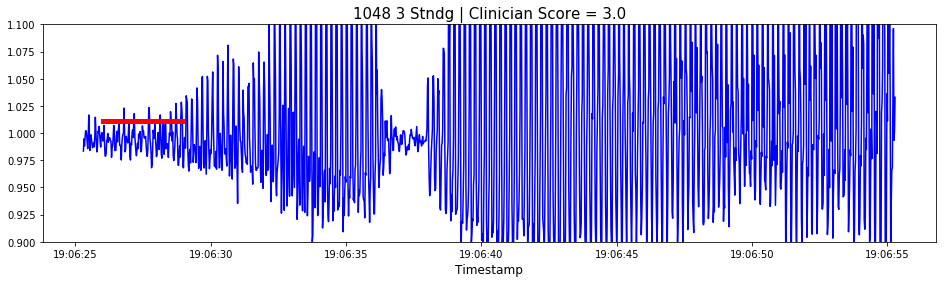

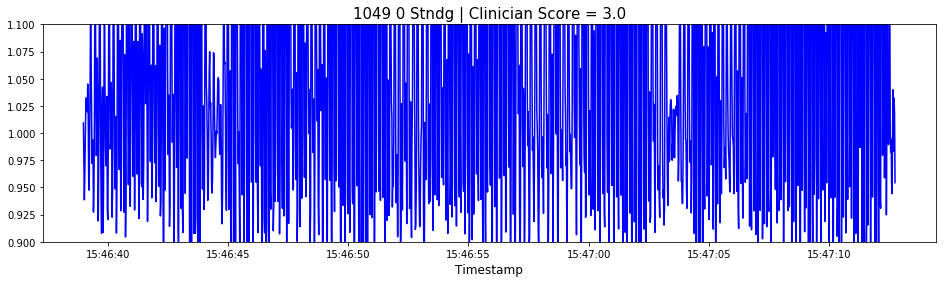

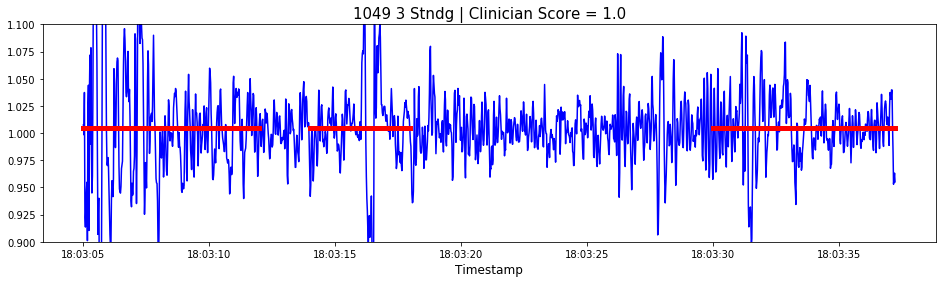

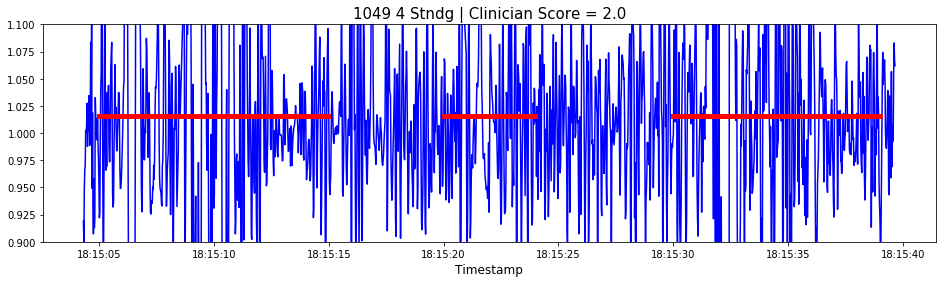

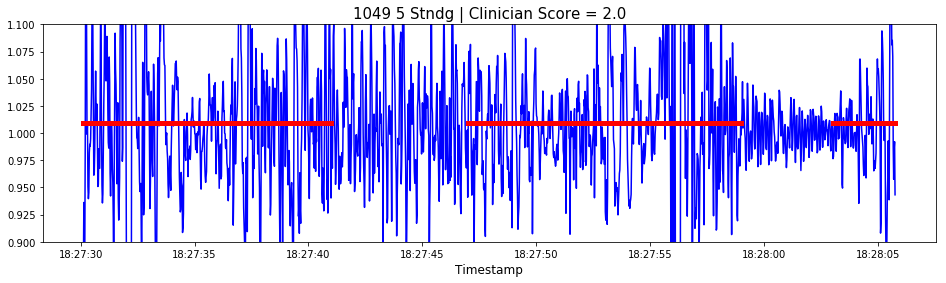

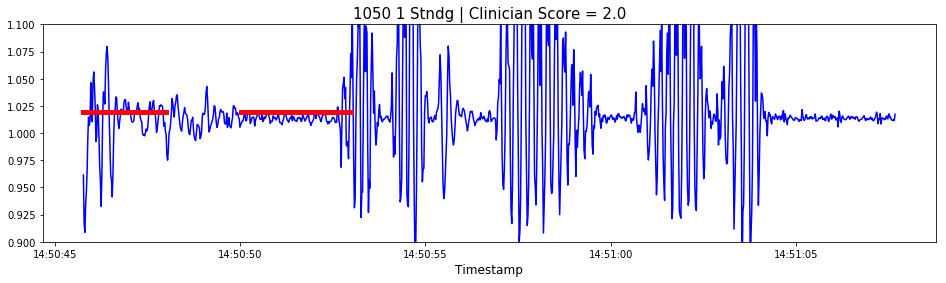

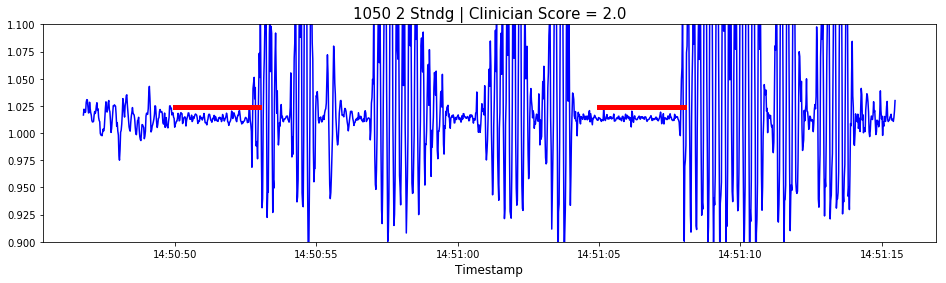

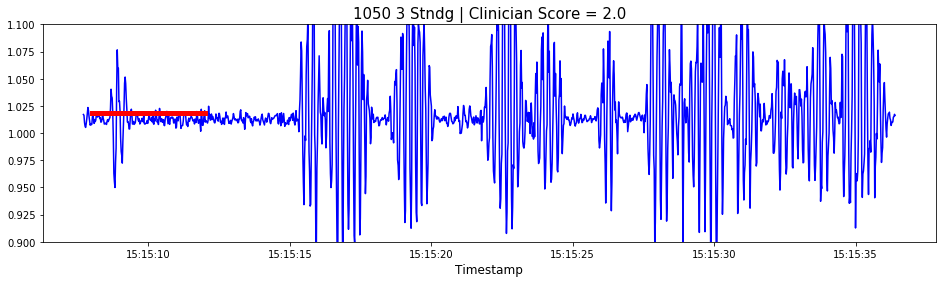

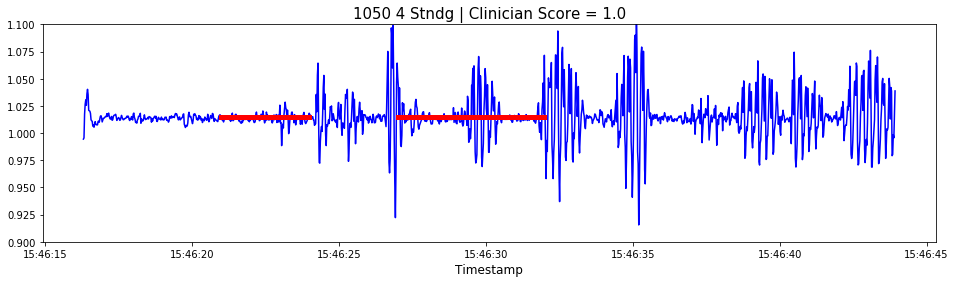

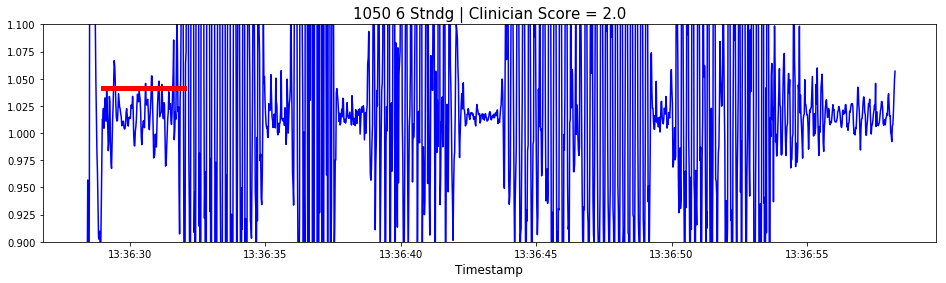

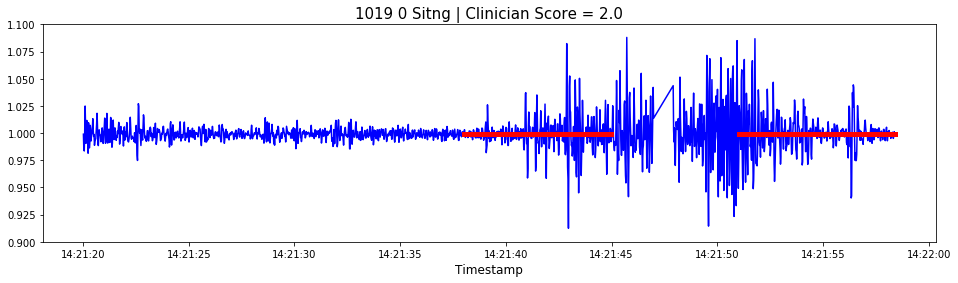

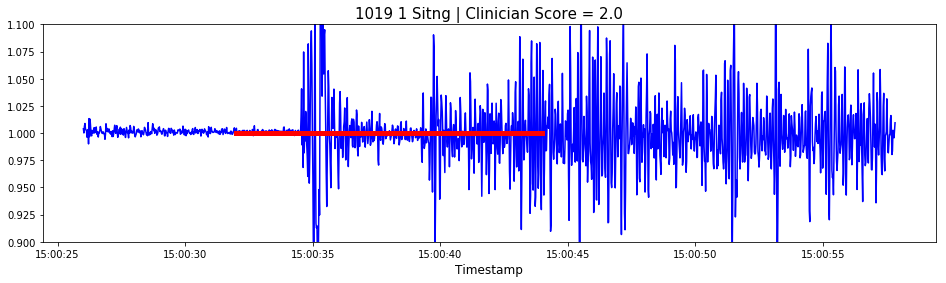

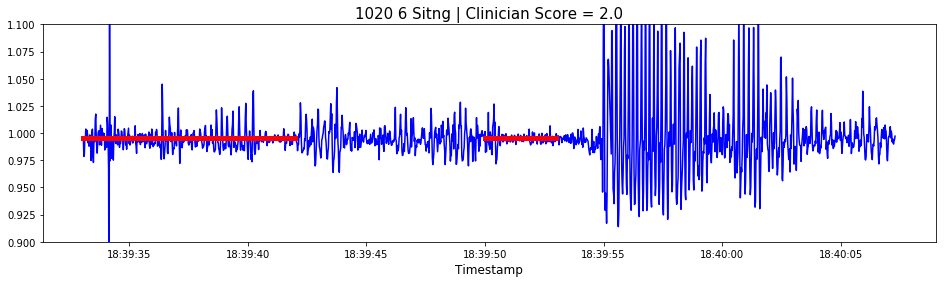

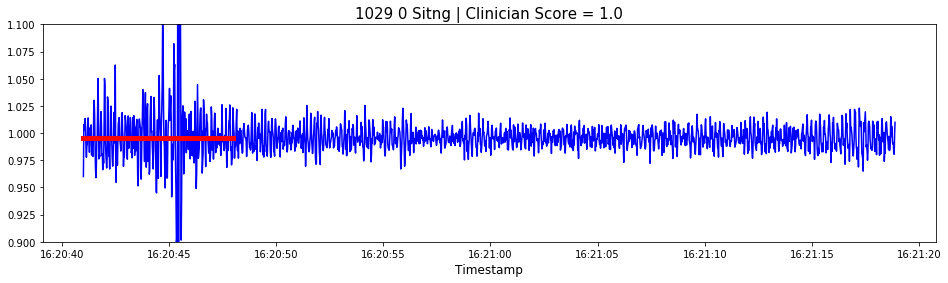

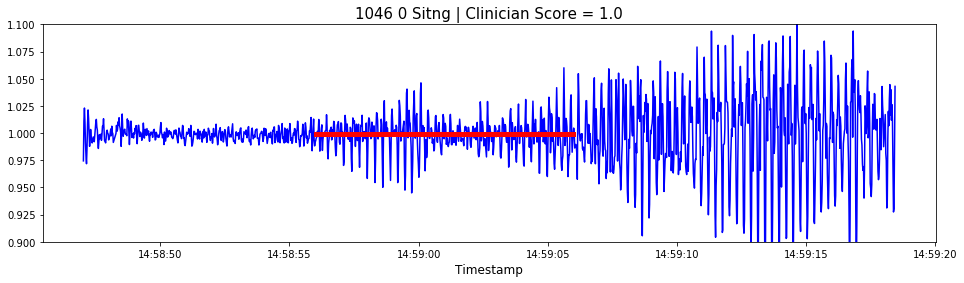

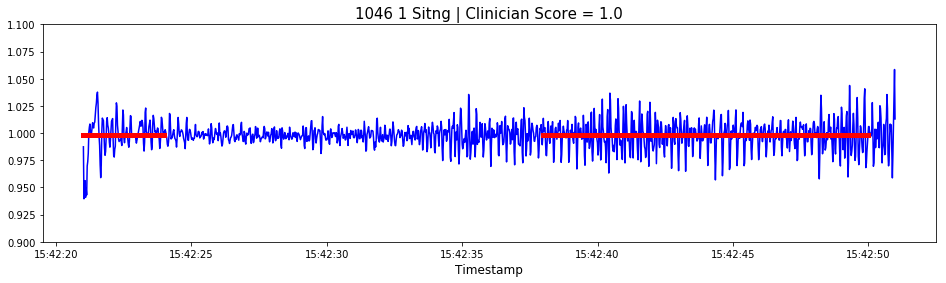

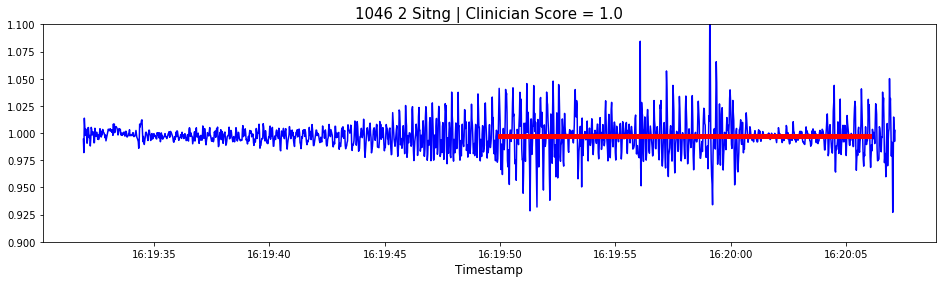

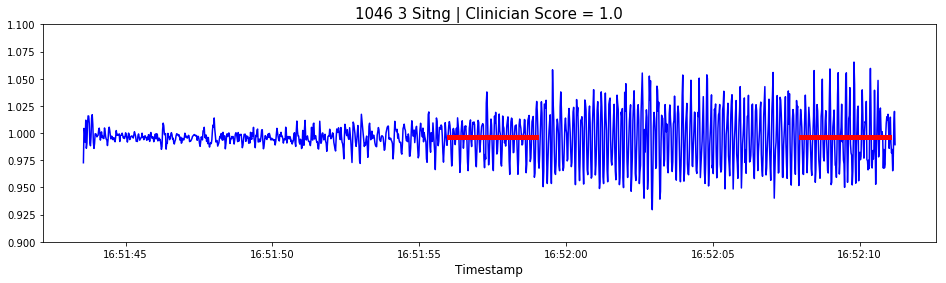

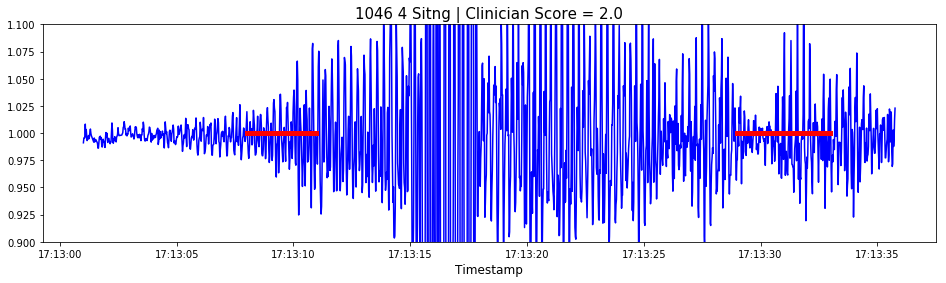

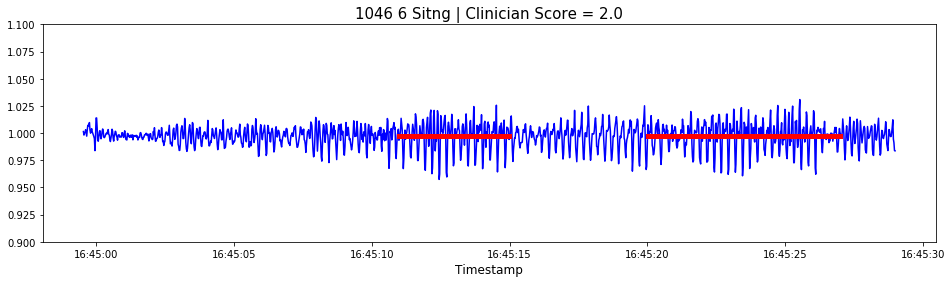

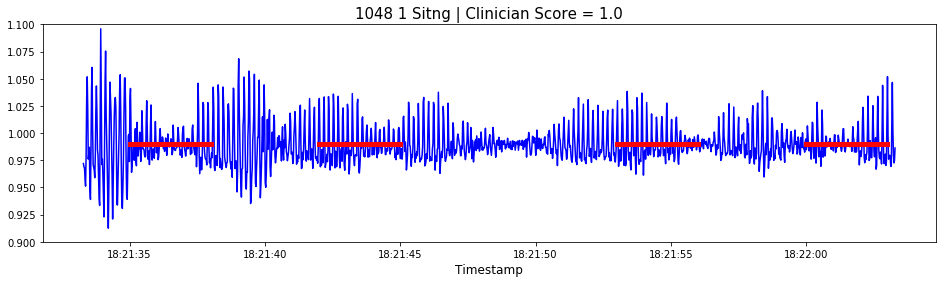

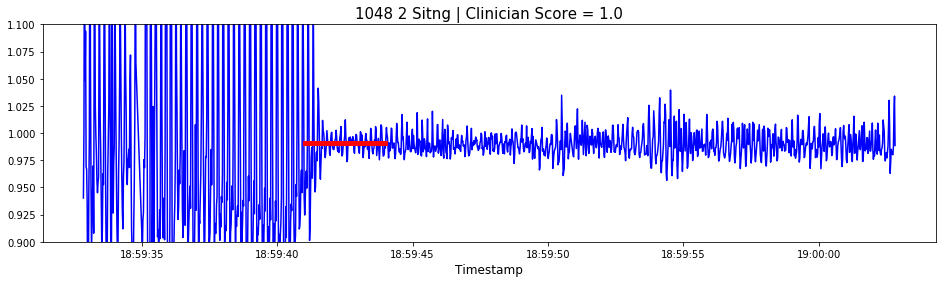

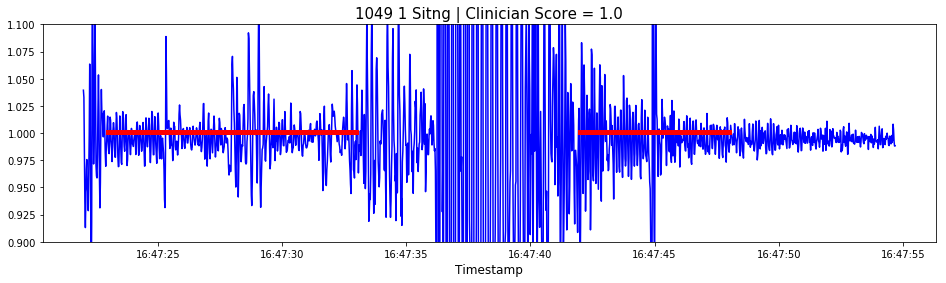

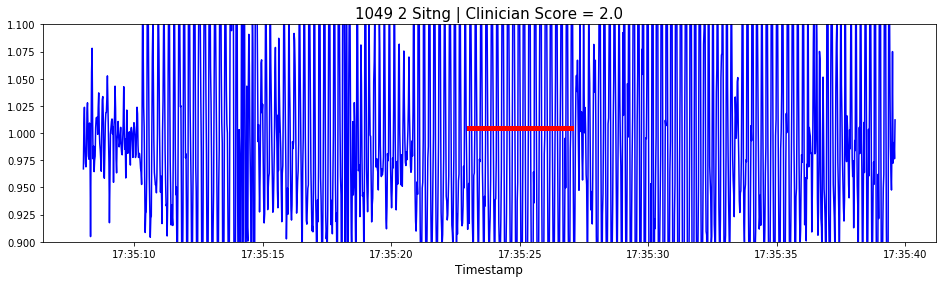

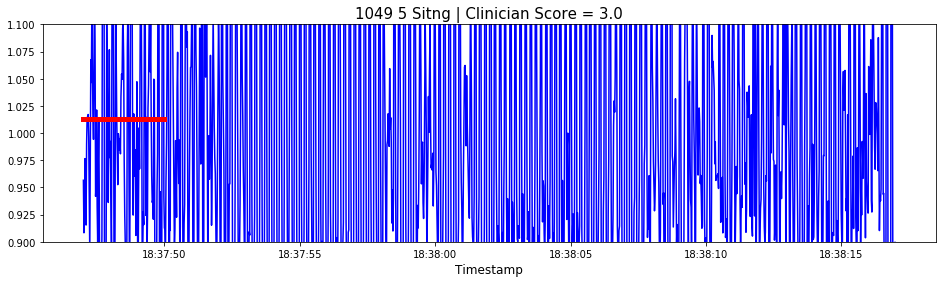

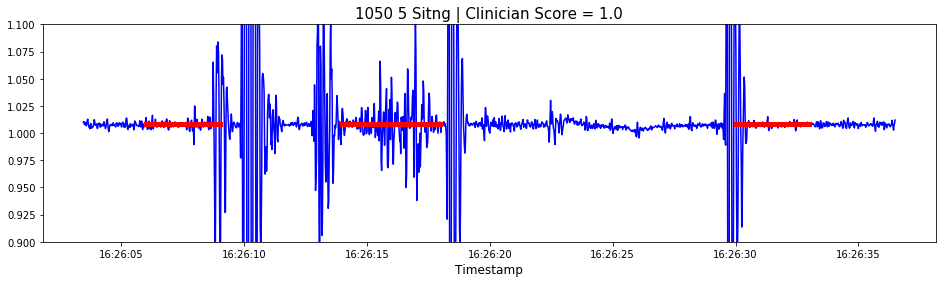

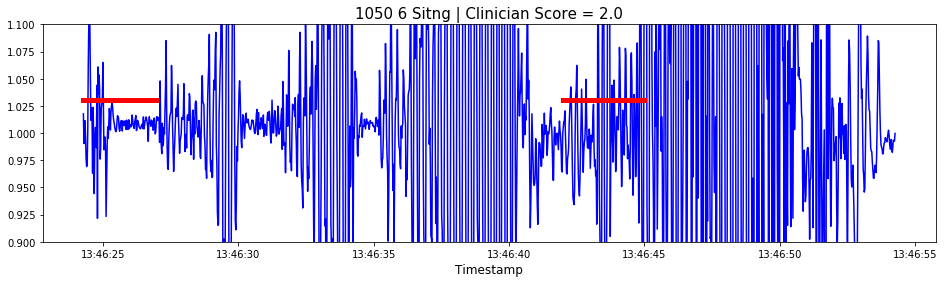

In [270]:
FalseNegatives = DataFeatures[(TestPred.TestLabs == 'Symp') & (TestPred.PredLabs == 'NoSymp')]
for task in FalseNegatives.TaskAbb.unique():
    TFalseNegatives = FalseNegatives[FalseNegatives.TaskAbb == task]
    for sub in TFalseNegatives.SubjID.unique():
        TSFalseNegatives = TFalseNegatives[TFalseNegatives.SubjID == sub]
        for visit in TSFalseNegatives.Visit.unique():
            TSVFalseNegatives = TSFalseNegatives[TSFalseNegatives.Visit == visit]
            accdata = pd.read_csv(os.path.join(path, 'TaskAcc',
                                               str(int(sub)) + '_' + str(visit) + '_' + task + '.csv'), 
                                  parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
            accdata['mag'] = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
#             accdata.loc[:, ['x', 'y', 'z', 'mag']] = filterdata(accdata[['x', 'y', 'z', 'mag']])
            SVClips = pd.DataFrame()
            plt.figure(figsize = (16, 4))
            plt.plot(accdata.timestamp, accdata['mag'].values, 'b')
            for clip in TSVFalseNegatives.iterrows():
                clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Anomaly Feature Clips', 
                                                   str(int(sub)) + '_' + str(visit) + '_' + 
                                                   clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                       parse_dates = ['Timestamp'])[['Timestamp']]
                plt.plot(clipacc.values, [np.mean(accdata['mag'].values)] * len(clipacc.values), 'r', linewidth = 5)
            plt.xlabel('Timestamp', fontsize = 12)
            plt.ylim(0.9, 1.1)
            plt.title(str(int(sub)) + ' ' + str(visit) + ' ' + TSVFalseNegatives.TaskAbb.iloc[-1] + ' | '
                      'Clinician Score = ' + str(TSVFalseNegatives.Tremor.iloc[-1]), fontsize = 15)
            plt.show()

# Predict Presence of Anomaly and Detect Symptom in those Clips

In [154]:
def DetectDiscernAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    Y = DataFeatures['Anomaly'].values
    le.fit(Y)
    Y = le.transform(Y)
    j = True
    k = True
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    
    Recording = []
    Score = []
    Prediction = []
    for task in DataFeatures.TaskAbb.unique():
        TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
        for sub in TDataFeatures.SubjID.unique():
            TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == sub]
            for visit in TSDataFeatures.Visit.unique():
                TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
                if all(TSVDataFeatures.Anomaly == 0):
                    Recording = Recording + [str(sub) + '_' + str(visit) + '_' + task]
                    Score = Score + [groupDict[0]]
                    Prediction = Prediction + [groupDict[0]]
    
    # only look at clips predicted to have an anomaly present
    # find a way to predict anomaly finder first and only train/test on those predicted to have anomaly immediately
    # is this doing the same thing?
    AnomFeatures = DataFeatures[TestPred.PredLabs == 1].reset_index(drop = True)
    
    features_list = list(AnomFeatures.columns[5:53])
    X = AnomFeatures[features_list].values
    if newLab:
        Y = AnomFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = AnomFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = AnomFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
#         CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    
    for task in AnomFeatures.TaskAbb.unique():
        TAnomFeatures = AnomFeatures[AnomFeatures.TaskAbb == task]
        for sub in TAnomFeatures.SubjID.unique():
            TSAnomFeatures = TAnomFeatures[TAnomFeatures.SubjID == sub]
            for visit in TSAnomFeatures.Visit.unique():
                TSVAnomFeatures = TSAnomFeatures[TSAnomFeatures.Visit == visit]
                TSVTestPred = TestPred.iloc[TSVAnomFeatures.index]
                if any(TSVTestPred.PredLabs == 'Symptomatic'):
                    Recording = Recording + [str(sub) + '_' + str(visit) + '_' + task]
                    if len(TSVTestPred.TestLabs.unique()) > 1:
                        print('Multiple Labels for ' + str(sub) + task + str(visit))
                    Score = Score + [TSVTestPred.TestLabs.unique()[0]]
                    Prediction = Prediction + [groupDict[1]]
                elif all(TSVTestPred.PredLabs == 'Normal'):
                    Recording = Recording + [str(sub) + '_' + str(visit) + '_' + task]
                    if len(TSVTestPred.TestLabs.unique()) > 1:
                        print('Multiple Labels for ' + str(sub) + task + str(visit))
                    Score = Score + [TSVTestPred.TestLabs.unique()[0]]
                    Prediction = Prediction + [groupDict[0]]
                else:
                    print('WE HAVE A PROBLEM')
    RecordingAnalysis = pd.DataFrame({'Recording': Recording, 'Score': Score, 'Prediction': Prediction})
    CM = sklearn.metrics.confusion_matrix(RecordingAnalysis.Score.values, RecordingAnalysis.Prediction.values, 
                                          labels = le.classes_)
                    
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100 
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 16)
    plt.ylabel('Test', fontsize = 16)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures, RecordingAnalysis

In [155]:
sns.set(font_scale = 1.5)

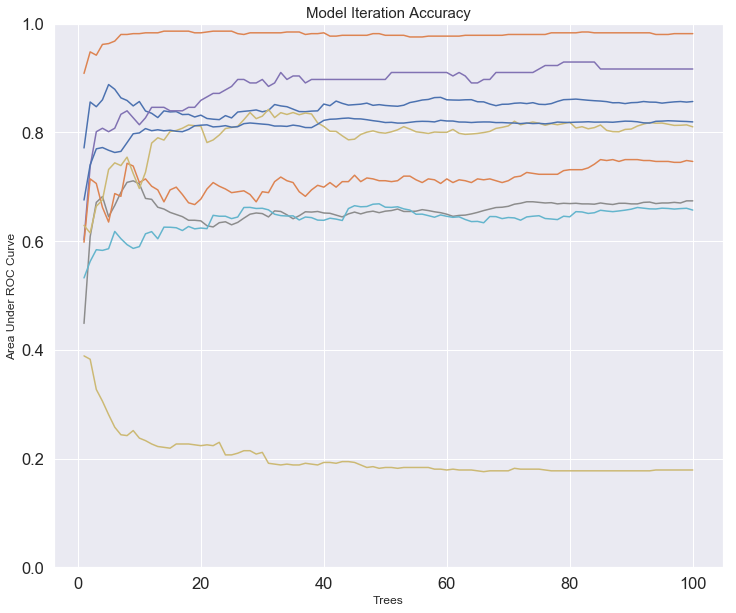

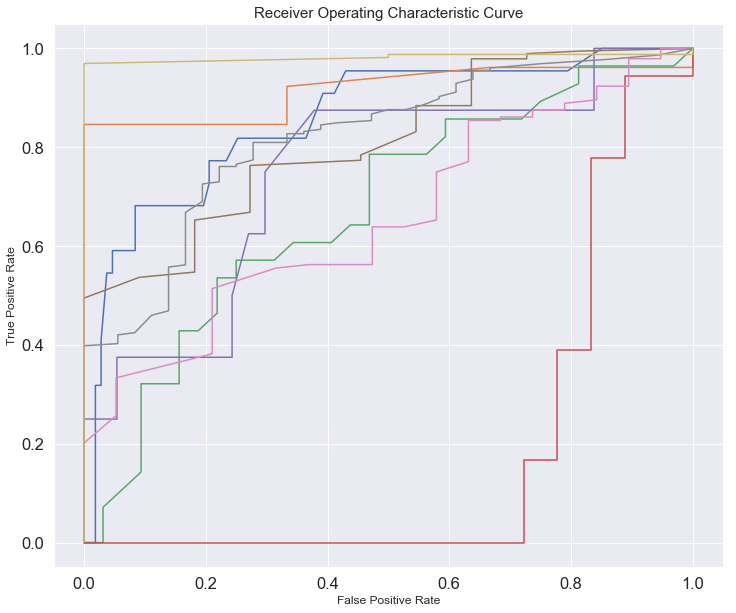

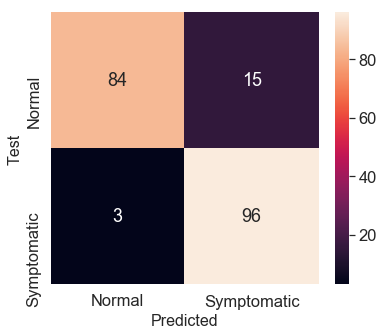

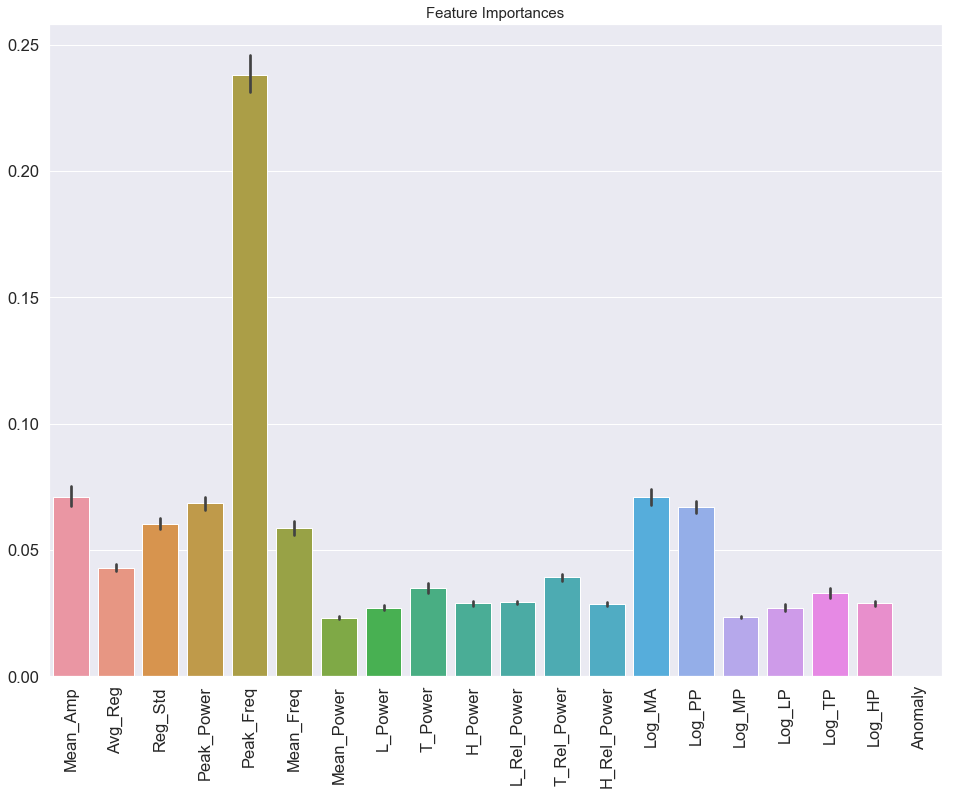

In [156]:
model, FeatImp, TestPred, DataFeatures, RecordingAnalysis = DetectDiscernAnomalyModel('Tremor', 
                                                                   ['Stndg', 'Sitng'], 
                                                                   ['Normal', 'Symptomatic'], 
                                                                   [[float(0)], [float(1), float(2), float(3), float(4)]])

In [138]:
RecordingAnalysis

Recording       Score Prediction
0    1003_4_Sitng      NoSymp     NoSymp
1    1004_0_Sitng      NoSymp     NoSymp
2    1004_1_Sitng      NoSymp     NoSymp
3    1005_0_Sitng      NoSymp     NoSymp
4    1005_1_Sitng      NoSymp     NoSymp
5    1005_2_Sitng      NoSymp     NoSymp
6    1005_3_Sitng      NoSymp     NoSymp
7    1007_1_Sitng      NoSymp     NoSymp
8    1007_2_Sitng      NoSymp     NoSymp
9    1009_1_Sitng      NoSymp     NoSymp
10   1009_2_Sitng      NoSymp     NoSymp
11   1009_4_Sitng      NoSymp     NoSymp
12   1009_5_Sitng      NoSymp     NoSymp
13   1016_0_Sitng      NoSymp     NoSymp
14   1016_2_Sitng      NoSymp     NoSymp
15   1016_6_Sitng      NoSymp     NoSymp
16   1018_0_Sitng      NoSymp     NoSymp
17   1018_1_Sitng      NoSymp     NoSymp
18   1018_3_Sitng      NoSymp     NoSymp
19   1018_4_Sitng      NoSymp     NoSymp
20   1018_5_Sitng      NoSymp     NoSymp
21   1018_6_Sitng      NoSymp     NoSymp
22   1023_0_Sitng      NoSymp     NoSymp
23   1023_2_Sitng      NoSymp     NoSymp
24   1023_3_Sitng      NoSymp     NoSymp
25   1023_4_Sitng      NoSymp     NoSymp
26   1023_5_Sitng      NoSymp     NoSymp
27   1023_6_Sitng      NoSymp     NoSymp
28   1024_1_Sitng      NoSymp     NoSymp
29   1029_1_Sitng      NoSymp     NoSymp
..            ...         ...        ...
241  1046_2_Stndg    ['Symp']     NoSymp
242  1046_3_Stndg    ['Symp']       Symp
243  1046_4_Stndg    ['Symp']       Symp
244  1046_5_Stndg    ['Symp']       Symp
245  1046_6_Stndg    ['Symp']       Symp
246  1048_0_Stndg    ['Symp']       Symp
247  1048_1_Stndg  ['NoSymp']       Symp
248  1048_2_Stndg    ['Symp']       Symp
249  1048_3_Stndg    ['Symp']       Symp
250  1048_4_Stndg    ['Symp']       Symp
251  1049_0_Stndg    ['Symp']       Symp
252  1049_1_Stndg  ['NoSymp']       Symp
253  1049_2_Stndg  ['NoSymp']       Symp
254  1049_3_Stndg    ['Symp']       Symp
255  1049_4_Stndg    ['Symp']       Symp
256  1049_5_Stndg    ['Symp']       Symp
257  1050_0_Stndg    ['Symp']       Symp
258  1050_1_Stndg    ['Symp']       Symp
259  1050_2_Stndg    ['Symp']       Symp
260  1050_3_Stndg    ['Symp']       Symp
261  1050_4_Stndg    ['Symp']       Symp
262  1050_5_Stndg    ['Symp']       Symp
263  1050_6_Stndg    ['Symp']       Symp
264  1051_0_Stndg  ['NoSymp']     NoSymp
265  1051_1_Stndg  ['NoSymp']     NoSymp
266  1051_2_Stndg  ['NoSymp']     NoSymp
267  1051_3_Stndg  ['NoSymp']     NoSymp
268  1051_4_Stndg  ['NoSymp']     NoSymp
269  1051_5_Stndg  ['NoSymp']     NoSymp
270  1051_6_Stndg  ['NoSymp']     NoSymp

[271 rows x 3 columns]

In [143]:
TestPred.TestLabs.unique()[0]

'Symp'

In [61]:
# DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
# for task in DataFeatures.TaskAbb.unique():
#     TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
#     for subj in TDataFeatures.SubjID.unique():
#         TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
#         for visit in TSDataFeatures.Visit.unique():
#             TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
#             if any(TSVDataFeatures.Tremor == 1) and any(TSVDataFeatures.Anomaly == 0):
#                 print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
#                       str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1])
                
                
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
TremAnom = DataFeatures[(DataFeatures.Anomaly == 1) & (DataFeatures.Tremor == 1)]
NoSympAnom = DataFeatures[(DataFeatures.Anomaly == 1) & (DataFeatures.Tremor == 0)]
ClipAccTA = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', '1049_3_Stndg_11.csv'), 
                        parse_dates = ['Timestamp'])
ClipAccTA['Accel_Mag'] = ((ClipAccTA[['X', 'Y', 'Z']]**2).sum(axis = 1))
Fs = np.mean(1/(np.diff(ClipAccTA.Accel_Mag.index)/1000))
f,Pxx_den = welch(ClipAccTA.Accel_Mag,Fs,nperseg=min(256,len(ClipAccTA.Accel_Mag)))
Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])
Pxxdf

PSD_magnitude
0.000000     2.580587e-07
4.672897     1.865969e-07
9.345794     2.336039e-07
14.018692    2.062982e-06
18.691589    3.074381e-06
23.364486    1.881950e-06
28.037383    1.456061e-05
32.710280    3.537763e-05
37.383178    1.379690e-05
42.056075    4.153620e-06
46.728972    5.009524e-06
51.401869    8.625506e-06
56.074766    9.584071e-07
60.747664    5.581426e-07
65.420561    5.990993e-08
70.093458    3.038144e-07
74.766355    4.550363e-07
79.439252    9.548443e-07
84.112150    3.938528e-07
88.785047    1.983696e-06
93.457944    1.244180e-06
98.130841    1.127873e-07
102.803738   1.437037e-08
107.476636   7.312965e-07
112.149533   3.190190e-06
116.822430   2.430057e-06
121.495327   1.209493e-06
126.168224   1.232313e-06
130.841121   1.822401e-06
135.514019   1.378415e-06
...                   ...
364.485981   1.172292e-07
369.158879   1.347686e-07
373.831776   2.505066e-07
378.504673   8.355520e-08
383.177570   2.233142e-08
387.850467   1.089030e-07
392.523364   1.538029e-07
397.196262   1.118234e-07
401.869159   7.125703e-08
406.542056   3.976157e-07
411.214953   2.252527e-07
415.887850   1.865090e-08
420.560748   3.207885e-08
425.233645   3.386217e-08
429.906542   5.301077e-08
434.579439   2.626090e-07
439.252336   3.880063e-08
443.925234   2.974872e-08
448.598131   2.940614e-08
453.271028   3.893496e-08
457.943925   1.939541e-08
462.616822   8.954981e-08
467.289720   1.140074e-07
471.962617   5.282414e-08
476.635514   2.191161e-07
481.308411   6.234932e-08
485.981308   1.470116e-07
490.654206   1.110035e-07
495.327103   3.409781e-08
500.000000   1.662849e-08

[108 rows x 1 columns]

In [212]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
DataFeatures

SubjID  Visit TaskAbb  Clip  Tremor      RMSX      RMSY      RMSZ  \
0     1003.0      0   Sitng     0     1.0  0.000755  0.001049  0.001079   
1     1003.0      0   Sitng     1     1.0  0.000484  0.000754  0.000634   
2     1003.0      0   Sitng     2     1.0  0.000562  0.000662  0.000531   
3     1003.0      0   Sitng     3     1.0  0.000538  0.000592  0.000550   
4     1003.0      0   Sitng     4     1.0  0.000494  0.000642  0.000583   
5     1003.0      0   Sitng     5     1.0  0.000497  0.000703  0.000771   
6     1003.0      0   Sitng     6     1.0  0.000540  0.000710  0.000846   
7     1003.0      0   Sitng     7     1.0  0.000629  0.000874  0.000897   
8     1003.0      0   Sitng     8     1.0  0.000626  0.001077  0.000985   
9     1003.0      0   Sitng     9     1.0  0.000670  0.001303  0.001137   
10    1003.0      0   Sitng    10     1.0  0.000788  0.001158  0.001006   
11    1003.0      0   Sitng    11     1.0  0.000841  0.001140  0.000949   
12    1003.0      0   Sitng    12     1.0  0.000887  0.001233  0.001058   
13    1003.0      0   Sitng    13     1.0  0.000927  0.001423  0.001113   
14    1003.0      0   Sitng    14     1.0  0.000930  0.001363  0.001210   
15    1003.0      0   Stndg     0     1.0  0.001097  0.002338  0.001428   
16    1003.0      0   Stndg     1     1.0  0.000631  0.001161  0.000791   
17    1003.0      0   Stndg     2     1.0  0.000584  0.001210  0.000811   
18    1003.0      0   Stndg     3     1.0  0.000575  0.001160  0.000774   
19    1003.0      0   Stndg     4     1.0  0.000539  0.001092  0.000720   
20    1003.0      0   Stndg     5     1.0  0.000673  0.001009  0.000753   
21    1003.0      0   Stndg     6     1.0  0.000720  0.001067  0.000759   
22    1003.0      0   Stndg     7     1.0  0.001039  0.001612  0.001406   
23    1003.0      1   Sitng     0     0.0  0.011928  0.007735  0.007512   
24    1003.0      1   Sitng     1     0.0  0.011914  0.006870  0.006227   
25    1003.0      1   Sitng     2     0.0  0.012578  0.008003  0.004698   
26    1003.0      1   Sitng     3     0.0  0.011683  0.007644  0.005282   
27    1003.0      1   Sitng     4     0.0  0.008970  0.005023  0.004471   
28    1003.0      1   Sitng     5     0.0  0.011169  0.007857  0.006136   
29    1003.0      1   Sitng     6     0.0  0.009468  0.007168  0.005595   
...      ...    ...     ...   ...     ...       ...       ...       ...   
3421  1051.0      5   Stndg    10     0.0  0.000312  0.000427  0.000346   
3422  1051.0      5   Stndg    11     0.0  0.000439  0.000614  0.000437   
3423  1051.0      5   Stndg    12     0.0  0.000556  0.000747  0.000504   
3424  1051.0      6   Sitng     0     0.0  0.000803  0.001075  0.001170   
3425  1051.0      6   Sitng     1     0.0  0.000381  0.000823  0.000825   
3426  1051.0      6   Sitng     2     0.0  0.000296  0.000217  0.000186   
3427  1051.0      6   Sitng     3     0.0  0.000277  0.000175  0.000208   
3428  1051.0      6   Sitng     4     0.0  0.000171  0.000182  0.000200   
3429  1051.0      6   Sitng     5     0.0  0.000180  0.000195  0.000199   
3430  1051.0      6   Sitng     6     0.0  0.000157  0.000175  0.000164   
3431  1051.0      6   Sitng     7     0.0  0.000185  0.000214  0.000213   
3432  1051.0      6   Sitng     8     0.0  0.000202  0.000231  0.000248   
3433  1051.0      6   Sitng     9     0.0  0.000313  0.000249  0.000382   
3434  1051.0      6   Sitng    10     0.0  0.000385  0.000323  0.000471   
3435  1051.0      6   Stndg     0     0.0  0.000813  0.001109  0.000703   
3436  1051.0      6   Stndg     1     0.0  0.000530  0.000740  0.000467   
3437  1051.0      6   Stndg     2     0.0  0.000208  0.000290  0.000167   
3438  1051.0      6   Stndg     3     0.0  0.000168  0.000281  0.000190   
3439  1051.0      6   Stndg     4     0.0  0.000206  0.000342  0.000182   
3440  1051.0      6   Stndg     5     0.0  0.000201  0.000376  0.000226   
3441  1051.0      6   Stndg     6     0.0  0.000205  0.000404  0.000238   
3442  1051.0      6   Stndg    

In [217]:
clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
clinicData = clinicData[clinicData.TaskAbb == 'Wlkg']
clinicData[(clinicData['Bradykinesia - Left'] > 1) | (clinicData['Bradykinesia - Left'] > 1)]

SubjID              Visit     Task TaskAbb    Start Timestamp (UTC)  \
13    1003.0    2 Weeks: Time 0  Walking    Wlkg  2017-07-03 15:38:16.810   
223   1005.0    2 Weeks: Time 0  Walking    Wlkg      2017-07-03 13:55:00   
238   1005.0   2 Weeks: Time 30  Walking    Wlkg  2017-07-03 14:38:51.684   
253   1005.0   2 Weeks: Time 60  Walking    Wlkg  2017-07-03 15:07:00.966   
418   1009.0    2 Weeks: Time 0  Walking    Wlkg      2017-07-10 14:37:09   
943   1023.0    2 Weeks: Time 0  Walking    Wlkg  2017-07-31 11:59:43.813   
1048  1024.0    2 Weeks: Time 0  Walking    Wlkg  2017-07-19 17:47:16.594   
1573  1039.0    2 Weeks: Time 0  Walking    Wlkg  2017-08-03 11:54:04.666   
1588  1039.0   2 Weeks: Time 30  Walking    Wlkg  2017-08-03 12:22:21.366   
1648  1039.0  2 Weeks: Time 150  Walking    Wlkg  2017-08-03 14:22:02.738   
1678  1043.0    2 Weeks: Time 0  Walking    Wlkg  2017-08-15 12:44:39.020   
1693  1043.0   2 Weeks: Time 30  Walking    Wlkg  2017-08-15 13:35:04.854   
1738  1043.0  2 Weeks: Time 120  Walking    Wlkg  2017-08-15 15:05:00.585   
1978  1046.0            1 Month  Walking    Wlkg  2017-10-04 16:36:27.476   
2158  1048.0  2 Weeks: Time 120  Walking    Wlkg  2017-09-11 19:37:33.836   
2413  1051.0    2 Weeks: Time 0  Walking    Wlkg  2017-09-13 15:46:52.655   
2698  1054.0    2 Weeks: Time 0  Walking    Wlkg      2018-02-28 18:51:02   
2713  1054.0   2 Weeks: Time 30  Walking    Wlkg      2018-02-28 19:35:25   
2908  1056.0   2 Weeks: Time 60  Walking    Wlkg      2018-03-08 20:25:00   
2923  1056.0   2 Weeks: Time 90  Walking    Wlkg      2018-03-08 21:18:13   

         Stop Timestamp (UTC)  Tremor - Left  Tremor - Right  \
13    2017-07-03 15:38:57.249            0.0             0.0   
223       2017-07-03 13:55:30            0.0             0.0   
238   2017-07-03 14:39:18.828            0.0             0.0   
253   2017-07-03 15:07:28.581            0.0             0.0   
418       2017-07-10 14:37:39            1.0             2.0   
943   2017-07-31 12:00:18.867            0.0             0.0   
1048  2017-07-19 17:47:50.129            0.0             0.0   
1573  2017-08-03 11:54:42.572            0.0             0.0   
1588  2017-08-03 12:22:54.519            0.0             0.0   
1648  2017-08-03 14:22:36.012            0.0             0.0   
1678  2017-08-15 12:45:13.226            2.0             1.0   
1693  2017-08-15 13:35:35.417            0.0             0.0   
1738  2017-08-15 15:05:39.446            0.0             0.0   
1978  2017-10-04 16:37:03.827            0.0             2.0   
2158  2017-09-11 19:38:08.804            0.0             3.0   
2413  2017-09-13 15:47:41.044            0.0             0.0   
2698      2018-02-28 18:51:32            0.0             0.0   
2713      2018-02-28 19:35:55            0.0             0.0   
2908      2018-03-08 20:25:30            3.0             3.0   
2923      2018-03-08 21:18:43            3.0             2.0   

      Bradykinesia - Left  Bradykinesia - Right  Dyskinesia - Left  \
13                    3.0                   2.0                0.0   
223                   2.0                   0.0                0.0   
238                   3.0                   0.0                0.0   
253                   2.0                   0.0                0.0   
418                   2.0                   1.0                0.0   
943                   2.0                   2.0                0.0   
1048                  2.0                   2.0                0.0   
1573                  2.0                   1.0                0.0   
1588                  2.0                   1.0                0.0   
1648                  2.0                   0.0                0.0   
1678                  3.0                   3.0                0.0   
1693                  2.0                   2.0                0.0   
1738                  2.0                   1.0                0.0   
1978                  2.0                   2.0                